# PROJECT - TRAFFIC-SIGN CLASSIFICATION 

## Implementation Approach

### Overview:

#### Primary Objective: 

Create a deep learning convolutional neural network model that is able to classify traffic-sign images.

#### Dataset
For this project the dataset that is used will be from German Traffic Sign Benchmarks. Currently this dataset reflects the largest collection of Traffic-Sign images which makes it ideal for training and testing a machine-learning classification model like Le-Net.

* (1) https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

* (2) https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

* (3) https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip


### Pipeline Architecture:

The following sections below comprise of different implementation phases:

1. Exploring Data & Analysis

2. Model Architecture & Implementation

3. Pipeline Architecture & Implementation

4. Image Preprocessing

5. Improving Network Model

6. Testing and Results

## Prerequisite Libraries

Import for following packages to be able to run the code segments:

In [2]:
import glob
import cv2 # To install OpenCV -> pip install "opencv-python-headless<4.3" (Terminal)
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

ggplot = 'ggplot'
retina = 'retina'
matplotlib.style.use(ggplot)
%matplotlib inline
%config InlineBackend.figure_format = retina

print("MODULES IMPORT SUCCESSFULL!")

MODULES IMPORT SUCCESSFULL!


## 1 - EXPLORING DATA & ANALYSIS

## Load Training Data 

Combine all the image paths into a single data-frame for convenience.

In [3]:
TRAIN_IMAGE_DIR = 'data/Final_Training/Images' # Stores the path that contains the training images (Final_Training)

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('/')[3]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x)) # Added TRAIN_IMAGE_DIR path.
    dfs.append(df) # Adds the filenames from the dataset and stores into the empty array 'dfs'.

**Code Reference:**

- 'TRAIN_IMAGE_DIR' variable had been added to declare the path of which training images (Final_Training) are stored.
- 'df' variable had been modified to then load the image details from the data-frame. Append the details in an array (dfs) for later on.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) Rendering Images - Toward Data Science (2020) 
[https://towardsdatascience.com/rendering-images-inside-a-pandas-dataframe-3631a4883f60]

In [4]:
# Pandas library 'pd' is used to load all the columns from the data-frame. Below is just highlighting the top rows.
traffic_sign_train_df = pd.concat(dfs, ignore_index=True) # Combine all the images from the dataset into a single data-frame.
traffic_sign_train_df.head() # Returns top row from the data-frame created.

Filename  Width  Height  Roi.X1  \
0  data/Final_Training/Images/00008/00000_00000.ppm     36      36       6   
1  data/Final_Training/Images/00008/00000_00001.ppm     35      37       5   
2  data/Final_Training/Images/00008/00000_00002.ppm     36      36       5   
3  data/Final_Training/Images/00008/00000_00003.ppm     37      37       5   
4  data/Final_Training/Images/00008/00000_00004.ppm     38      38       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       6      31      31        8  
1       6      30      32        8  
2       5      31      31        8  
3       5      32      32        8  
4       6      33      33        8

### Column Details:

* Filename: Filename of corresponding image

* Width: Image width.

* Height: Image height.

* ROI.x1: X-coordinate of top-left corner of traffic sign bounding box.

* ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box.

* ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box.

* ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box.

* ClassId: Image class label that has been assigned.

## Distribution of Traffic-Sign Images Per Class

There are 43 traffic sign classes which represent individual traffic-sign images, overall in total the sum of images from each and every class equals to -> 39,209 training images.

In [5]:
N_CLASSES = np.unique(traffic_sign_train_df['ClassId']).size  # N_CLASS created to store class IDs for each Traffic-Sign

print("Number of Training Images : {:>5}".format(traffic_sign_train_df.shape[0])) # Outputs the number of training images.
print("Number of Classes         : {:>5}".format(N_CLASSES)) # Outputs the number of classes available within dataset.

Number of Training Images : 39209
Number of Classes         :    43


In [6]:
def show_class_distribution(classIDs, title): # Method that plots the histogram plot showing image distribution.
    """
    Histogram plot for Traffic-Sign images distribution per class.
    """
    plt.figure(figsize=(15, 5)) # Plot settings for histogram is set.
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES, color = "skyblue", ec="black") # Plotting Data using Histogram using specified colour settings.
    plt.show() # Output histogram.

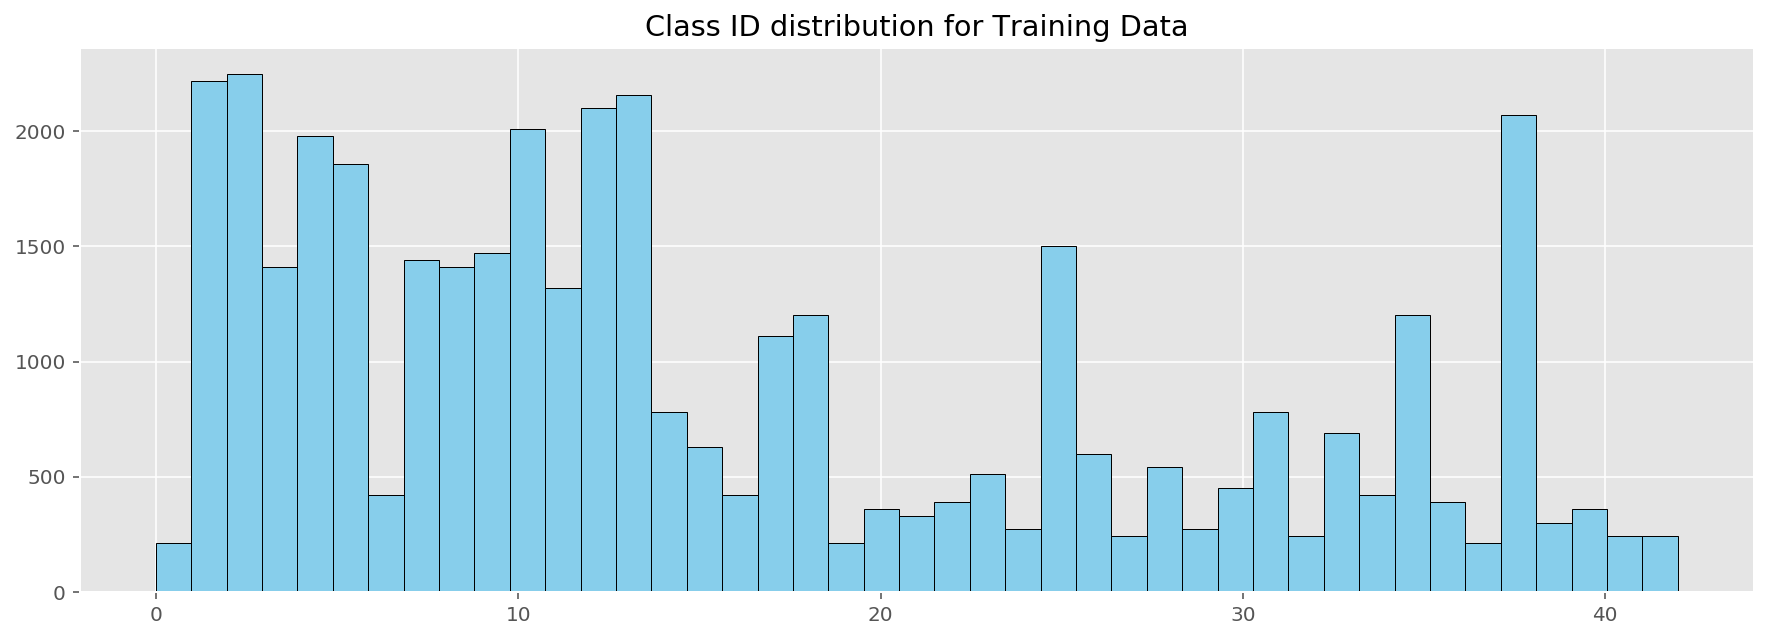

In [7]:
show_class_distribution(traffic_sign_train_df['ClassId'], 'Training Data')

The above chart highlights the total images available per traffic sign label or class, this unequal distribution of images will have an impact on the final result, it is worth augmentating the images during preprocessing stage.

**Code Reference:**

- Histogram chart plot had been simply formatted to reflect each individual bar as skyblue with black outline, improves the clarity of each bar.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) Matplotlib (2017) [https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html]

In [9]:
traffic_sign_df = pd.read_csv('TrafficSignNames.csv', index_col='ClassId') # Pandas used to read the class ID column from the TrafficSignNames.csv file.
traffic_sign_df.head() # Outputs the top row of the data-frame.

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

In [10]:
traffic_sign_df['Count'] = [sum(traffic_sign_train_df['ClassId']==c) for c in range(N_CLASSES)] # Retrieves the Count column from the data-frame.
traffic_sign_df.sort_values('Count', ascending=True) # Outputs the quantity of images within each class in ascending order.

SignName  Count
ClassId                                                          
0                                     Speed limit (20km/h)    210
37                                     Go straight or left    210
19                             Dangerous curve to the left    210
32                     End of all speed and passing limits    240
27                                             Pedestrians    240
41                                       End of no passing    240
42       End of no passing by vehicles over 3.5 metric ...    240
24                               Road narrows on the right    270
29                                       Bicycles crossing    270
39                                               Keep left    300
21                                            Double curve    330
40                                    Roundabout mandatory    360
20                            Dangerous curve to the right    360
36                                    Go straight or right    390
22                                              Bumpy road    390
6                              End of speed limit (80km/h)    420
16                Vehicles over 3.5 metric tons prohibited    420
34                                         Turn left ahead    420
30                                      Beware of ice/snow    450
23                                           Slippery road    510
28                                       Children crossing    540
26                                         Traffic signals    600
15                                             No vehicles    630
33                                        Turn right ahead    689
14                                                    Stop    780
31                                   Wild animals crossing    780
17                                                No entry   1110
18                                         General caution   1200
35                                              Ahead only   1200
11                   Right-of-way at the next intersection   1320
3                                     Speed limit (60km/h)   1410
8                                    Speed limit (120km/h)   1410
7                                    Speed limit (100km/h)   1440
9                                               No passing   1470
25                                               Road work   1500
5                                     Speed limit (80km/h)   1860
4                                     Speed limit (70km/h)   1980
10            No passing for vehicles over 3.5 metric tons   2010
38                                              Keep right   2070
12                                           Priority road   2100
13                                                   Yield   2160
1                                     Speed limit (30km/h)   2220
2                                     Speed limit (50km/h)   2250

The following constant is defined for later use.

In [11]:
# Creating a data-frame to store each Traffic-Sign image from the dataset, specifically the name of each class.
TRAFFIC_SIGN_NAMES = traffic_sign_df.SignName.values # Stores the sign name of each class.
TRAFFIC_SIGN_NAMES[0]                                # Calls upon class index 0.

'Speed limit (20km/h)'

**Code Reference:**

- 'traffic_sign_df' variable had been created and used to retrieve the class ID's and quantity of images from each class. Also used to load the names and class id stored within the TrafficSignNames.csv file (created by myself).
- 'TRAFFIC_SIGN_NAMES' variable created to return the name label associated with a class ID value.
    - i.e. Class ID 0 -> Speed limit (20km/h)


The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) Pandas PyData (2020) [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html]

## Inspection of image sample

Below I will highlight a sample of images from the German-Traffic sign benchmark.

In [12]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)

In [13]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [14]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=10)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=10)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

**Code Reference:**

No modifications has been made for (Image Sample) inspection methods.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]

Random-sample images generated from the Training dataset.

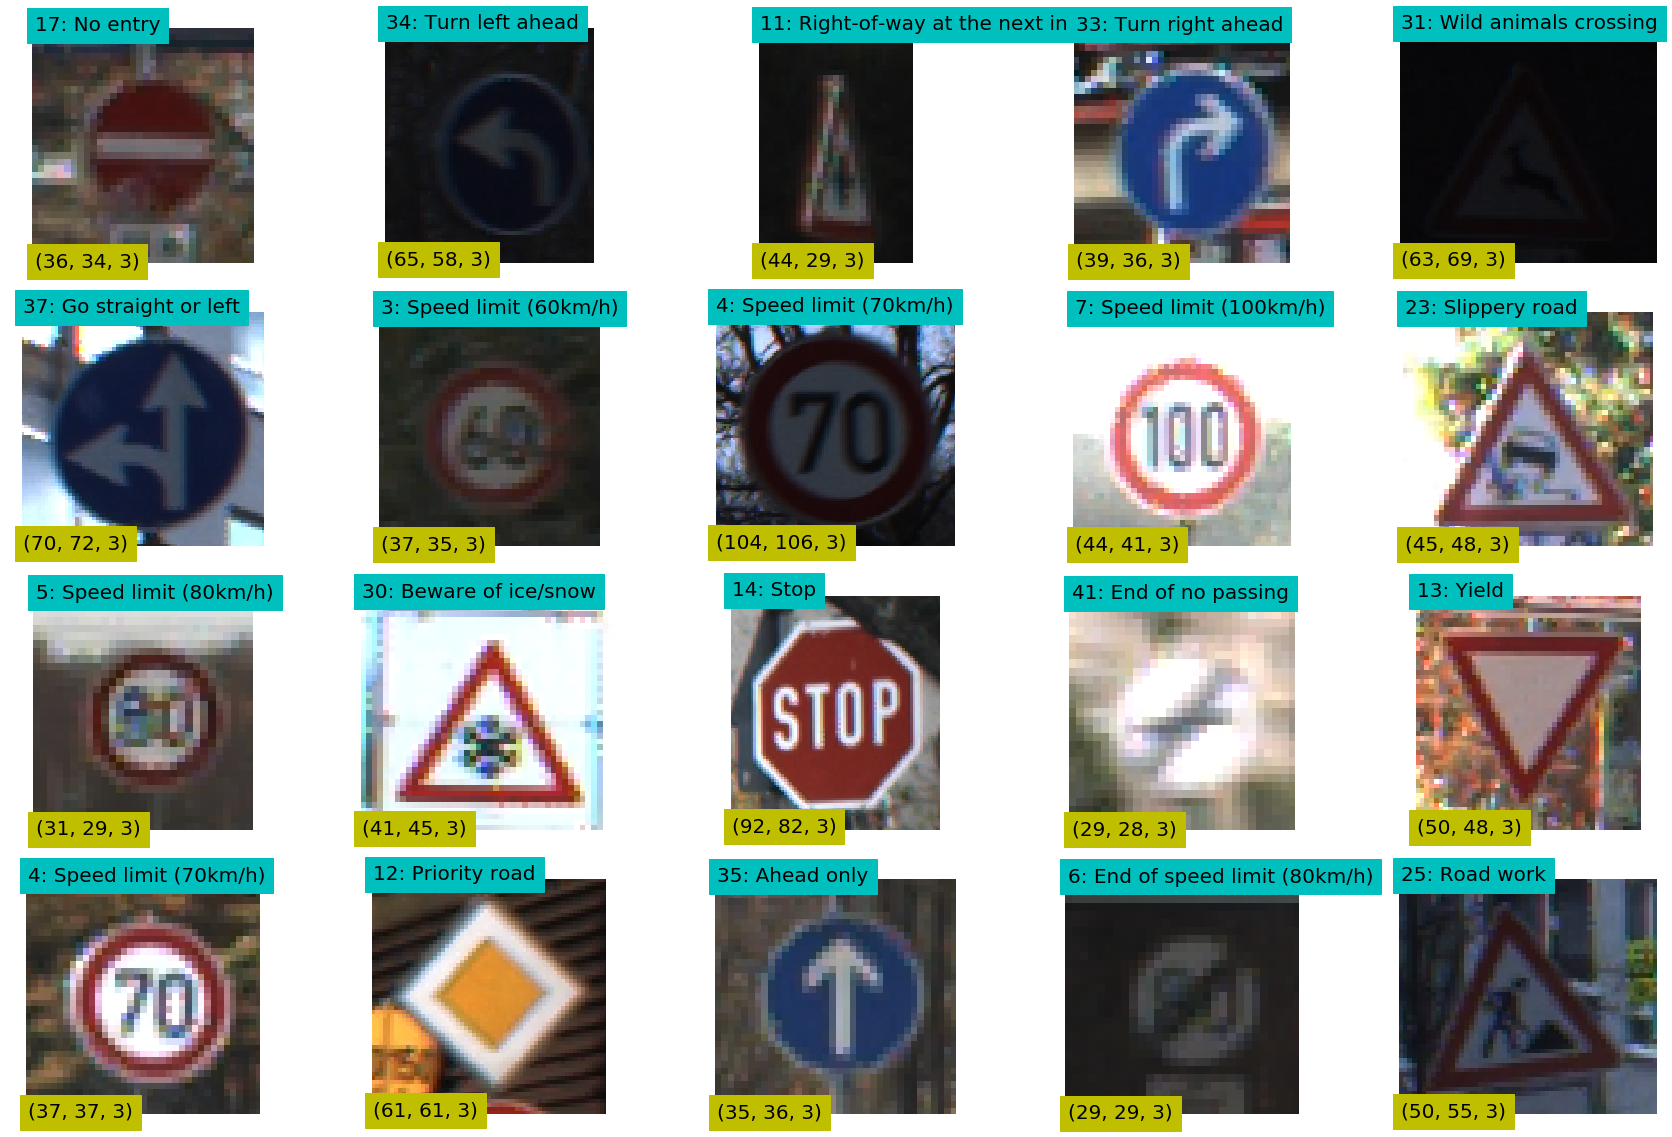

In [15]:
sample_data = get_samples(traffic_sign_train_df, 20) # sample_data variable calls the get_samples functio that will load 20 random images from dataset.
show_images(sample_data, sign_names=TRAFFIC_SIGN_NAMES, show_shape=True) # show_images method that generates sample images from the dataframe defined.

From the sample images it is quite clear their are distortions with the images and this could influence how well the model classifies each image as a result these will need to be addressed to ensure classification of traffic-signs are optimal, below are a list of all the distortions with the sample images that need to be addressed.

**Image Distortions:**
- The images vary in terms of size.
- The image lighting is unequal (brightness / hue).
- The images vary as some are slightly rotated.
- The images are not entirely straight, some images are titled.
- The images are not aligned in the middle (centre).
- The first point will be handled in the image pre-processing, and the remaining points will be handled in the image augmentation.

These distortions will be handled during image pre-processing and image augmentation. Whether improving these image distortions being addressed will improve network performance? will also be checked.

**Note: The goal is to improve the quality of each image thus clarity is improved and the CNN model is able to recognise these images more clearly.**

Speed limit (20km/h)


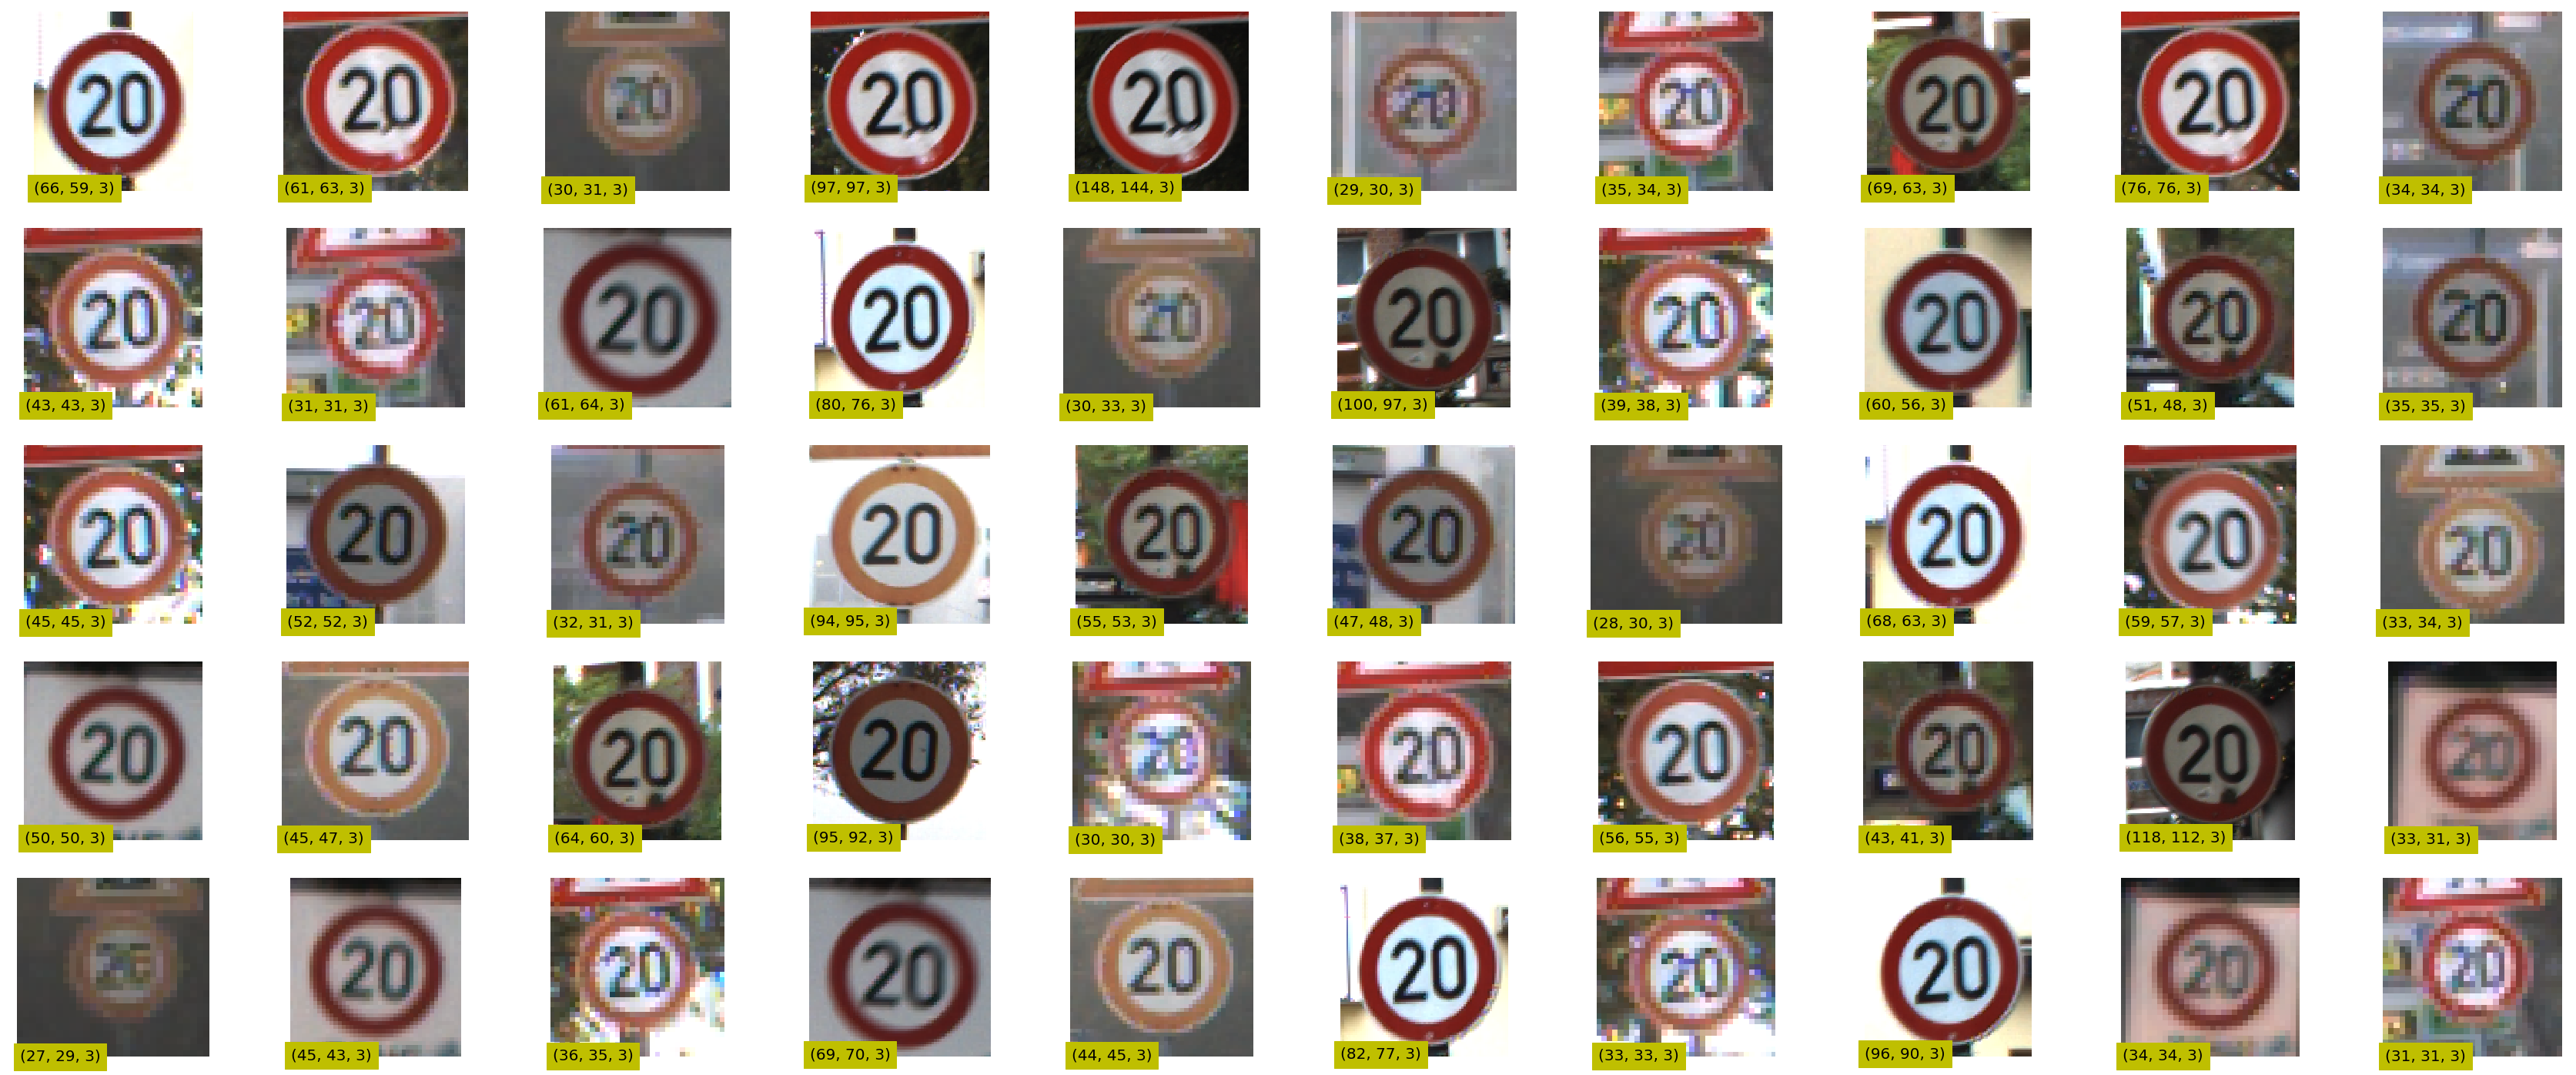

In [16]:
# Load a sample of images of a specific class.
numeric_val_traffic_sign_names = 0                        # Class ID set to 0.
print(TRAFFIC_SIGN_NAMES[numeric_val_traffic_sign_names]) # Will identify the class that will generate sample images.
show_images(get_samples(traffic_sign_train_df, 50, class_id=numeric_val_traffic_sign_names), cols=10, show_shape=True) # Generate 50 random images from Class_ID: 0 (Speed-Limit 20km/h).

## Creating Training & Validation Dataset from Training Dataset

In [17]:
X = traffic_sign_train_df['Filename'].values # X will hold the name of each traffic-sign image.
y = traffic_sign_train_df['ClassId'].values  # y will hold class id of each traffic-sign.
# Training dataset (X_train) is split using 'train_test_split' function. 80% used for training, 20% testing. 
# 80 / 20 Split.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0) 
print("Total Data available within the Training Dataset (100%) - X data: ", len(X)) # Output total images for training.
print("Total Data available as Training (80%) - X_train: ", len(X_train))   # Output quantity of images reserved specifically (80%) for training.
print("Total Data available as Validation (20%) - X_valid: ", len(X_valid)) # Output quantity of images reserved specifically (20%) for validation.

Total Data available within the Training Dataset (100%) - X data:  39209
Total Data available as Training (80%) - X_train:  31209
Total Data available as Validation (20%) - X_valid:  8000


**Code Reference:**

- X variable had been modified to store name of each Traffic-Sign from dataframe 'traffic_sign_train_df'.
- y variable had been modifed to store class id value of each Traffic-Sign from dataframe 'traffic_sign_df'.
- 'base_network' had been created by the author
- Modified to show the the quantity of images available for training and validation.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) Scikit-Learn Documentation (2020) https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## 2 - Model Architecture & Implementation

## Model Architecture

The model is based on the 'LeNet' model which is a predefined convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

- **Source:** Yann.lecun.com. n.d. [online] 
- **Available at:** http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf.



- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

The proposed model is adopted using the Le-Net model however had been modified using the following: 

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Implementing the Model

NeuralNetwork class contains all standard neural network operations, TensorFlow was used to support creating them. 
Different layer methods defined below have been all pre-defined within **network.py** file.

Each model architecture will follow similar structure like the one below. If layers need to be changed, the main purpose of running 'base_network' architecture will be to learn from the training dataset: 'X_train'.

In [18]:
kernel_size = (32, 32, 3) # Defining the image frame size. Each image framed to size 32x32 in RGB (3) channel format.
INPUT_SHAPE = kernel_size # Contains the final image frame size.

# CNN-Architecture for initial network model:
def base_network(input_shape=INPUT_SHAPE): # Image frame (INPUT_SHAPE) is input into network.
    return (NeuralNetwork() #NeuralNetwork class defined within 'network.py' is called upon.
            
            .input(input_shape) 
            .conv([5, 5, 6])  # Convolutional Layer used to create sub-image of original image (input_shape) of size 5x5 also using 6 filters.
            .max_pool()       # Max-pooling layer, method is called upon from 'network.py'.
            .relu()           # Activation function 'ReLU' Rectified Linear Unit, method is called upon from 'network.py'.
            .conv([5, 5, 16]) # Convolutional Layer used to create sub-image of original image (input_shape) of size 5x5 also using 16 filters.
            .max_pool()       # Max-pooling layer, method is called upon from 'network.py'.
            .relu()           # Activation function 'ReLU' Rectified Linear Unit, method is called upon from 'network.py'.
            .flatten()        # Flattening layer method is called upon from 'network.py'.
            .dense(120)       # Dense layer method is called upon from 'network.py'. 120 Neurons passed in as default value.
            .relu()           # Activation function 'ReLU' Rectified Linear Unit, method is called upon from 'network.py'.
            .dense(N_CLASSES)) # Passes the distribution of classes (Traffic-Signs) through DENSE layer, this will return all 43 classes once they are trained.

**Code Reference:**

- 'kernel_size' variable had been added to define image-frame size 
- 'INPUT_SHAPE' variable 
- 'base_network' had been created by the author
- The structural layout (method call) has been modified by author to match Le-Net model architecture however with modifications highlighted above. The order of calling these methods had been changed.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) Harsh Parikh (2018) [https://github.com/hparik11/German-Traffic-Sign-Recognition]
- (3) Junsheng Fu (2017) [https://github.com/JunshengFu/traffic-sign-recognition]

## Implementing the Pipeline

**scikit-learn's pipeline framework** is used to evaluate the performance of each model.  See **pipeline.py** for details.

Once made, a pipeline can be trained and evaluated using the function below:

In [19]:
"""
The 'train_evaluate' method will evaluate the performance of the Convolutional Neural Network model using various metric evaluations
including learning curve and classification report.
Part of this method involves setting the default value for epoch, samples per epoch and setting training and testing 
dataset with their associated values (X_train) (y_train) (X_valid) (y_valid).
"""
def train_evaluate(          # Evaluation function (generate metric measurements to outline accuracy performance.)
    pipeline, epochs=5,      # Default epoch value set to 5 as initial epoch level. This variable will be modified in sub-sequent models to alter iteration.
    samples_per_epoch=50000, # Default value for single epoch, 1 epoch goes through 50,000 images during training.
    train=(X_train, y_train),# Training data is passed through the train parameter of the evaluation function.
    test=(X_valid, y_valid)):# Testing data is passed through the test parameter of the evaluation function.
    X, y = train             # Training dataset reserved for training is split between X and y.
    X_test, y_test = test    # Training dataset that is reserved for testing is passed into 'X_test' 'y_test' variables.
    learning_curve = []      # Will contain accuracy scores to then plot the learning curve evaluation chart.
    data_loss = []           # Will contain the data loss scores to then plot the data loss chart.
    
    print("---------------------- CLASSIFICATION REPORT ----------------------")
    for i in range(epochs):
        indices = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indices], y[indices])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        precision = pipeline.score(*train)
        recall = pipeline.score(*test)
        F1 = 2 * (precision * recall) / (precision + recall)
        #print(scores)
        learning_curve.append([i, *scores])
        print("Epoch: {:>3} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
        print("-------------------------------------------------------------------")
        print("   F1 Score:    {:.3f} ".format (F1))        # Outputs F1-Score in format of 3-significant figures.
        print("-------------------------------------------------------------------")
        print("   Precision:   {:.3f} ".format (precision)) # Outputs Precision score in 3-significant figures.
        print("-------------------------------------------------------------------")
        print("   Recall:      {:.3f} ".format (recall))    # Outputs Recall score in 3-significant figures.
        print("-------------------------------------------------------------------")
    return np.array(learning_curve).T # (epochs, train scores, eval scores)

**Code Reference:**

- The author had modified the 'train_evaluate' method to manually create a classification report during training and evaluation.
- 'learning_curve' variable is added to store the accuracy scores generated from training. This will later be used to create learning curve charts.
- 'data_loss' variable is added to store the data loss scores from the model being trained. This will be used to generate data loss charts.
- Classification Report is manually created by author:
    - 'scores' variable is added that stores the training and testing scores per epoch.
    - 'precision' variable used to store train score per epoch.
    - 'recall' variable used to store the test score per epoch.
    - 'F1' variable holds the F1 score which is (precision * recall) / (precision + recall).
    - learning_curve variable is appended with the scores value. Which will later be used to plot accuracy charts.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) scikit-learn (2020) [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html]

## Baseline Performance

Let's train a network using the first network. This performance is our initial benchmark. All variations of the network will be compared against this initial benchmark which would determine whether improvement has been made.

In [20]:
def resize_image(image, shape=INPUT_SHAPE[:2]): # Method to resize the input image size by kernel size (INPUT_SHAPE) defined above.
    return cv2.resize(image, shape)             # OpenCV library is used to resize the image to desired shape.

loader = lambda image_file: resize_image(load_image(image_file)) # Loader is used to load the image file.

In [34]:
%%time 
with Session() as session: # Calls upon the session class defined within 'session.py'
    functions = [loader]
    pipeline = build_pipeline(functions, session, base_network(), make_adam(1.0e-3)) # Builds the pipeline, here network, current session, Adam Optimiser and Learning rate is defined for training.
    train_evaluate(pipeline) # Pipeline is parsed through train_evaluate method to generate metric evaluations and score accuracy.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.758 Evaluation Score: 0.745
-------------------------------------------------------------------
   F1 Score:    0.751 
-------------------------------------------------------------------
   Precision:   0.758 
-------------------------------------------------------------------
   Recall:      0.745 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.895 Evaluation Score: 0.869
-------------------------------------------------------------------
   F1 Score:    0.882 
-------------------------------------------------------------------
   Precision:   0.895 
-------------------------------------------------------------------
   Recall:      0.869 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.933 Evaluation Score: 0.908
-------------------------------------------------------------------
   F1 Score:    0.92

### Short Analysis:

* EPOCH -> 5

* BATCH SIZE -> 128 (Standard)

* SAMPLE PER EPOCH -> 50,000

Overall our initial assessment of evaluating the network suggests that the model is working as it is able to classify the training data with an peak accuracy of 95.8%. Sometimes this may vary at different run-times I find my results are ranged between 94-97% for Training Score.

From this short demonstration it is somewhat clear their is overfitting. This is likely because the network is exposed to the same images over and over since I'm using 5 epochs (50K samples per epoch). At this moment, it is good to see the network is able to overfit and not showing high biases. The network can handle these images and able to learn from the data.

**Code Reference:**

- 'pipeline' variable had been modified to load base_network, adam optimiser and set learning rate (0.001) for training.
- 'train_evaluate' variable is a method created to parse the pipeline for evaluation. 
- Author had modified 'pipeline.py' file to set batch_size value to 128 by default after having tested out 20.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]

## 3 - Image Preprocessing

### Image Augmentation

As highlighted in **'Exploratory Data Analysis within Section 1'** the Traffic-Sign dataset across all categories: Training and Testing are greatly skewed, augmentation methods is used to tackle this problem. Below rather than to increase the epochs or samples per epoch at this stage, I decided to address this otherwise the network will overfit the training dataset. 
Image augmentation will increase the number of images encouraging a more equal distribution of images, whether they improve network performance is what we are trying to find out?

In [21]:
def random_brightness(image, ratio):
    """
    Method that adjust brightness of the image randomly.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) 
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def random_translation(image, translation):
    """
    Method that moves the image randomly.
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def random_rotation(image, angle):
    """
    Method that rotates the image randomly.
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def random_shear(image, shear):
    """
    Method that distorts by adding shear to the image randomly.
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = random_brightness(image, brightness)
    image = random_rotation(image, angle)
    image = random_translation(image, translation)
    image = random_shear(image, shear)
    return image

**Code Reference:**

- No modifications have been made by the author. All the augmentation settings and method have been provided by external sources.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya]
- (2) Jason Brownless - Machine Learning Mastery (2019) [https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/]

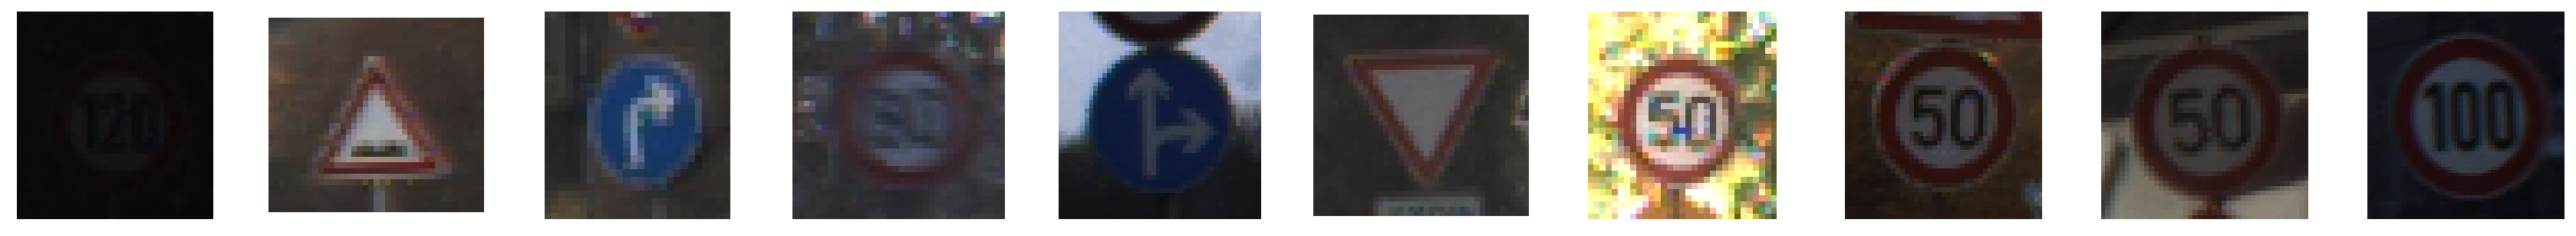

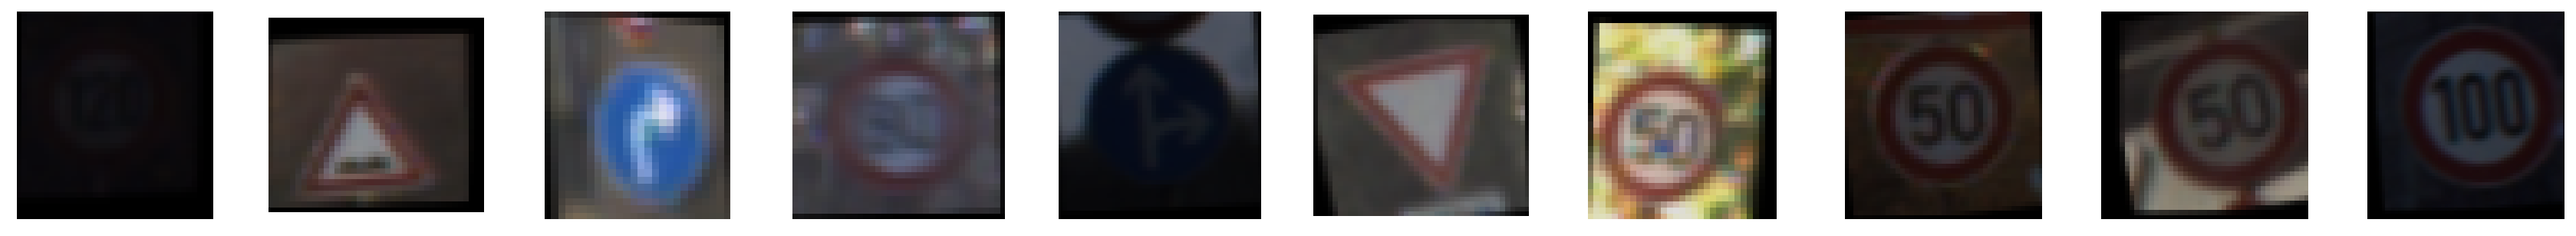

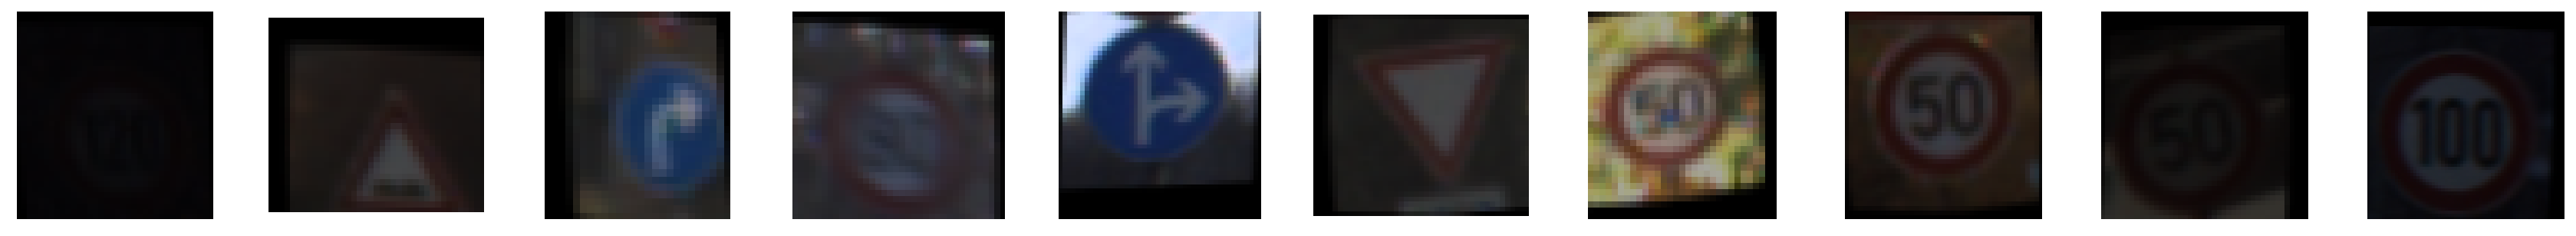

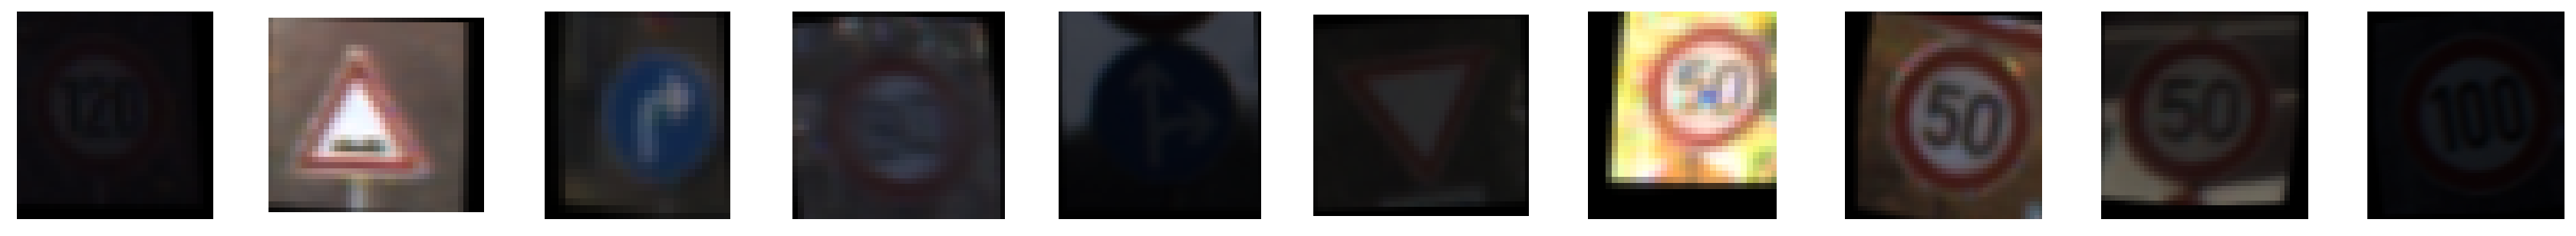

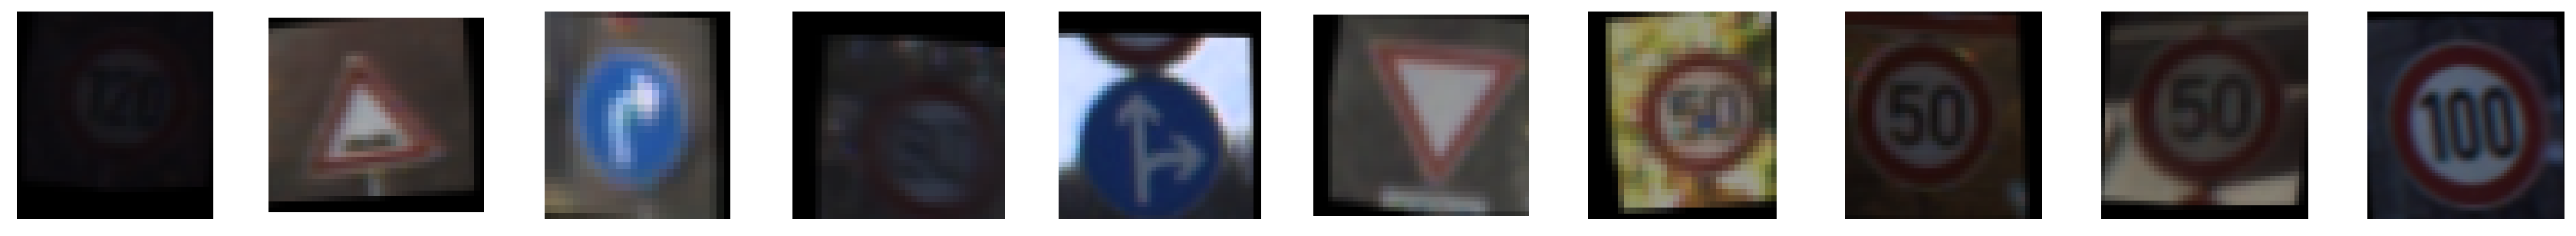

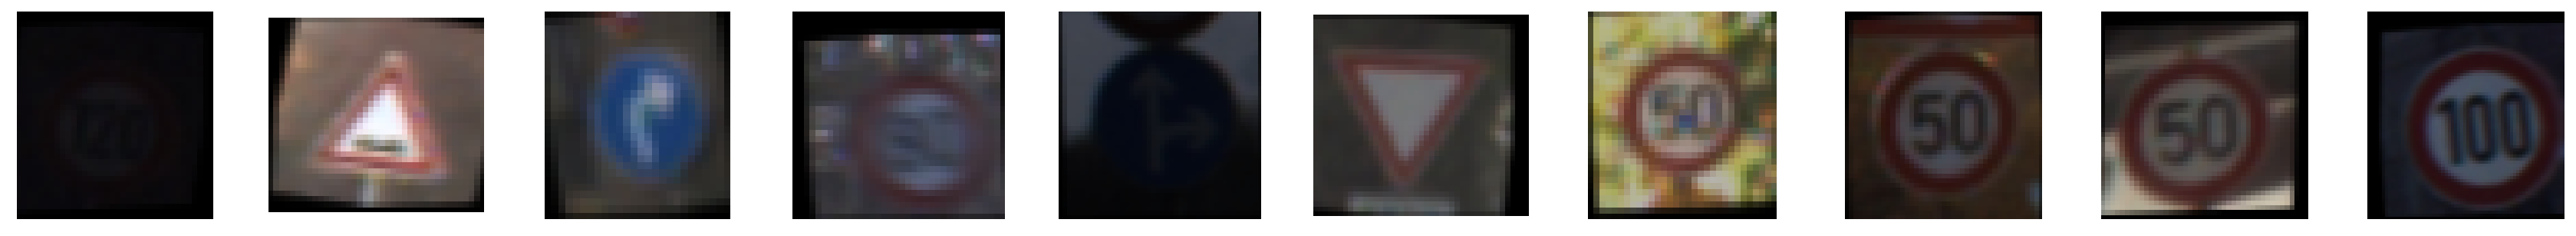

In [22]:
# Augmenter tahat loads all the images with all image-augmentations applied.
# Image Augmentation Methods: Brightness, Rotation Angle, Translation and Image Shear.
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2) # Random augmentation values had been set. These can be altered.

show_images(sample_data[10:], cols=10) # show_images function defined earlier used to load the images in columns of 10.
for _ in range(5):
    show_images(sample_data[10:], cols=10, func=augmenter) # Loads the augmented images in iterations of 5.

In [25]:
%%time
with Session() as session:
    functions = [loader, augmenter] # Loads all the images using loader as well as augmentated images.
    pipeline = build_pipeline(functions, session, base_network(), make_adam(1.0e-3)) # Builds the pipeline, here network, current session, Adam Optimiser and Learning rate is defined for training.
    train_evaluate(pipeline) # Evaluates the augmented images using the base_network pipeline.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.166 Evaluation Score: 0.162
-------------------------------------------------------------------
   F1 Score:    0.166 
-------------------------------------------------------------------
   Precision:   0.166 
-------------------------------------------------------------------
   Recall:      0.166 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.296 Evaluation Score: 0.295
-------------------------------------------------------------------
   F1 Score:    0.291 
-------------------------------------------------------------------
   Precision:   0.295 
-------------------------------------------------------------------
   Recall:      0.288 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.399 Evaluation Score: 0.400
-------------------------------------------------------------------
   F1 Score:    0.39

#### Short Analysis:

* EPOCH -> 5

* BATCH SIZE -> 128 (Standard)

With the augmented images parsed through the initial network architecture pipeline it is clear that training accuracy has not improved and performed worst. This may have occured due to the following:

- Network not robust (rather than to generalize the model is memorising).
- Greater number of epochs required for training. As more time is required for training.

The hyper-perameters like brightness, rotation, translation, shear parameters are manually tuned by looking at the randomly altered images. If the alteration is too far-fetched, it would not be as realistic. The same way that horizontal-flip was not included, alterations such as 90 degree rotation should not be applied.

Below I will test out other image preprocessing techniques with the purpose of improving network performance. Specifically Normalisation and manipulating Color channels is what I aim test to see whether learning from the dataset is made easir. EPOCH count will be increased to larger values to ensure performance testing is effective.

### Image Normalisation

The below will test various normalization technique to see which one has the best performance.

In [24]:
%%time
normalizers = [('x - 127.5',              lambda x: x - 127.5),     # Normalisation technique transcribed from Normalisation - Google Developers.
               ('x/127.5 - 1.0',          lambda x: x/127.5 - 1.0), # Normalisation technique transcribed from Normalisation - Google Developers.
               ('x/255.0 - 0.5',          lambda x: x/255.0 - 0.5), # Normalisation technique transcribed from Normalisation - Google Developers.
               ('x - x.mean()',           lambda x: x - x.mean()),  # Normalisation technique transcribed from Normalisation - Google Developers.
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())] # Normalisation technique transcribed from Normalisation - Google Developers.
               
for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:                      # Loads session class from 'session.py'.
        functions = [loader, augmenter, normalizer] # Loads all the images using loader, normaliser settings.
        pipeline = build_pipeline(functions, session, base_network(), make_adam(1.0e-3)) # Builds the pipeline, here network, current session, Adam Optimiser and Learning rate is defined for training.
        train_evaluate(pipeline) # Evaluates the pipeline using different metric evaluates and generates classification report.
    print()

Normalizer: x - 127.5
---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.135 Evaluation Score: 0.129
-------------------------------------------------------------------
   F1 Score:    0.131 
-------------------------------------------------------------------
   Precision:   0.131 
-------------------------------------------------------------------
   Recall:      0.132 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.292 Evaluation Score: 0.293
-------------------------------------------------------------------
   F1 Score:    0.293 
-------------------------------------------------------------------
   Precision:   0.292 
-------------------------------------------------------------------
   Recall:      0.294 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.415 Evaluation Score: 0.416
------------------------------------------------------------------

#### Short Analysis:

Model training derives better accuracy with normalisation than without so this point forward normalisation will be used. This also clearly highlights the importance of applying normalisation. In this experiment, the normalization with (x-x.mean())/x.std() produced the best performance. Important to remember at different run-times the accuracy score could vary hence its best to run at least 2/3 times. So, it is not easy to say which one is better than what.

In [32]:
normalizer = lambda x: (x - x.mean())/x.std() # Sets the final normaliser setting to (x-x.mean())/x.std() as it derived best score.

**Code Reference:**

- 'normalizer' variable created that contains an array of different normalisation techniques.

The inspiration behind implementing this code was taken from:
- (1) Normalisation - Google Developer (2020) [https://developers.google.com/machine-learning/data-prep/transform/normalization]
- (2) Implementation method for Normalisation comes from Naioki Shibuya (2017) [https://github.com/naokishibuya]

### Image Color Channel Alteration

Filtering image features using different colour channels had been tested to see whether model learning improves this, in turn, would then help improve classification accuracy.

Note: Grey-scale has only one channel where as RGB and all other channels utilise 3 or more.

In [33]:
%%time

converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]), # Color channel for Gray (grey-scale).
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)), # Color channel for HSV.
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)), # Color channel for HLS.
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)), # Color channel for Lab.
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)), # Color channel for Luv.
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)), # Color channel for XYZ.
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)), # Color channel for Yrb.
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))] # Color channel for YUV.

GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1) # For this channel, I added the 3rd dimension back (1 channel) as it's expected by the network.

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]   # Function that loads the normalisation settings, augmentation setting (none), converter setting (colour channel used RGB)
        if name == 'Gray':                                       # Validation that checks to see if colour channel is grey if so then network setting will be applied...
            network = base_network(input_shape=GRAY_INPUT_SHAPE) # There is only 1 channel for grey-scale (Black / White).
        else:                                                    # If colour channel is not grey then perform this...
            network = base_network()                             # Calls the initial network.
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3)) # Pipeline is built with adam optimiser, current network (base_network), learning rate(0.001).
        train_evaluate(pipeline)                                 # Model pipeline is evaluated.
    print()

Color Space: Gray
---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.544 Evaluation Score: 0.550
-------------------------------------------------------------------
   F1 Score:    0.548 
-------------------------------------------------------------------
   Precision:   0.545 
-------------------------------------------------------------------
   Recall:      0.552 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.665 Evaluation Score: 0.659
-------------------------------------------------------------------
   F1 Score:    0.659 
-------------------------------------------------------------------
   Precision:   0.662 
-------------------------------------------------------------------
   Recall:      0.657 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.729 Evaluation Score: 0.727
-------------------------------------------------------------------
  

#### Short Summary

From the test highlighted above it is clear that neither color channels derived a better accuracy than the initial benchmark for which color channel was set as default (RGB). Expectation here was Grey-Scale color space would output a higher accuracy however maximum Train Score (89%) in comparison to Train Score for default RGB (95%).
Furthermore with Grey Scale color channel the dimensionality of channels would be reduced from 3 color to 1 which in turn would make learning faster and easy. However this was not the case.

For the time being I will set out to keep utilising the existing RGB color space.

In [25]:
preprocessors = [loader, augmenter, normalizer] # Preprocessor function is set with RGB colour setting also no augmentation from previous process.

**Code Reference:**

- 'converter' variable is modified to set order for different color channels.
- 'preprocessors' variable is set with RGB colour channel with no augmentation.

The inspiration behind implementing this code was taken from:
- (1) Wikipedia Colour Channel (2020) [https://en.wikipedia.org/wiki/Channel_(digital_image)]
- (2) Colour channel modification comes from Naioki Shibuya (2017) [https://github.com/naokishibuya]

## 5 - IMPROVING CONVOLUTIONAL NEURAL-NETWORK MODEL

The objective here is I want to improve the performance of the Neural Network model but it is important to keep in mind I want to also prevent over-fitting from occuring.

1. Increasing the number of filters within convolutional layers.

2. Increasing the number of neurons within dense layers.

3. Increasing the number of convolutional layers.

4. Increasing the number of dense layers.

5. Utilising an alternative activation function such as: ELU oppose to RELU.

6. Manipulating the Dropout Rate.

### Graph Analysis: Learning Curve & Confusion Matrix Methods Implementation

#### Method: Method to create Confusion Matrix

In [29]:
def create_confusion_matrix(cm): # Method created to create a confusion matrix after training model.
    cm = [row/sum(row)   for row in cm]       # For each row of the matrix.
    fig = plt.figure(figsize=(10, 10))        # Size of the matrix bars are set.
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges) # Sets the hue of the bar to an orange colour. 
    fig.colorbar(cax)                         # Sets the bar colour value.
    plt.title('Confusion Matrix')     # Plots the chart title.
    plt.xlabel('Predicted Class IDs') # Plots the Class IDs on x-axis of chart.
    plt.ylabel('True Class IDs')      # Plots the Class IDs predicted correctly on y-label of chart.
    plt.show()                        # Outputs chart.
    
def output_confusion_matrix(cm, sign_names=TRAFFIC_SIGN_NAMES): # Method to output confusion matrix based on the Traffic Sign Image Names.
    results = [(i, TRAFFIC_SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)] 
    accuracies = []                                             # Accuracy of results is appended to this variable for later use.
    for result in sorted(results, key=lambda x: -x[2]):         # For each result derived from the chart format it to highest score to lowest.
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])                            # Append the scores within accuracies array.
    print('-'*50)         
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies))) # Print the mean accuracy from all classified classes (43).

**Code Reference:**

- 'create_confusion_matrix' function created that defines the architecture of the matrix.
- 'output_confusion_matrix' function had been modified to generate matrix based on the dataset frame I created earlier.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (Chart plot settings are all derived from this source).
- (2) Jason Brownlee - Machine Learning Mastery (2019 [https://machinelearningmastery.com/confusion-matrix-machine-learning/]

#### Method: Method to create Learning Curve

In [30]:
def create_learning_curve(learning_curve):      # Method to create learning learning curve.
    epochs, train, valid = learning_curve       # Plots the learning curve utilising the scores assigned to learning_curve variable earlier on.
    plt.figure(figsize=(10, 10))                # Size of chart defined.
    plt.plot(epochs, train, label='Train')      # Plots the Training Scores
    plt.plot(epochs, valid, label='Validation') # Plots the Validation Scores.
    plt.title('Learning Curve')                 # Title of chart.
    plt.ylabel('Accuracy')                      # Labels y-axis as Accuracy Score.
    plt.xlabel('Epochs')                        # Labels x-acis as Epochs level.
    plt.xticks(epochs)                          # Labelling Epochs.
    plt.legend(loc='center right')              # Creates a chart legend.

**Code Reference:**

- 'create_learning_curve' function had been modified to match my settings for current model, epoch value and scores generated from training.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (Chart plot settings are all derived from this source).
- (2) Jason Brownlee - Machine Learning Mastery (2019 [https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/]

## Network Improvements

Below will comprise of several network models which again will be compared with the initial benchmark above. Beneath each network result I will give a brief summary of the performance on the Traffic-Sign Train set.

### Network 1.2

**Change**: Inceasing the number of filters within the Convolutional Layers (x2) and Neurons within Dense layers(x2).

Running session ...
---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.673 Evaluation Score: 0.667
-------------------------------------------------------------------
   F1 Score:    0.674 
-------------------------------------------------------------------
   Precision:   0.676 
-------------------------------------------------------------------
   Recall:      0.671 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.826 Evaluation Score: 0.820
-------------------------------------------------------------------
   F1 Score:    0.823 
-------------------------------------------------------------------
   Precision:   0.828 
-------------------------------------------------------------------
   Recall:      0.818 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.880 Evaluation Score: 0.872
-------------------------------------------------------------------


W0420 15:49:13.264345 140392935114560 deprecation_wrapper.py:119] From /notebooks/pipeline/session.py:37: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



Epoch:   4 Train Score: 0.927 Evaluation Score: 0.925
-------------------------------------------------------------------
   F1 Score:    0.922 
-------------------------------------------------------------------
   Precision:   0.927 
-------------------------------------------------------------------
   Recall:      0.918 
-------------------------------------------------------------------
CPU times: user 5min 3s, sys: 24.7 s, total: 5min 27s
Wall time: 5min 24s


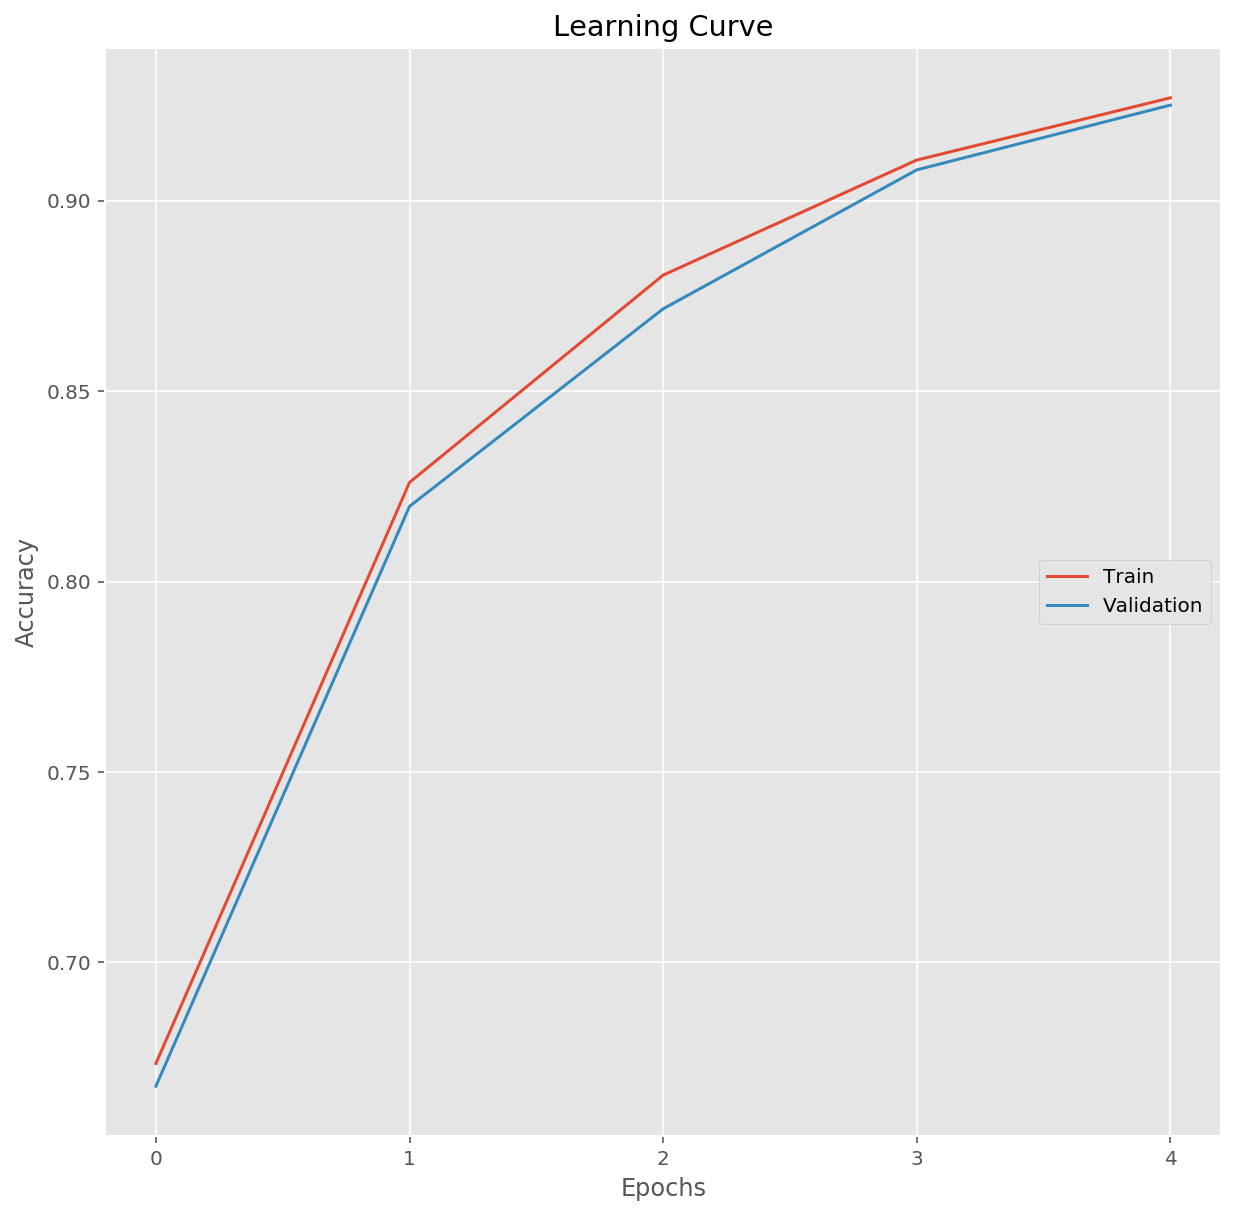

In [35]:
%%time
print("Running session ...") # Initial Network Architecture requires 5 mins to train based on the cloud-GPU I am using.
def base_network1_2(input_shape=INPUT_SHAPE): # New network architecture takes in new image size (data-frame)
    return (NeuralNetwork() # Neural Network class encapsulates all the methods for different layers of CNN in 'network.py'
            .input(input_shape)
            .conv([5, 5, 12])  # <== x2 (Doubling Layers)
            .max_pool()     # Calls upon max_pool method (adds max pooling layer) from 'network.py' file.
            .relu()         # Calls upon relu method (adds relu activation layer) from 'network.py' file.
            .conv([5, 5, 32])  # <== x2 (Doubling Layers)
            .max_pool()     # Calls upon max_pool method (adds max pooling layer) from 'network.py' file.
            .relu()         # Calls upon relu method (adds relu activation layer) from 'network.py' file.
            .flatten()      # Calls upon max_pool method (adds max pooling layer) from 'network.py' file.
            .dense(240) # <== x2 (Doubling Dense Value)
            .relu()         # Calls upon max_pool method (adds max pooling layer) from 'network.py' file.
            .dense(N_CLASSES)) # Passes the distribution of classes (Traffic-Signs) through DENSE layer, this will return all 43 classes once they are trained.

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network1_2(), make_adam(1.0e-3)) # Learning Rate = 0.001
    learning_curve = train_evaluate(pipeline)       # Evaluates the and produces metric evaluations for the pipeline model.
    session.save('Checkpoint/base_network1_2.ckpt') # Creates a model index within Checkpoint folder and saves model parameter settings.
    
create_learning_curve(learning_curve) # Creates learning curve using the accuracy scores derived from model trained.

Running session ...


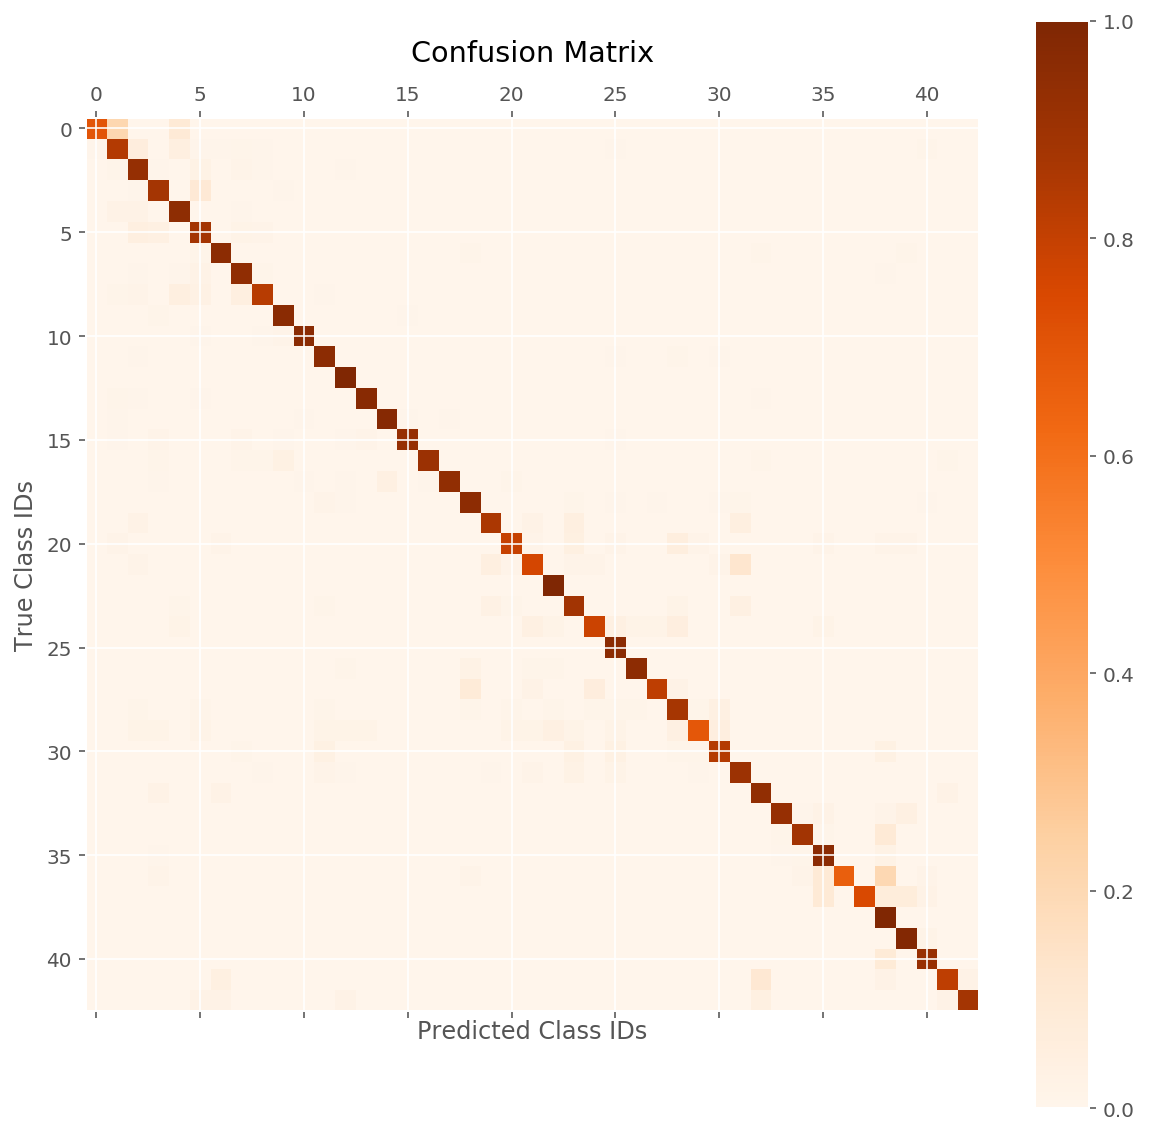

22 Bumpy road                                         100.00%  310
12 Priority road                                       99.53% 1672
38 Keep right                                          99.53% 1648
39 Keep left                                           98.36%  239
14 Stop                                                97.48%  621
13 Yield                                               96.60% 1719
 9 No passing                                          96.33% 1170
10 No passing for vehicles over 3.5 metric tons        96.10% 1600
25 Road work                                           96.08% 1194
35 Ahead only                                          95.92%  955
11 Right-of-way at the next intersection               95.54% 1051
 6 End of speed limit (80km/h)                         95.35%  334
18 General caution                                     95.10%  955
26 Traffic signals                                     95.08%  478
 4 Speed limit (70km/h)                                94.55% 

In [39]:
%%time
print("Running session ...")
with Session() as session: # Used to load the Model Checkpoint / Saved Index using 'Session' class defined within 'session.py'.
    pipeline = build_pipeline(preprocessors, session, base_network1_2()) 
    session.load('Checkpoint/base_network1_2.ckpt') # Loads the model index / parameters stored from Checkpoint folder.
    prediction_pipeline = pipeline.predict(X_valid) # Trains the model against validation data (derived from training set).
    
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline) # Plots the predictions for each class in confusion matrix.
cm = plotting_y_valid_pred
create_confusion_matrix(cm) # Calls upon create_confusion_matrix() method defined above.
output_confusion_matrix(cm) # Calls upon output_confusion_marix() method defined above.

#### Short Summary

Training the model resulted in training accuracy 92.7% in comparison to baseline performance 94.9% performance did not improve. Although training accuracy is slightly higher than the validation accuracy. This highlights that overfitting has occured but complexity of the network need to be increased either through EPOCH increase or changing other parameters.

Suggested next step would be to increase complexity of the network by increasing filters and neurons by 4x.

The result of confusion matrix's mean accuracy is the sum of the mean accuracy for each class divided by the number of class. It is lower than overall accuracy indicating the larger classes are performing better (or the smaller classes are performing worse).

**Code Reference:**

- base_network1_2() method defines the network model architecture.
    - Filters and neuron values have been modifed by author.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network 1.3

**Change**: Inceasing the number of filters within the Convolutional Layers (x4) and Neurons within Dense layers(x4) further doubling than previous network model.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.771 Evaluation Score: 0.764
-------------------------------------------------------------------
   F1 Score:    0.766 
-------------------------------------------------------------------
   Precision:   0.770 
-------------------------------------------------------------------
   Recall:      0.762 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.893 Evaluation Score: 0.883
-------------------------------------------------------------------
   F1 Score:    0.890 
-------------------------------------------------------------------
   Precision:   0.892 
-------------------------------------------------------------------
   Recall:      0.889 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.929 Evaluation Score: 0.923
-------------------------------------------------------------------
   F1 Score:    0.92

W0422 00:41:27.449981 140495859029824 deprecation_wrapper.py:119] From /notebooks/pipeline/session.py:37: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



Epoch:   4 Train Score: 0.961 Evaluation Score: 0.958
-------------------------------------------------------------------
   F1 Score:    0.960 
-------------------------------------------------------------------
   Precision:   0.961 
-------------------------------------------------------------------
   Recall:      0.959 
-------------------------------------------------------------------
CPU times: user 3min 59s, sys: 21 s, total: 4min 20s
Wall time: 4min 19s


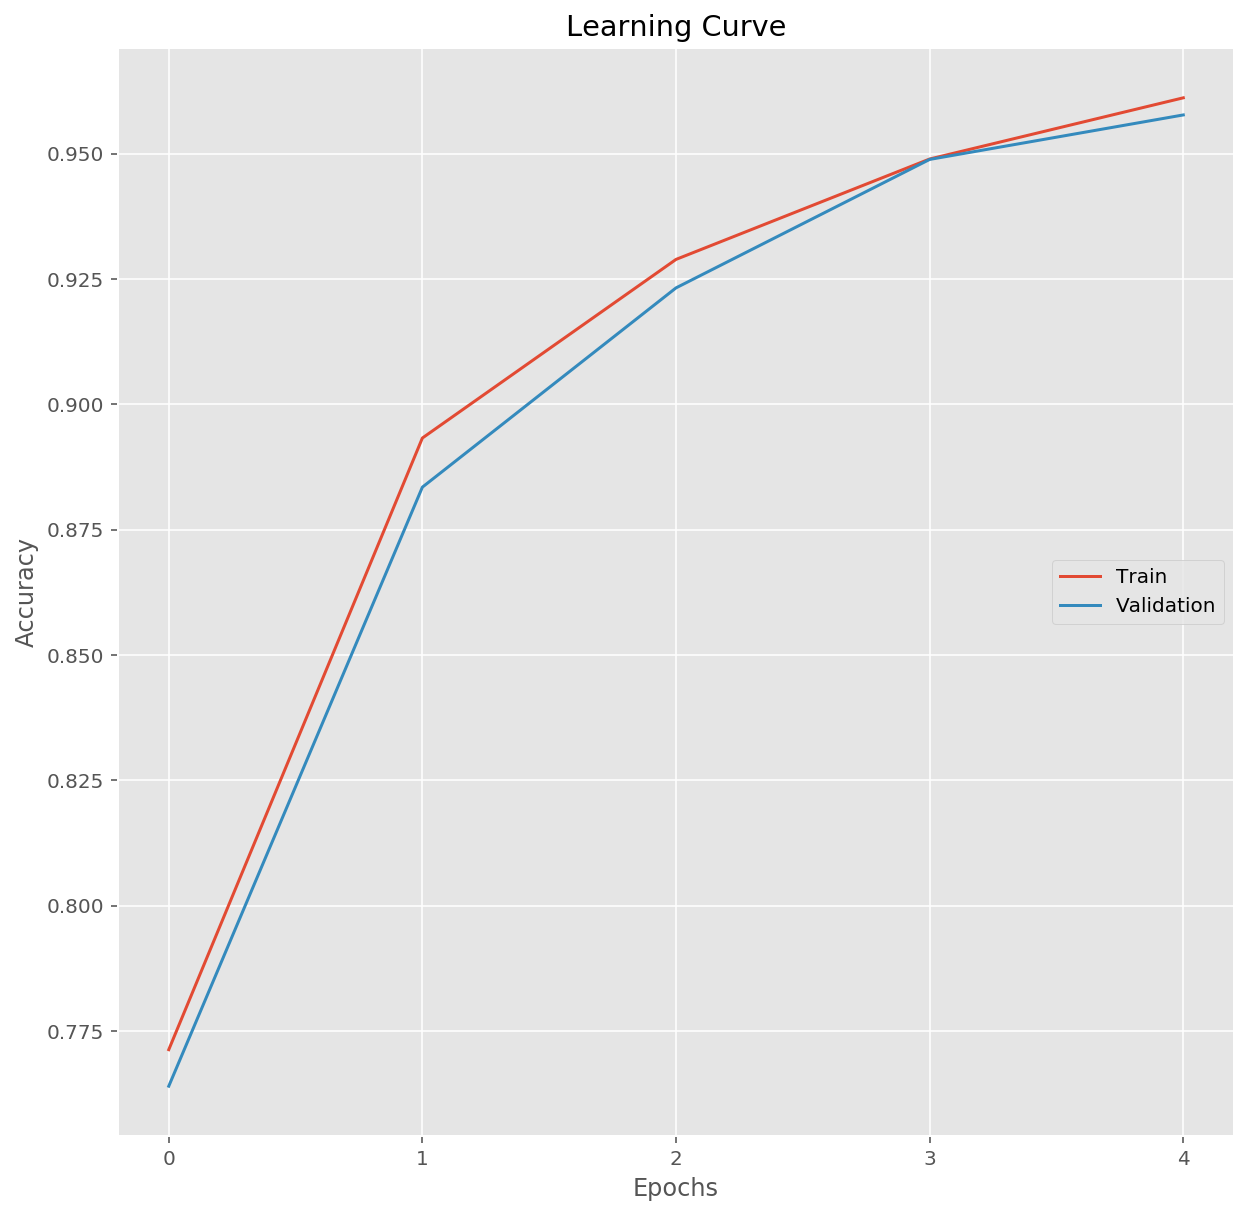

In [33]:
%%time
def base_network_1_3(input_shape=INPUT_SHAPE): # Method that describes model architecture for Network 1.3
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # Increasing the number of filters x4
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # Increasing the number of filters x4
            .max_pool()
            .relu()
            .flatten()
            .dense(480)       # Increasing the number of neurons x4
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(1.0e-3)) # Learning Rate = 0.001
    learning_curve = train_evaluate(pipeline)
    session.save('Checkpoint/base_network_1_3.ckpt') # Saves the trained model as index / checkpoint using session() method.
    
create_learning_curve(learning_curve)

W0413 13:46:53.510297 139847143122752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


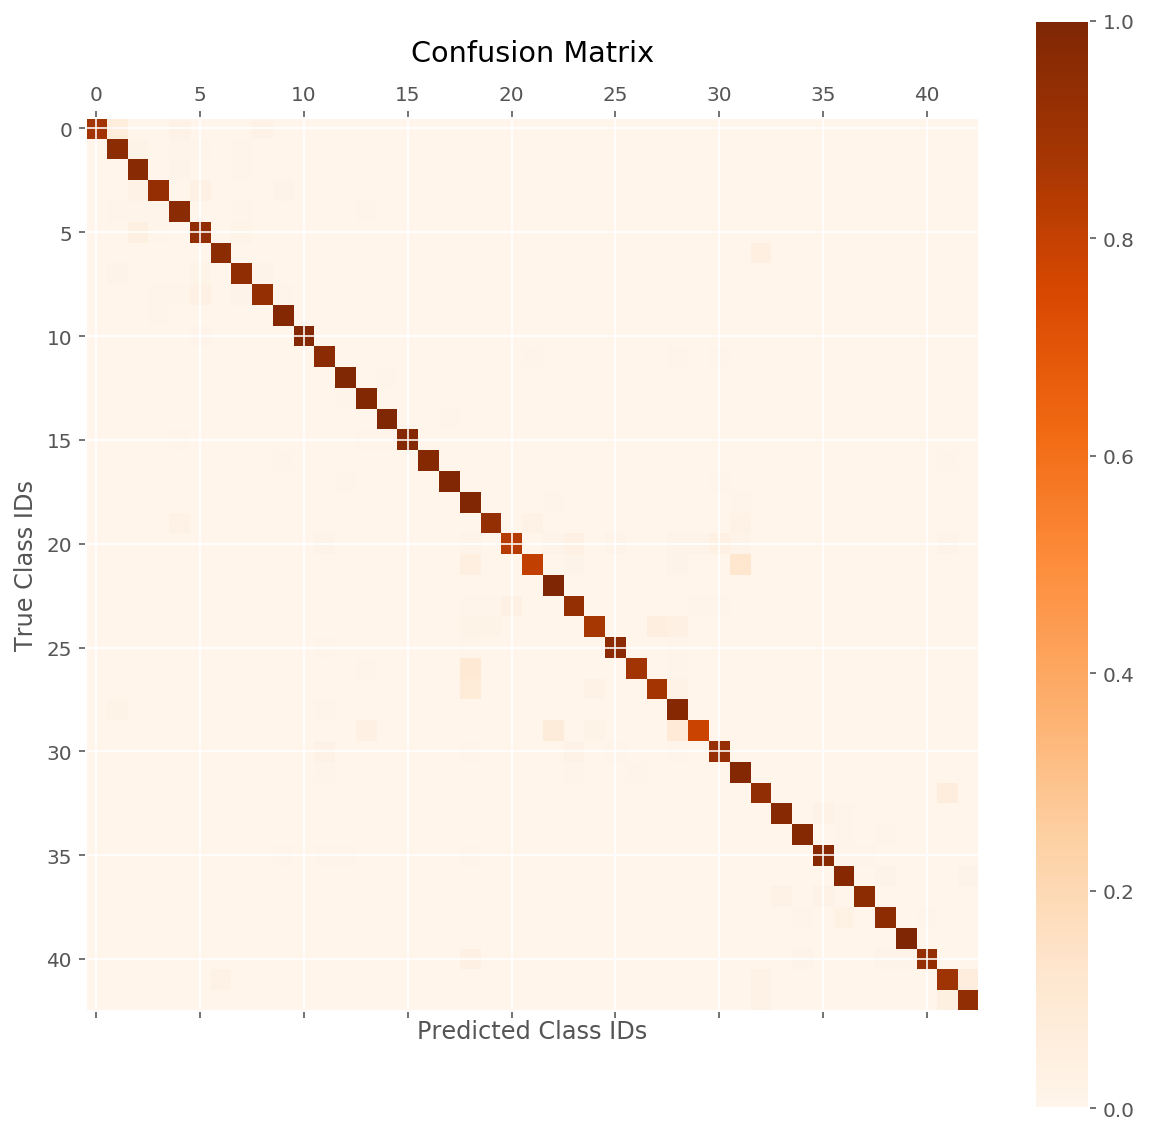

22 Bumpy road                                         100.00%  310
39 Keep left                                          100.00%  239
12 Priority road                                       99.53% 1672
14 Stop                                                99.37%  621
18 General caution                                     99.18%  955
17 No entry                                            99.12%  884
13 Yield                                               98.64% 1719
10 No passing for vehicles over 3.5 metric tons        98.54% 1600
 9 No passing                                          98.33% 1170
31 Wild animals crossing                               98.11%  621
15 No vehicles                                         97.67%  501
16 Vehicles over 3.5 metric tons prohibited            97.67%  334
34 Turn left ahead                                     97.67%  334
35 Ahead only                                          97.55%  955
36 Go straight or right                                97.50% 

In [37]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary

The results above highlight the performance has improved with changes mentioned above. The training accuracy is slightly higher than the validation accuracy. This maybe a sign of overfitting but I will need to see by increasing the complexity of the network. Instead of applying regularisation at this stage, I will opt to increase the number of epochs to see how far it can improve.

For almost all classes, the network is producing better than 90% accuracy, proving that increasing the network complexity is making it more robust.

**Code Reference:**

- base_network1_3() method defines the network model architecture.
    - Filters and neuron values have been modifed by author.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network 1.3.2 -> Increasing Number of EPOCHS

**Change**: Inceasing the number of filters within the Convolutional Layers (x4) and Neurons within Dense layers(x4) further doubling than previous network model. Further to this model the number of EPOCH's will be set to 30.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.770 Evaluation Score: 0.772
-------------------------------------------------------------------
   F1 Score:    0.771 
-------------------------------------------------------------------
   Precision:   0.772 
-------------------------------------------------------------------
   Recall:      0.769 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.896 Evaluation Score: 0.893
-------------------------------------------------------------------
   F1 Score:    0.893 
-------------------------------------------------------------------
   Precision:   0.896 
-------------------------------------------------------------------
   Recall:      0.889 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.938 Evaluation Score: 0.931
-------------------------------------------------------------------
   F1 Score:    0.93

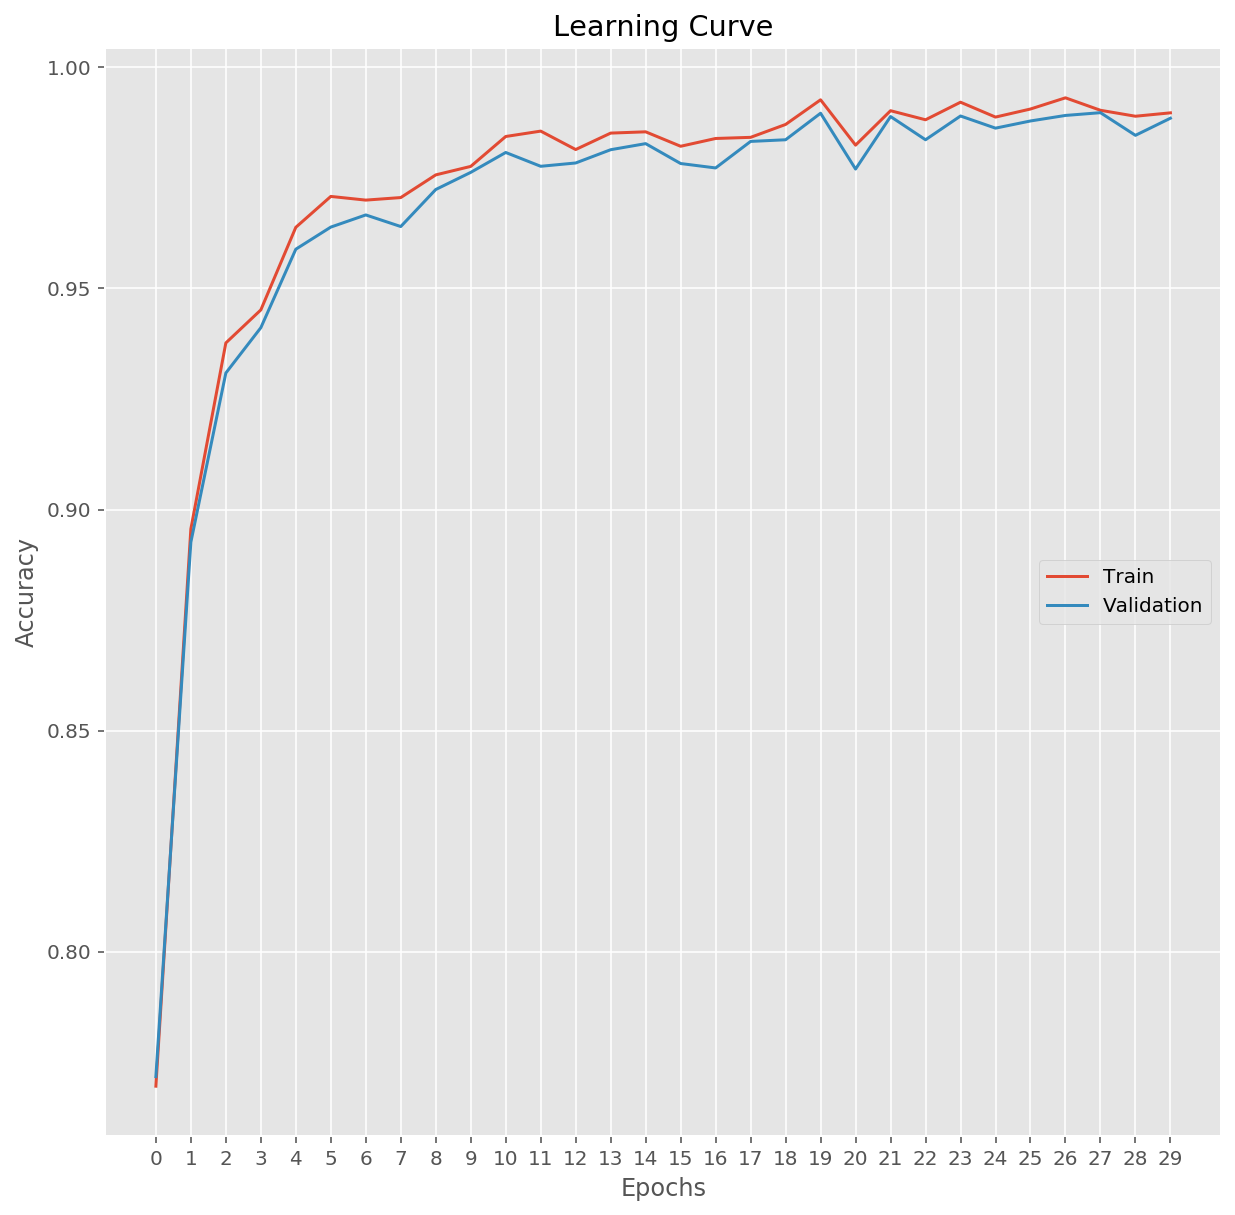

In [41]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(1.0e-3)) # Learning Rate = 0.001
    learning_curve = train_evaluate(pipeline, epochs=30) # Increasing Epoch hyperparameter to 30.
    session.save('Checkpoint/base_network_1_3_epoch-30.ckpt') # Saves model as checkpoint / index for future reference.
    
create_learning_curve(learning_curve) # Creates learning curve from saved accuracy scores.

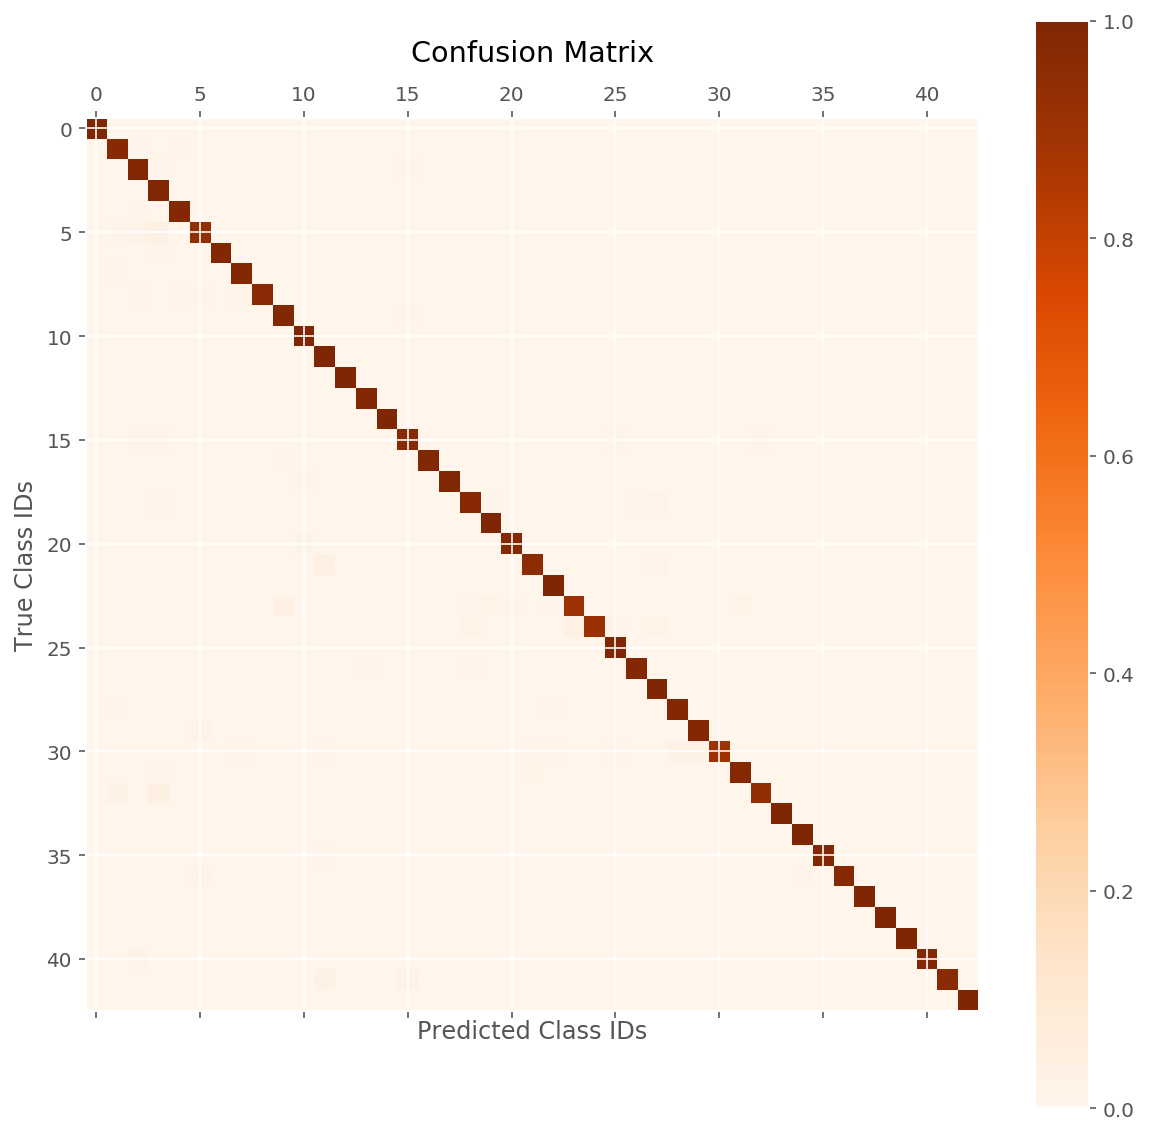

 0 Speed limit (20km/h)                               100.00%  167
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
11 Right-of-way at the next intersection              100.00% 1051
14 Stop                                               100.00%  621
19 Dangerous curve to the left                        100.00%  167
22 Bumpy road                                         100.00%  310
27 Pedestrians                                        100.00%  191
33 Turn right ahead                                   100.00%  548
34 Turn left ahead                                    100.00%  334
37 Go straight or left                                100.00%  167
38 Keep right                                         100.00% 1648
39 Keep left                                          100.00%  239
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
12 Priority road                                       99.77% 1672
25 Road work                                           99.67% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3_epoch-30.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary

Overall the performance of this model showed improvement - however latter stages of the EPOCH showed that training and evaluation accuracy was slowly diminishing.

For several classes for this model we can see that accuracy of classes have resulted to closer to 100% percentile which highlights that this model is highly suited to classification 43 traffic-sign classes. Also, the bottom performer is improving as well.

**Code Reference:**

- base_network_1_3_epoch-30 method defines the network model architecture. (Using same architecture as Network 1.3) but changing parameter values.
    - Epoch level had increased to 30 to extend the model training time.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network 1.3.3 -> Increasing Number of EPOCHS but with Lower Learning Rate

**Change**: As well as EPOCH's having been increased to **30**. The learning rate will be reduced to **0.0005**.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.672 Evaluation Score: 0.679
-------------------------------------------------------------------
   F1 Score:    0.676 
-------------------------------------------------------------------
   Precision:   0.679 
-------------------------------------------------------------------
   Recall:      0.673 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.827 Evaluation Score: 0.820
-------------------------------------------------------------------
   F1 Score:    0.820 
-------------------------------------------------------------------
   Precision:   0.823 
-------------------------------------------------------------------
   Recall:      0.817 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.883 Evaluation Score: 0.869
-------------------------------------------------------------------
   F1 Score:    0.87

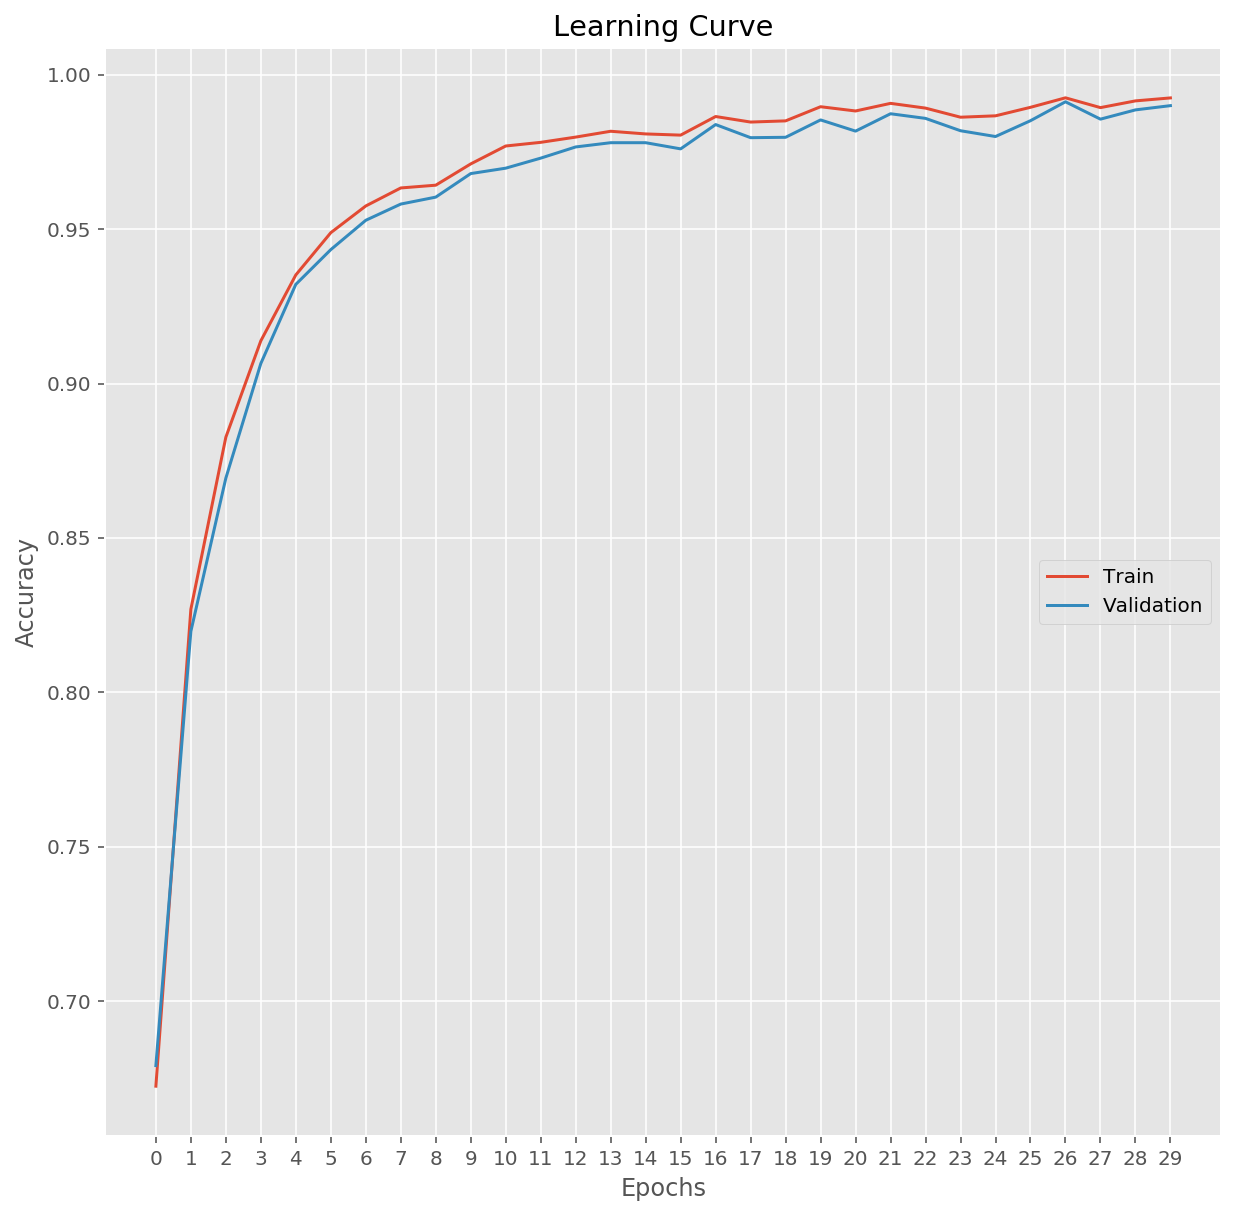

In [34]:
new_learning_rate = 0.5e-3 # Lower Learning Rate - 0.0005
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(new_learning_rate))
    learning_curve = train_evaluate(pipeline, epochs=30)
    session.save('Checkpoint/base_network_1_3_epoch-30-lr-0.0005.ckpt')
    
create_learning_curve(learning_curve)

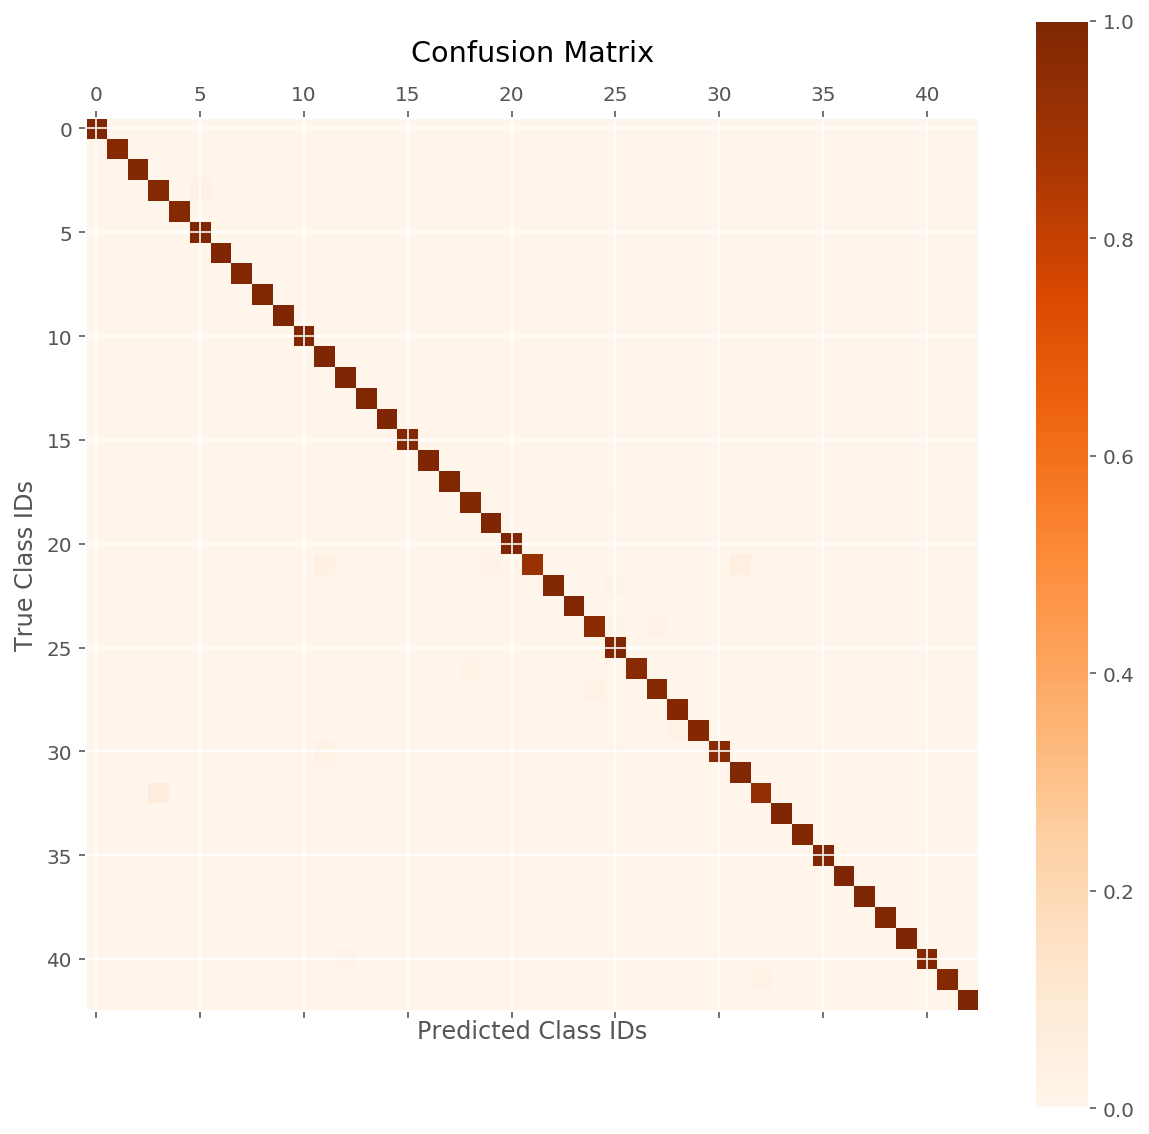

 0 Speed limit (20km/h)                               100.00%  167
 6 End of speed limit (80km/h)                        100.00%  334
14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
20 Dangerous curve to the right                       100.00%  287
33 Turn right ahead                                   100.00%  548
35 Ahead only                                         100.00%  955
36 Go straight or right                               100.00%  310
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
12 Priority road                                       99.77% 1672
 5 Speed limit (80km/h)                                99.74% 1481
25 Road work                                           99.67% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3_epoch-30-lr-0.0005.ckpt')  # Lower Learning Rate - 0.0005
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

Overall the performance of the network has slightly improved. The learning curve looks much smoother. The average accuracy per class is also better. Overall the decision to reduce the learning rate whilst increasing epoch has proved to be a success.

**Code Reference:**

- base_network_1_3_epoch-30-lr-0.0005 method defines the network model architecture. (Using same architecture as Network 1.3) but changing parameter values.
    - Reducing learning rate to 0.0005 (new_learning_rate) variable had been added.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network 1.3.4 -> Increasing Number of EPOCHS but with Further Learning Rate Lowered

**Change**: The change made for test is from previous model the EPOCH size again will remained increased by 30, however this time round the learning rate will be reduced further to 1.0e-4 / 0.00010.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.387 Evaluation Score: 0.385
-------------------------------------------------------------------
   F1 Score:    0.384 
-------------------------------------------------------------------
   Precision:   0.387 
-------------------------------------------------------------------
   Recall:      0.380 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.556 Evaluation Score: 0.555
-------------------------------------------------------------------
   F1 Score:    0.560 
-------------------------------------------------------------------
   Precision:   0.555 
-------------------------------------------------------------------
   Recall:      0.565 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.644 Evaluation Score: 0.643
-------------------------------------------------------------------
   F1 Score:    0.64

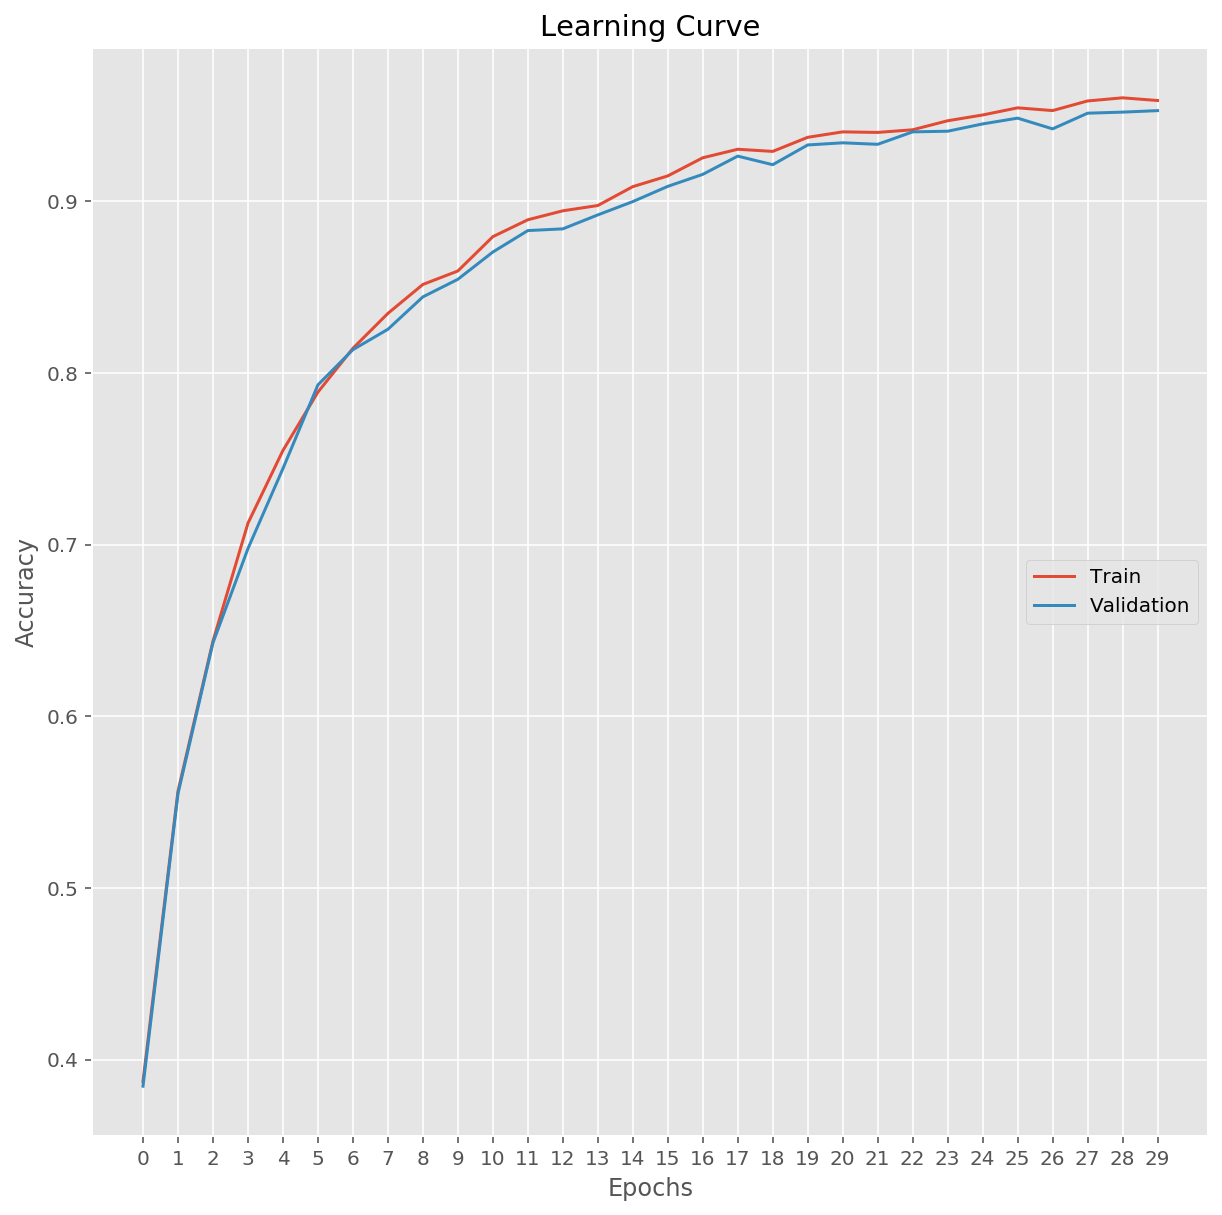

In [35]:
%%time
new_learning_rate = 1.0e-4 # Lower Learning Rate - 0.00010
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(new_learning_rate))
    learning_curve = train_evaluate(pipeline, epochs=30)
    session.save('Checkpoint/base_network_1_3_epoch-30-lr-0.00010.ckpt')
    
create_learning_curve(learning_curve)

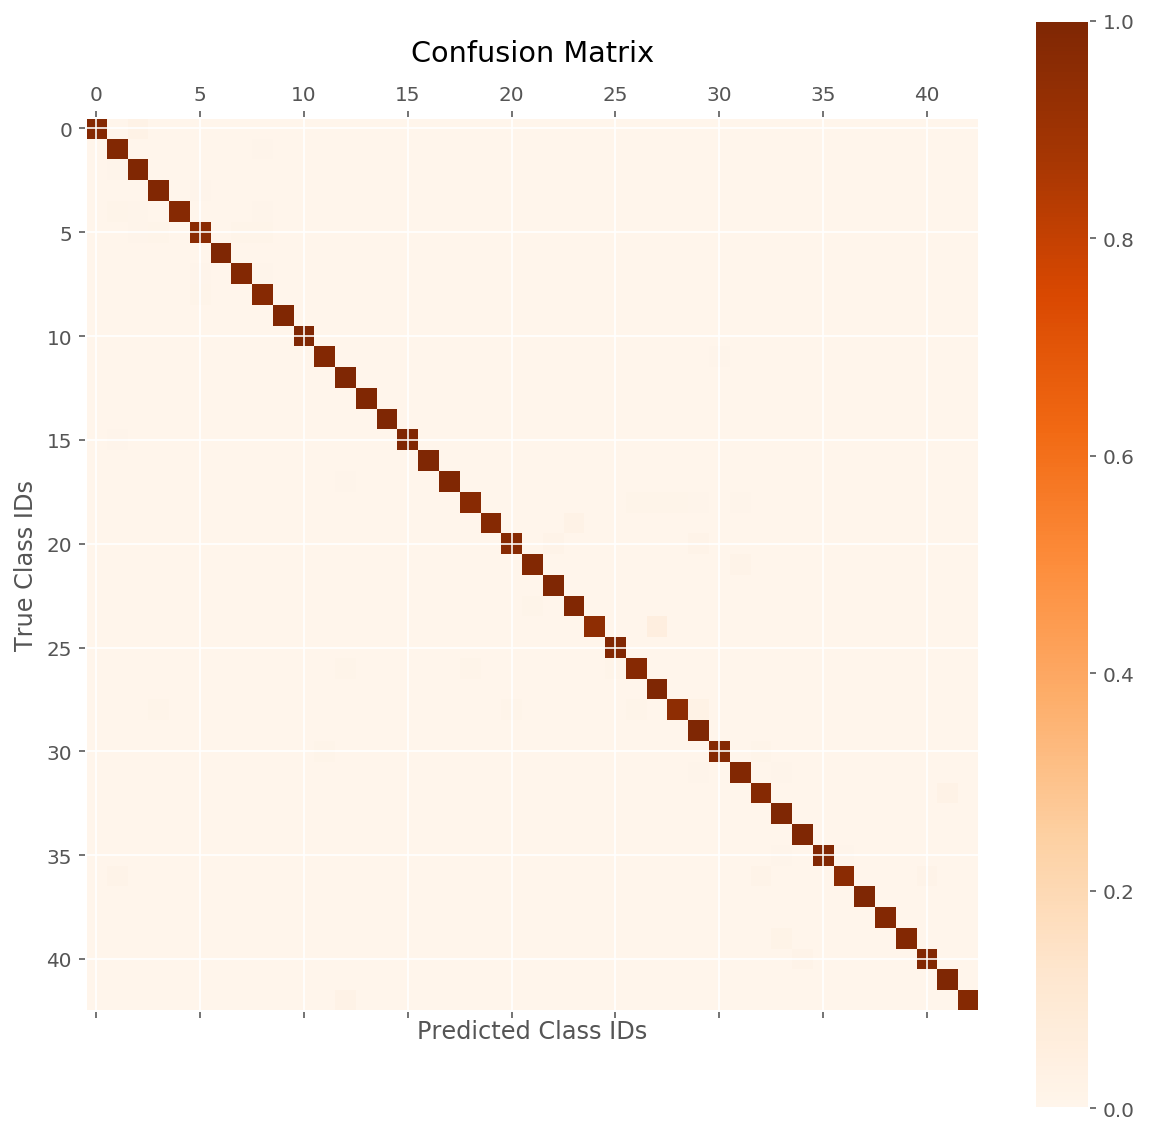

 6 End of speed limit (80km/h)                        100.00%  334
12 Priority road                                      100.00% 1672
14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
22 Bumpy road                                         100.00%  310
27 Pedestrians                                        100.00%  191
29 Bicycles crossing                                  100.00%  215
33 Turn right ahead                                   100.00%  548
34 Turn left ahead                                    100.00%  334
37 Go straight or left                                100.00%  167
41 End of no passing                                  100.00%  191
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
17 No entry                                            99.56%  884
 2 Speed limit (50km/h)                                99.35% 1791
 9 No passing                                          99.33% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3_epoch-30-lr-0.00010.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary

Overall the performance from reducing the learning rate even lower seemed to make things worse as a result overfitting was caused from making this change. 

- However the learning curve is much more smoother.

- The mean accuracy per class is worse and its standard devaition is bigger.

Nevertheless from this point forward I will not be reducing the lower rate instead I will stick with the learning rate from previous model test.

**Code Reference:**

- base_network_1_3_epoch-30-lr-0.00010 method defines the network model architecture. (Using same architecture as Network 1.3) but changing parameter values.
    - Reducing learning rate to 0.00010 (new_learning_rate) variable had been added.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network 1.4

**Change**: Changing the activation to leaky ReLU. The purpose of this would to be avoid prevent dead ReLU. Overall improve network performance.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.643 Evaluation Score: 0.641
-------------------------------------------------------------------
   F1 Score:    0.638 
-------------------------------------------------------------------
   Precision:   0.642 
-------------------------------------------------------------------
   Recall:      0.634 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.809 Evaluation Score: 0.801
-------------------------------------------------------------------
   F1 Score:    0.806 
-------------------------------------------------------------------
   Precision:   0.808 
-------------------------------------------------------------------
   Recall:      0.804 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.874 Evaluation Score: 0.869
-------------------------------------------------------------------
   F1 Score:    0.86

W0429 04:20:37.373711 140366615164736 deprecation_wrapper.py:119] From /notebooks/pipeline/session.py:37: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



Epoch:  29 Train Score: 0.992 Evaluation Score: 0.990
-------------------------------------------------------------------
   F1 Score:    0.991 
-------------------------------------------------------------------
   Precision:   0.991 
-------------------------------------------------------------------
   Recall:      0.990 
-------------------------------------------------------------------
CPU times: user 24min 10s, sys: 2min 8s, total: 26min 19s
Wall time: 26min 11s


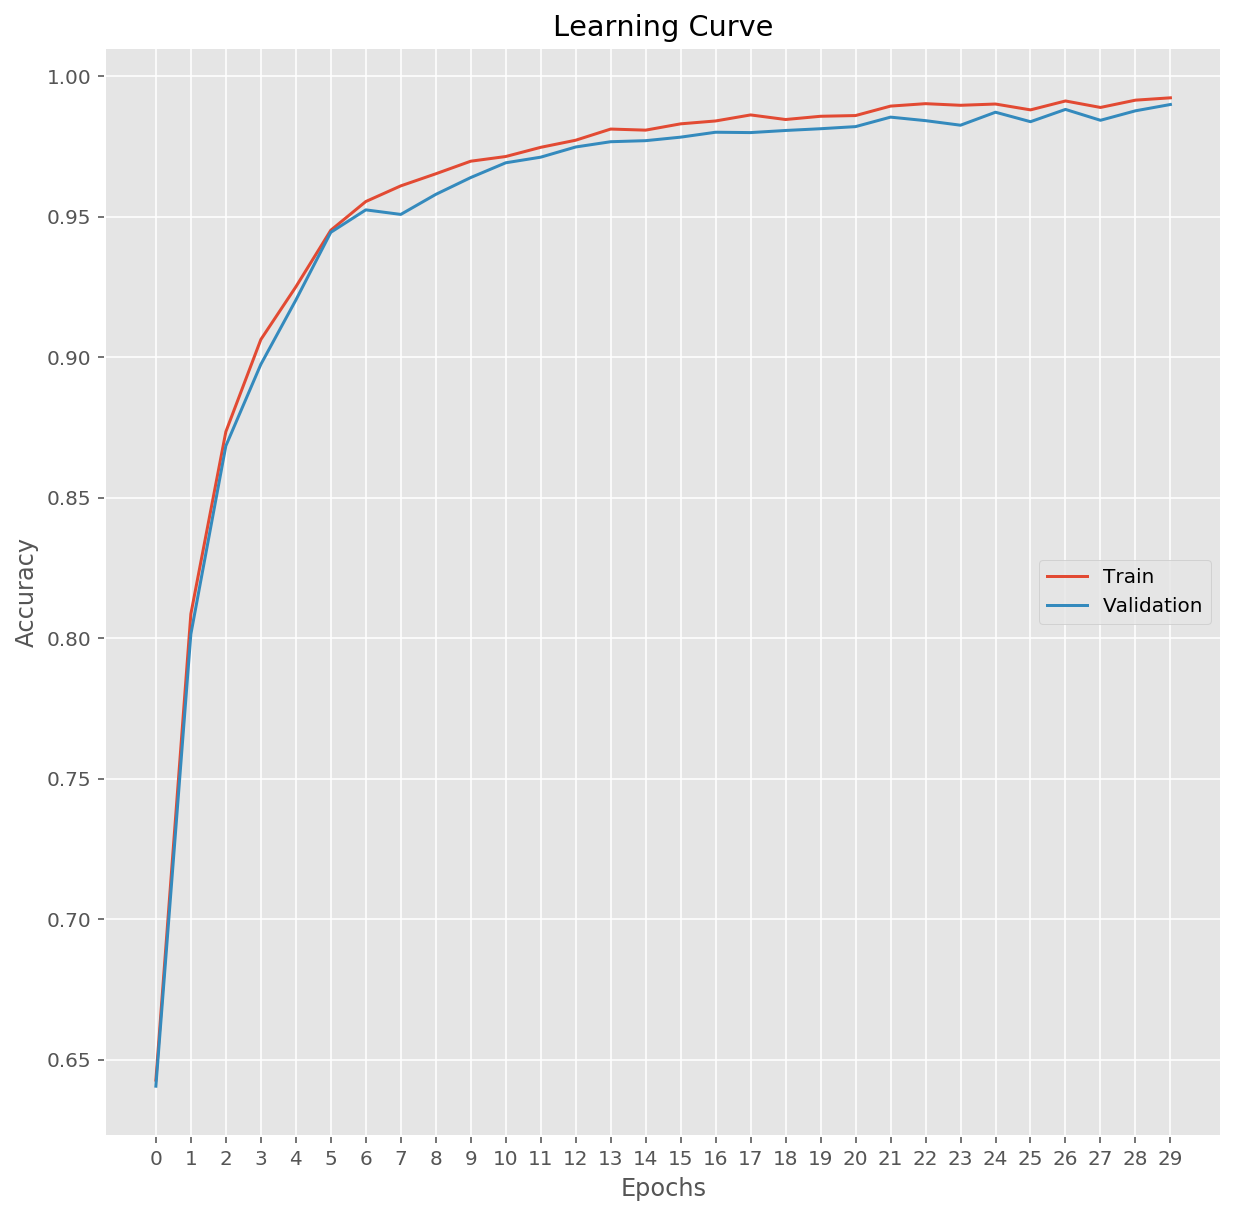

In [33]:
%%time
def base_network_1_4(input_shape=INPUT_SHAPE): # Method that describes model architecture for Network 1.4
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu(leak_ratio=0.01) # <== Leaky ReLU Activation Function
            .conv([5, 5, 64])
            .max_pool()
            .relu(leak_ratio=0.01) # <== Leaky ReLU Activation Function
            .flatten()
            .dense(480)
            .relu(leak_ratio=0.01) # <== Leaky ReLU Activation Function
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_4(), make_adam(0.5e-3)) # Learning rate = 0.0005
    learning_curve = train_evaluate(pipeline, epochs=30)
    session.save('Checkpoint/base_network_1_4.ckpt') # Saves the trained model as index / checkpoint.

create_learning_curve(learning_curve)

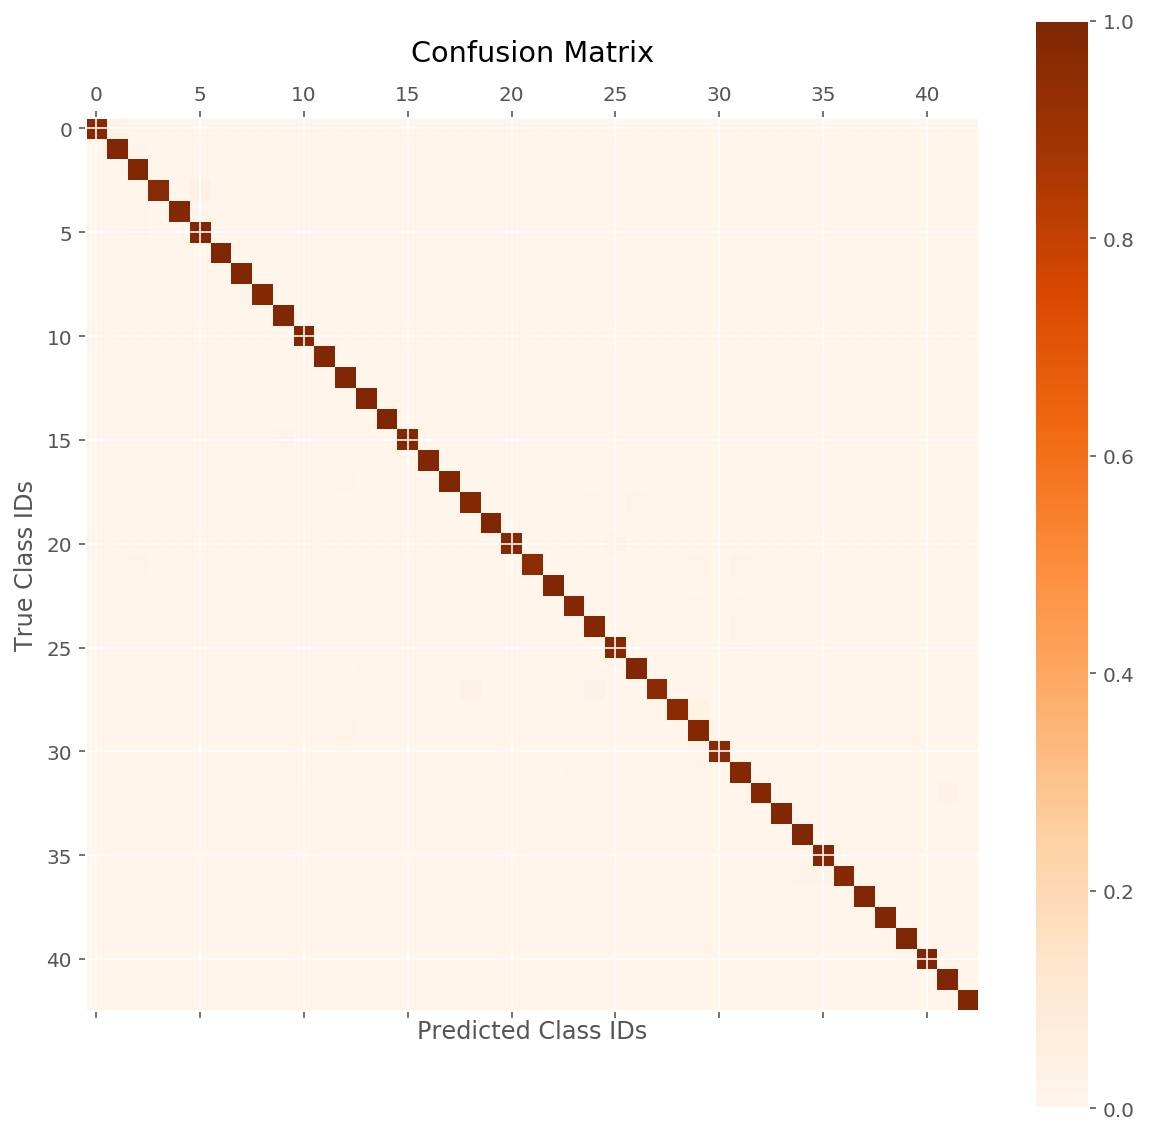

 6 End of speed limit (80km/h)                        100.00%  334
12 Priority road                                      100.00% 1672
14 Stop                                               100.00%  621
19 Dangerous curve to the left                        100.00%  167
22 Bumpy road                                         100.00%  310
34 Turn left ahead                                    100.00%  334
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00%  287
41 End of no passing                                  100.00%  191
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
35 Ahead only                                          99.59%  955
17 No entry                                            99.56%  884
13 Yield                                               99.55% 1719
10 No passing for vehicles over 3.5 metric tons        99.51% 

In [35]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_4())
    session.load('Checkpoint/base_network_1_4.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary

Despite the change to using a leaky ReLU - no significant difference has been spotted. Utilsing Leaky ReLU did not make the network learn faster.

**Code Reference:**

- base_network1_4() method defines the network model architecture.
    - Activation function parameter is changed to leaky ReLU. This leaky ReLU is defined within 'network.py' file.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network 1.5

**Change**: Test using ELU activation opose to ReLU to determine whether model improves. The purpose of this would be to improve the performance of the model.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.654 Evaluation Score: 0.647
-------------------------------------------------------------------
   F1 Score:    0.649 
-------------------------------------------------------------------
   Precision:   0.653 
-------------------------------------------------------------------
   Recall:      0.646 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.786 Evaluation Score: 0.782
-------------------------------------------------------------------
   F1 Score:    0.780 
-------------------------------------------------------------------
   Precision:   0.785 
-------------------------------------------------------------------
   Recall:      0.775 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.854 Evaluation Score: 0.856
-------------------------------------------------------------------
   F1 Score:    0.85

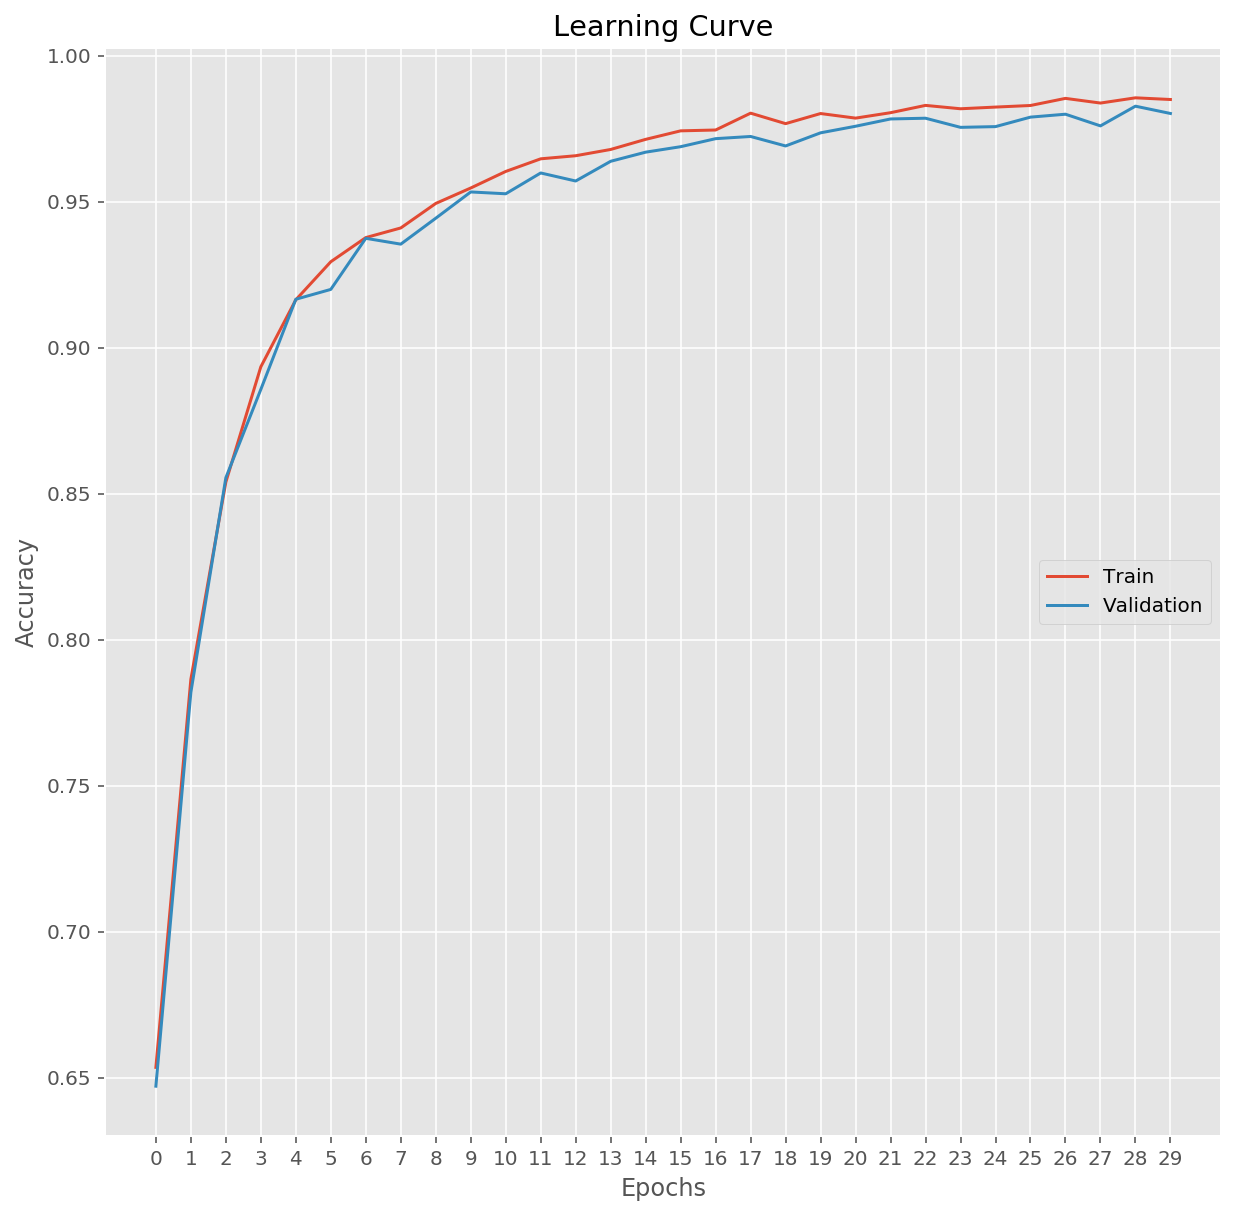

In [36]:
%%time
def base_network_1_5(input_shape=INPUT_SHAPE): # Method that describes model architecture for Network 1.5
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .elu()              # Changing before ReLU to ELU.
            .conv([5, 5, 64])
            .max_pool()
            .elu()              # Changing before ReLU to ELU.
            .flatten()
            .dense(480)
            .elu()              # Changing before ReLU to ELU.
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_5(), make_adam(0.5e-3)) # Learning Rate = 0.0005
    learning_curve = train_evaluate(pipeline, epochs=30) # Evaluates the network performance over 30 epochs.
    session.save('Checkpoint/base_network_1_5.ckpt')     # Saves the modex index / checkpoint for later chart analysis.
    
create_learning_curve(learning_curve)

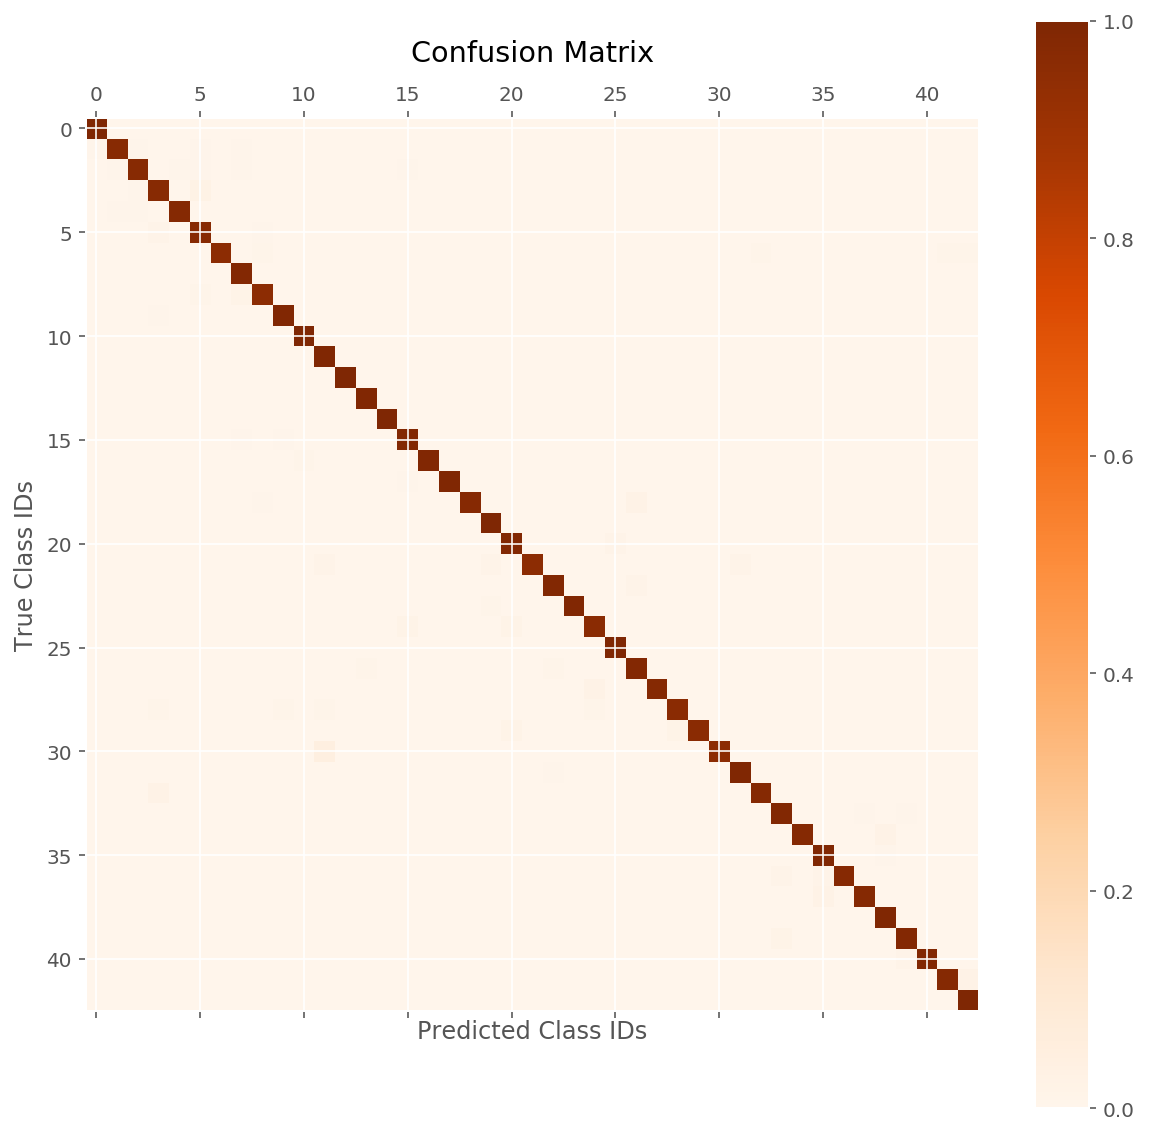

 0 Speed limit (20km/h)                               100.00%  167
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
14 Stop                                               100.00%  621
19 Dangerous curve to the left                        100.00%  167
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
12 Priority road                                       99.77% 1672
25 Road work                                           99.67% 1194
35 Ahead only                                          99.59%  955
17 No entry                                            99.56%  884
38 Keep right                                          99.53% 1648
31 Wild animals crossing                               99.37%  621
11 Right-of-way at the next intersection               99.26% 1051
13 Yield                                               99.09% 1719
23 Slippery road                                       99.04%  406
 9 No passing                                          99.00% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_5())
    session.load('Checkpoint/base_network_1_5.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary

The result derived a lower training score (98.8%) and validation (98.4%) when compared to the previous benchmark (Phase 5). Overfitting is also present as shown on a learning curve, implying complexity needs to increase either by increasing EPOCHs or reducing the learning rate. However, the matrix report reflected a good mean accuracy (98.1%) but was lower than the previous model.

**Code Reference:**

- base_network1_5() method defines the network model architecture.
    - Activation function parameter is changed to ELU instead of ReLU. This ELU is defined within 'network.py' file.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity: Self-Driving Car Engineer (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]
- (3) mlfromscratch (2019) [https://mlfromscratch.com/activation-functions-explained/]

### Network 1.6

**Change**: Adjusting the weight sigma value to be lower -> 0.01.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.504 Evaluation Score: 0.508
-------------------------------------------------------------------
   F1 Score:    0.510 
-------------------------------------------------------------------
   Precision:   0.512 
-------------------------------------------------------------------
   Recall:      0.508 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.743 Evaluation Score: 0.740
-------------------------------------------------------------------
   F1 Score:    0.737 
-------------------------------------------------------------------
   Precision:   0.742 
-------------------------------------------------------------------
   Recall:      0.733 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.835 Evaluation Score: 0.835
-------------------------------------------------------------------
   F1 Score:    0.83

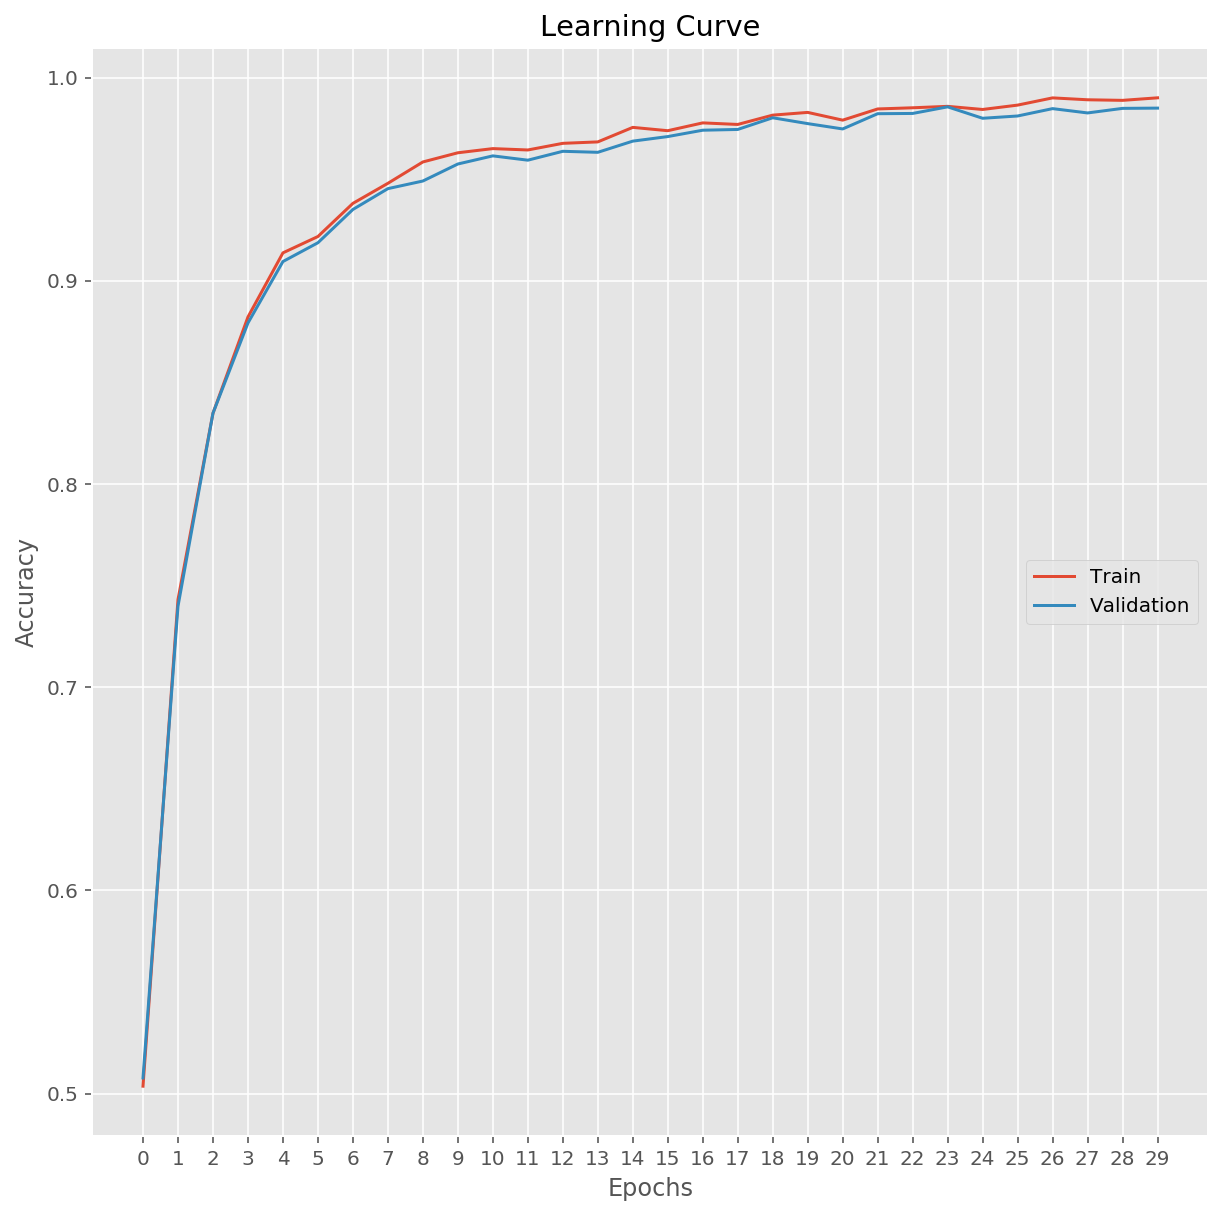

In [37]:
%%time
weighted_sigma_value = 0.01 # Setting variable to store initial weight value. This is the standard value.
def base_network_1_6(input_shape=INPUT_SHAPE): # Method that describes model architecture for Network 1.6
    return (NeuralNetwork(weight_sigma=weighted_sigma_value) # <== Smaller Weight Sigma
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_6(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=30)
    session.save('Checkpoint/base_network_1_6.ckpt')
    
create_learning_curve(learning_curve)

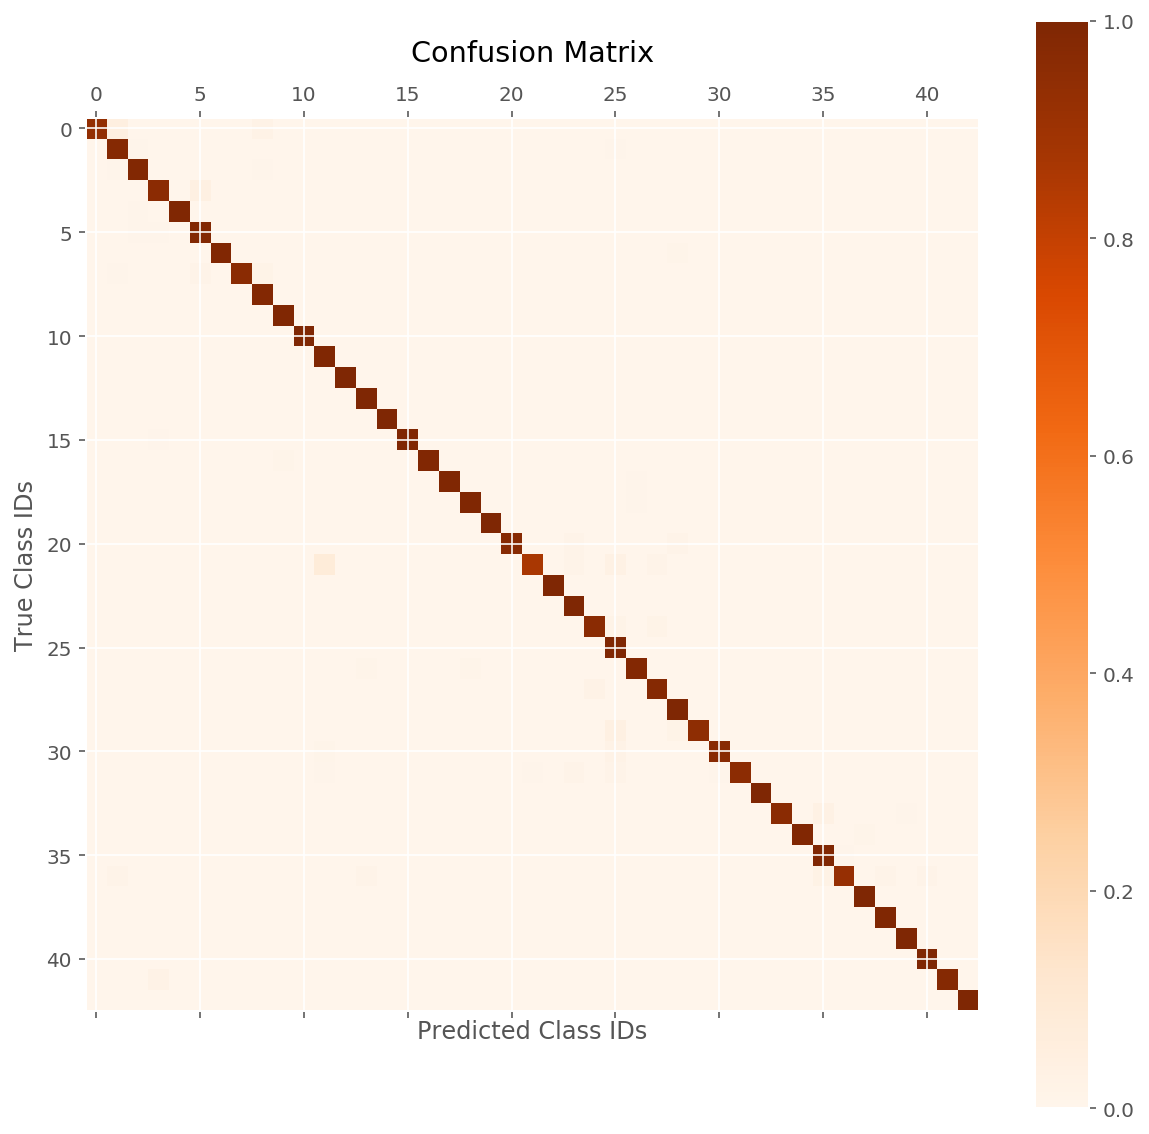

14 Stop                                               100.00%  621
19 Dangerous curve to the left                        100.00%  167
22 Bumpy road                                         100.00%  310
23 Slippery road                                      100.00%  406
28 Children crossing                                  100.00%  430
32 End of all speed and passing limits                100.00%  191
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00%  287
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
13 Yield                                               99.77% 1719
12 Priority road                                       99.77% 1672
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
25 Road work                                           99.67% 1194
18 General caution                                     99.59% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_6())
    session.load('Checkpoint/base_network_1_6.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

Weight initialization aims to prevent layer activation outputs from exploding or disappearing for the duration of a deep neural network ahead switch. If one of these things occurs, loss gradients can be too excessive or too small to drift backward in a useful manner, and the network will take longer to converge (towardsdatascience, James Dellinger, 2019). By reducing the weight value (0.01) aim is to improve model performance. However, this was not the case when applied. It derived a lower training accuracy score of (98.9%) and validation (98.5%).

**Code Reference:**

- base_network1_6() method defines the network model architecture.
    - Reducing initial weight value to improve performance.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) James Dellinger (2019) - Machine Learning Mastery [https://towardsdatascience.com/weekly-selection-apr-5-2019-f744fd2f4703]

### Network 1.7

**Change**: Adding an additional dense layer to the network model.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.652 Evaluation Score: 0.655
-------------------------------------------------------------------
   F1 Score:    0.657 
-------------------------------------------------------------------
   Precision:   0.653 
-------------------------------------------------------------------
   Recall:      0.660 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.798 Evaluation Score: 0.791
-------------------------------------------------------------------
   F1 Score:    0.793 
-------------------------------------------------------------------
   Precision:   0.800 
-------------------------------------------------------------------
   Recall:      0.786 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.868 Evaluation Score: 0.861
-------------------------------------------------------------------
   F1 Score:    0.86

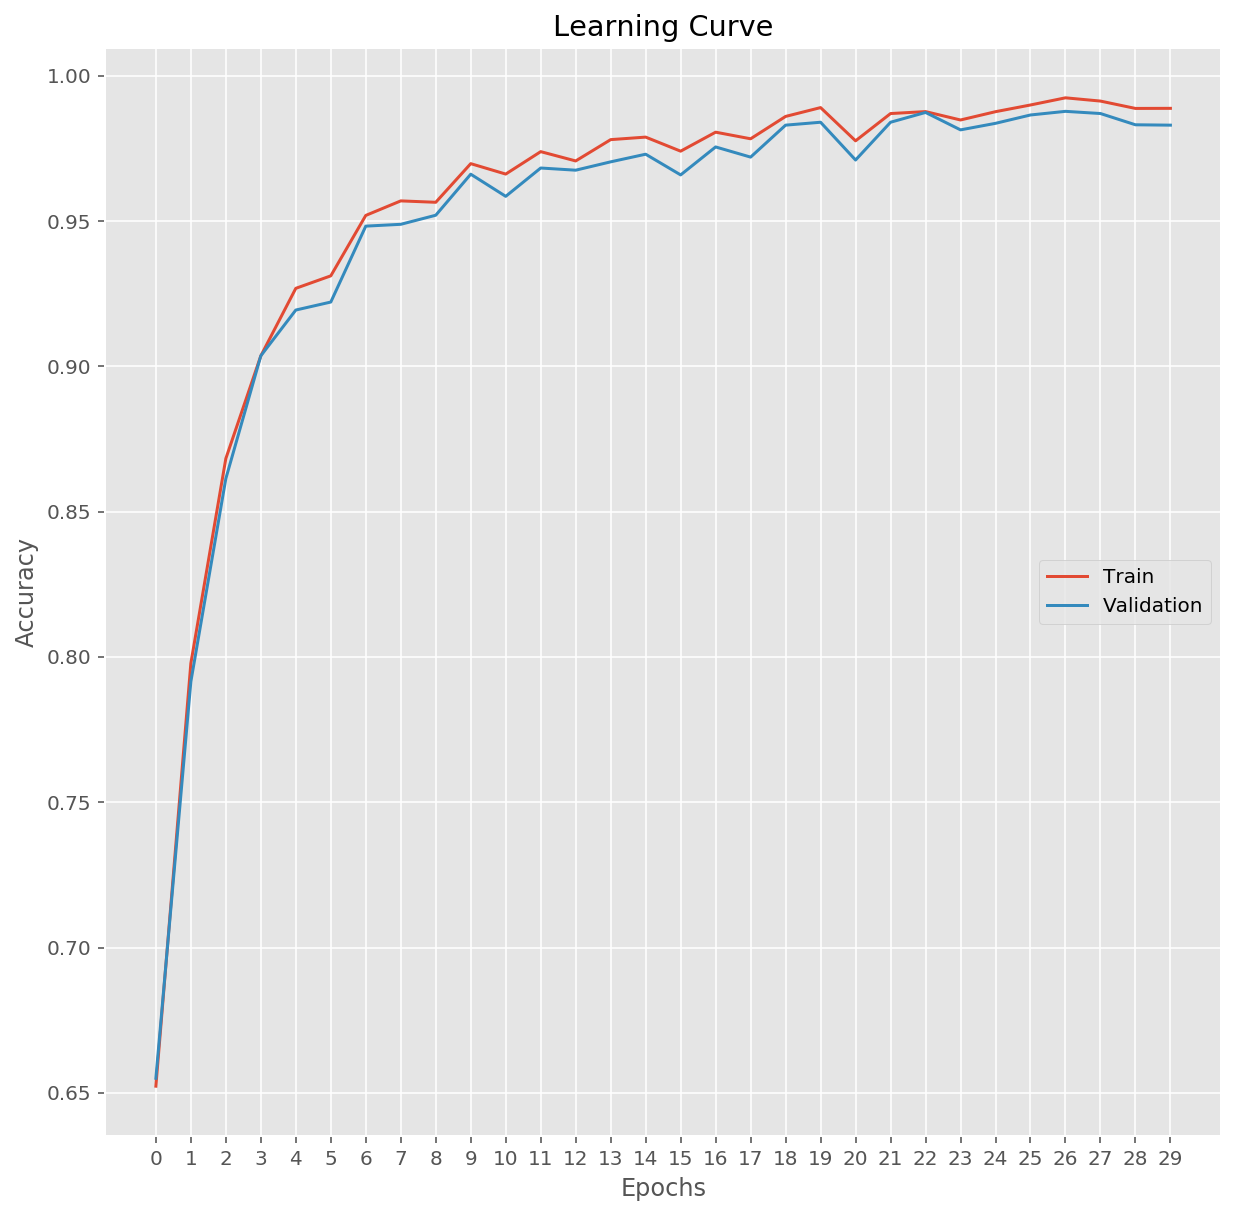

In [38]:
%%time
def base_network_1_7(input_shape=INPUT_SHAPE): # Method that describes model architecture for Network 1.6
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(240) # Additional dense layer had been added with half neurons of initial dense layer (240).
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_7(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=30)
    session.save('Checkpoint/base_network_1_7.ckpt')
    
create_learning_curve(learning_curve)

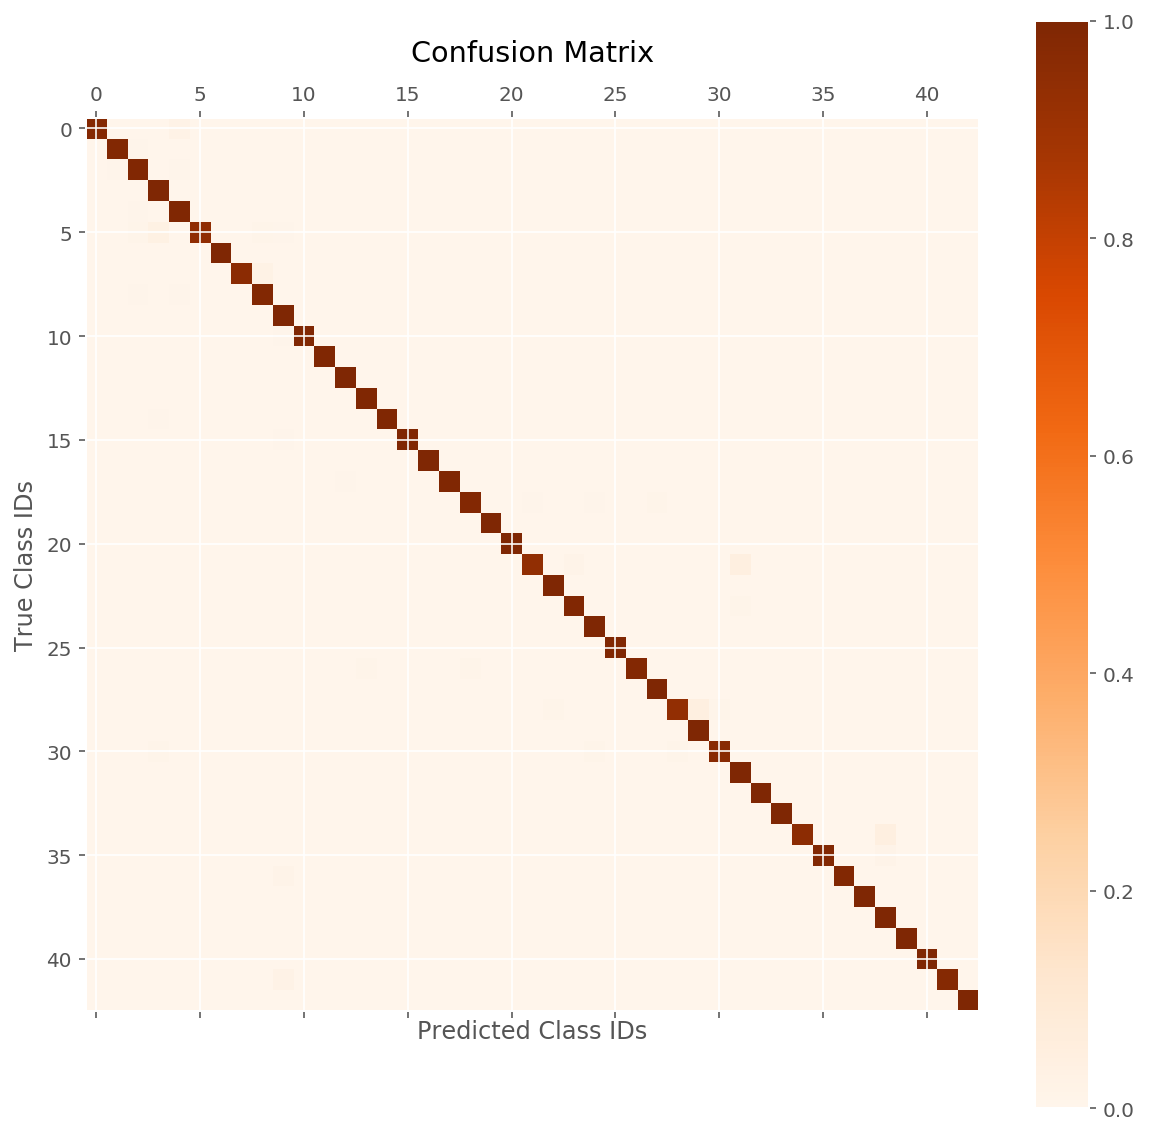

 6 End of speed limit (80km/h)                        100.00%  334
12 Priority road                                      100.00% 1672
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
20 Dangerous curve to the right                       100.00%  287
22 Bumpy road                                         100.00%  310
24 Road narrows on the right                          100.00%  215
27 Pedestrians                                        100.00%  191
29 Bicycles crossing                                  100.00%  215
31 Wild animals crossing                              100.00%  621
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
37 Go straight or left                                100.00%  167
38 Keep right                                         100.00% 1648
39 Keep left                                          100.00% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_7())
    session.load('Checkpoint/base_network_1_7.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

Additional dense layer would help extract more features given more neurons are available! However effect of adding additional dense layer hindered both training accuracy (99.1%) and validation score (98.8%) when compared with benchmark!

**Code Reference:**

- base_network1_7() method defines the network model architecture.
    - Additional dense layer added; method to add dense layer also created within 'network.py' file.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).

### Network - 1.8

**Change**: For this network training model I will build up on the model created within Network 1.3 however MaxPooling layer will be added after ReLU.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.657 Evaluation Score: 0.648
-------------------------------------------------------------------
   F1 Score:    0.657 
-------------------------------------------------------------------
   Precision:   0.656 
-------------------------------------------------------------------
   Recall:      0.658 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.811 Evaluation Score: 0.808
-------------------------------------------------------------------
   F1 Score:    0.807 
-------------------------------------------------------------------
   Precision:   0.810 
-------------------------------------------------------------------
   Recall:      0.804 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.869 Evaluation Score: 0.866
-------------------------------------------------------------------
   F1 Score:    0.86

W0429 13:16:57.099927 140373889210176 deprecation_wrapper.py:119] From /notebooks/pipeline/session.py:37: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



Epoch:  29 Train Score: 0.990 Evaluation Score: 0.985
-------------------------------------------------------------------
   F1 Score:    0.988 
-------------------------------------------------------------------
   Precision:   0.990 
-------------------------------------------------------------------
   Recall:      0.986 
-------------------------------------------------------------------
CPU times: user 27min 4s, sys: 2min 19s, total: 29min 23s
Wall time: 29min 13s


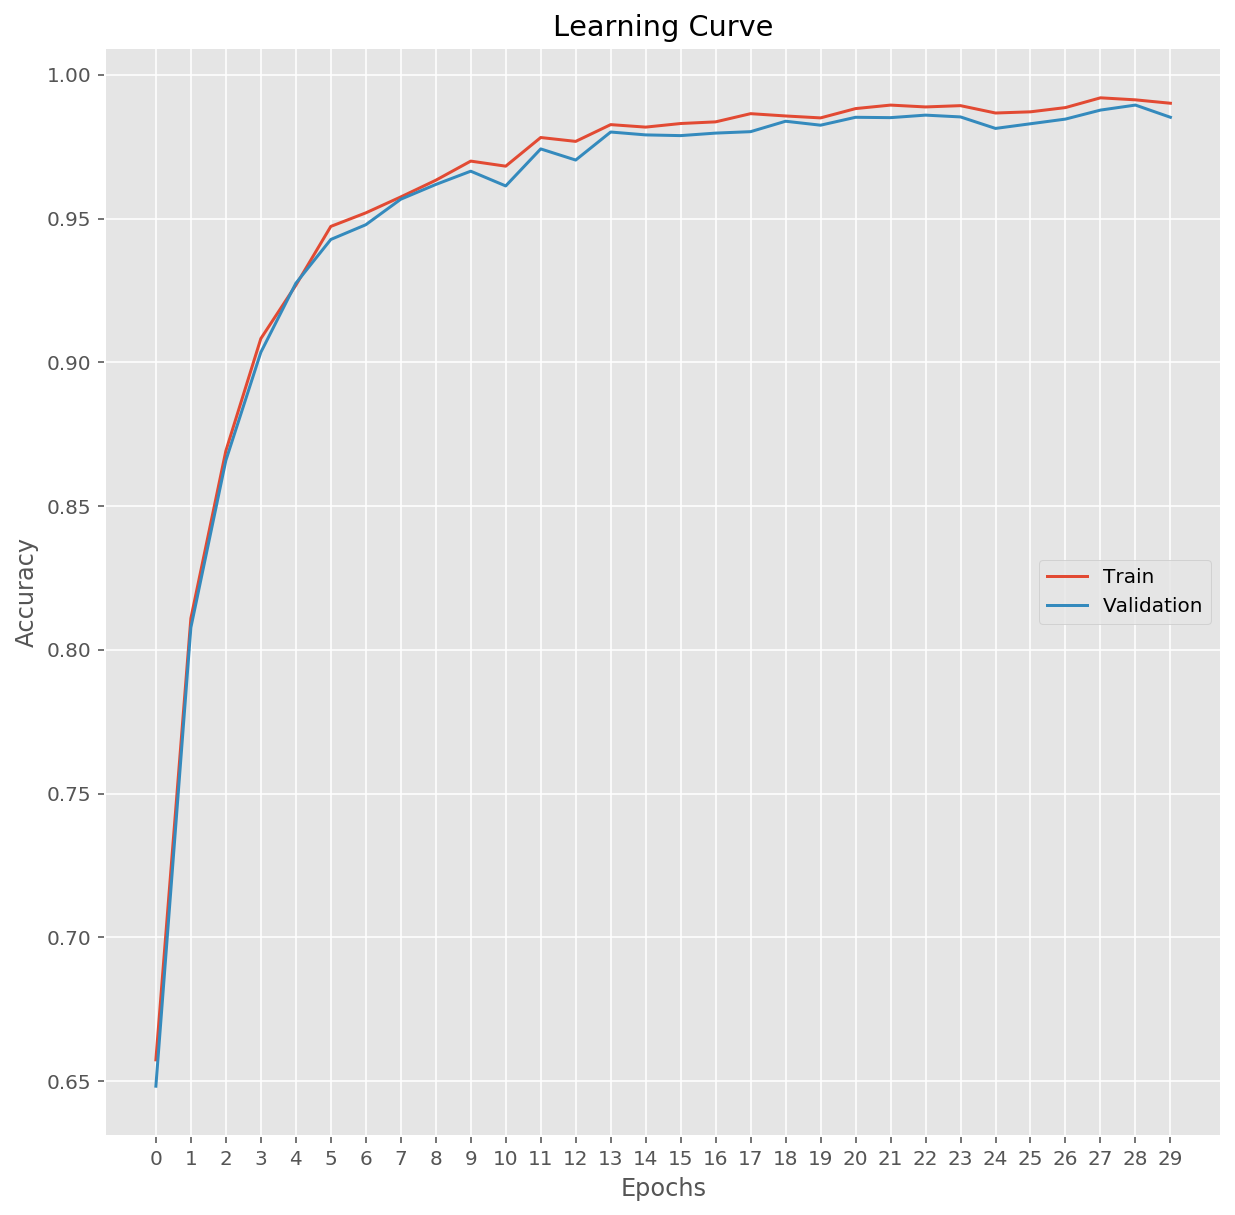

In [31]:
%%time
def base_network_1_8(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .relu()     
            .max_pool() # <== MaxPooling Layer had been after ReLU.
            .conv([5, 5, 64])
            .relu()
            .max_pool() # <== MaxPooling Layer had been added after ReLU.
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_8(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=30)
    session.save('Checkpoint/base_network_1_8.ckpt')
    
create_learning_curve(learning_curve)

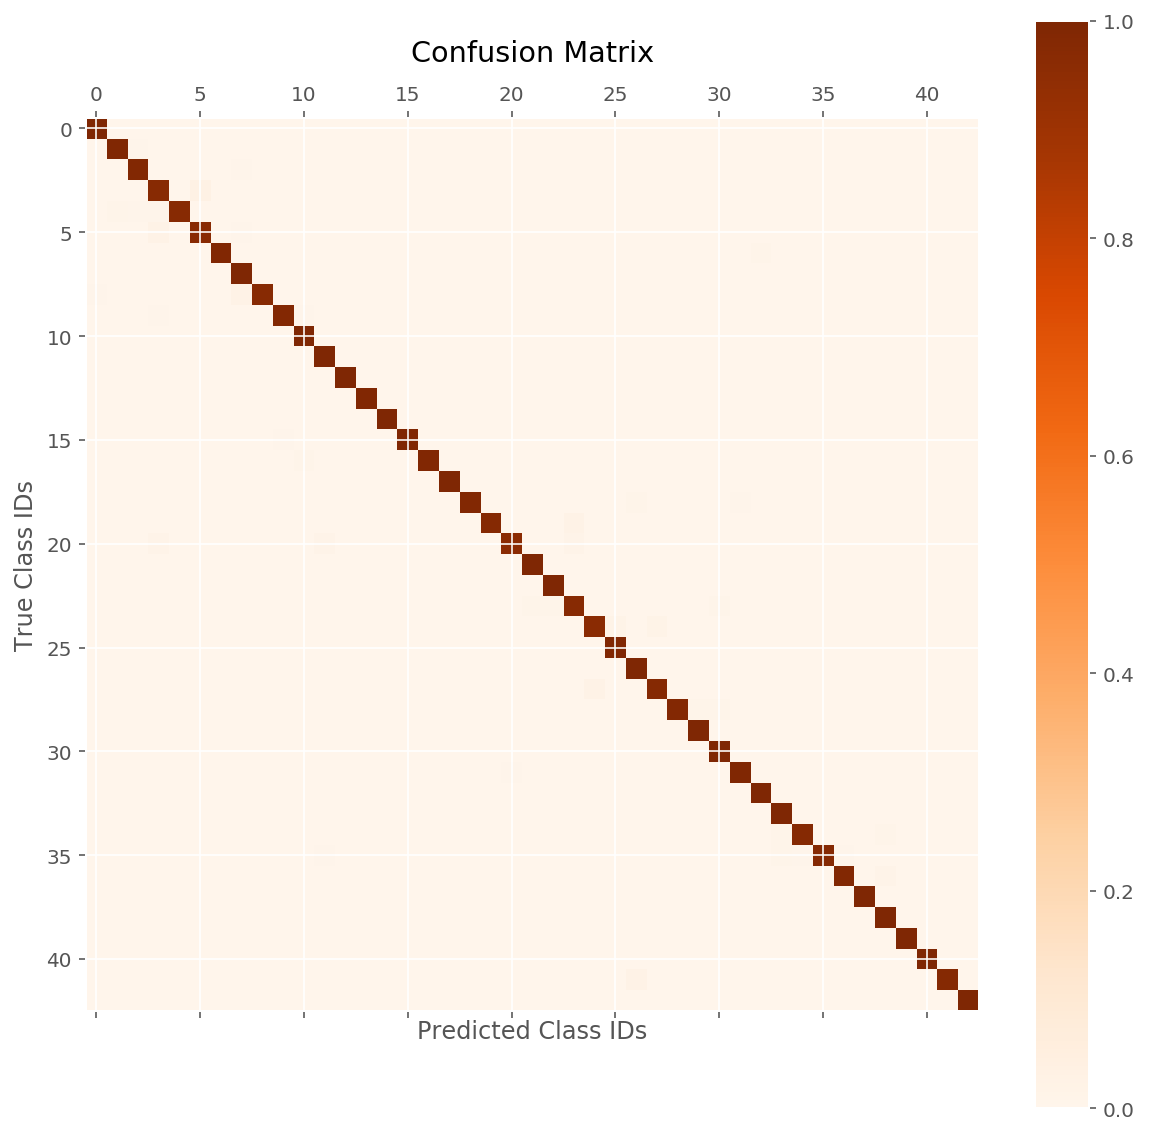

 0 Speed limit (20km/h)                               100.00%  167
 7 Speed limit (100km/h)                              100.00% 1146
14 Stop                                               100.00%  621
17 No entry                                           100.00%  884
21 Double curve                                       100.00%  263
22 Bumpy road                                         100.00%  310
26 Traffic signals                                    100.00%  478
29 Bicycles crossing                                  100.00%  215
30 Beware of ice/snow                                 100.00%  358
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
37 Go straight or left                                100.00%  167
38 Keep right                                         100.00% 1648
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_8())
    session.load('Checkpoint/base_network_1_8.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

Using max-pooling would reduce the feature space by throwing out nodes whose capabilities are not indicative (makes training models more tractable) alongside it enlarge the receptive field without using extra parameters (Intro to Pooling, Jason Brownlee, 2019). Overall, as it reduces the network's complexity and improves performance runtime, it should improve performance accuracy. However, the result derived a similar result to previous models, including benchmark, so no further improvements. 

**Code Reference:**

- base_network1_8() method defines the network model architecture.
    - Additional MaxPooling layer added; method to add MaxPooling layer also created within 'network.py' file.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).

### Network - 1.9

**Change**: For this networking training model I check to see whether adding 3 convolutional layers improve the performance of the model.

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.666 Evaluation Score: 0.666
-------------------------------------------------------------------
   F1 Score:    0.661 
-------------------------------------------------------------------
   Precision:   0.665 
-------------------------------------------------------------------
   Recall:      0.657 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.817 Evaluation Score: 0.815
-------------------------------------------------------------------
   F1 Score:    0.815 
-------------------------------------------------------------------
   Precision:   0.817 
-------------------------------------------------------------------
   Recall:      0.813 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.871 Evaluation Score: 0.868
-------------------------------------------------------------------
   F1 Score:    0.86

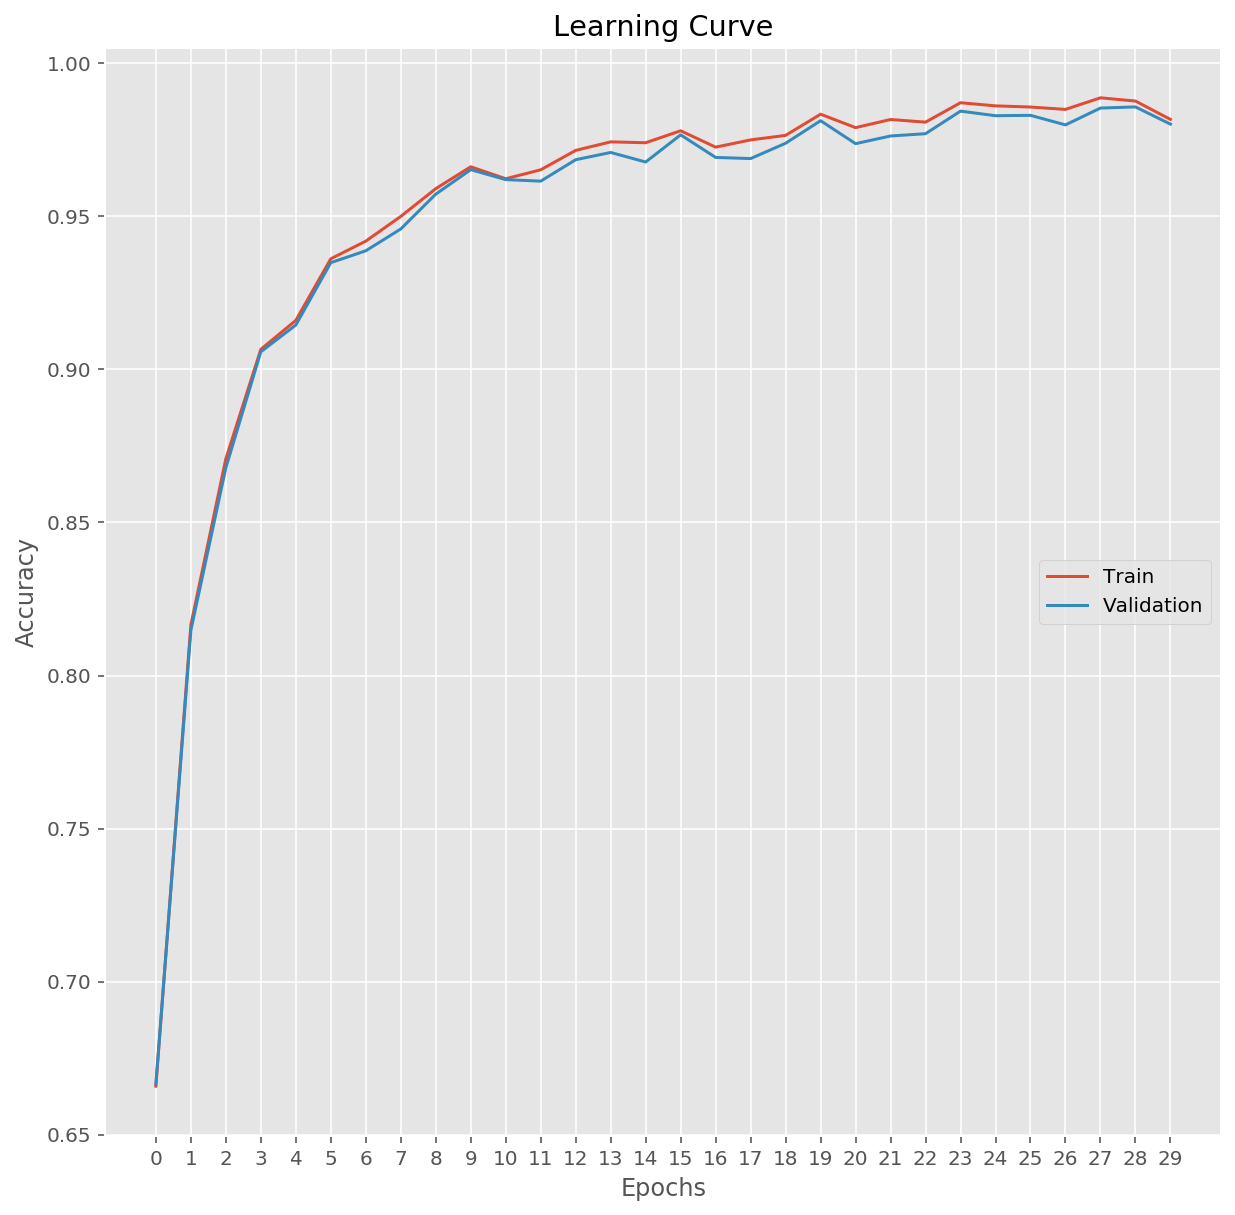

In [32]:
def base_network_1_9(input_shape=INPUT_SHAPE): # Model architecture for Network 1.9
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .conv([3, 3, 64])  # Additional convolutional layer added the size of kernel (image input size) is smaller. 
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_9(), make_adam(0.5e-3)) # Learning Rate = 0.0005
    learning_curve = train_evaluate(pipeline, epochs=30) # Model accuracy evaluated over 30 epochs.
    session.save('Checkpoint/base_network_1_9.ckpt')     # Model is saved as an index / checkpoint for later use.
    
create_learning_curve(learning_curve)                    # Generate the learning curve plot using accuracy scores saved in learning_curve.

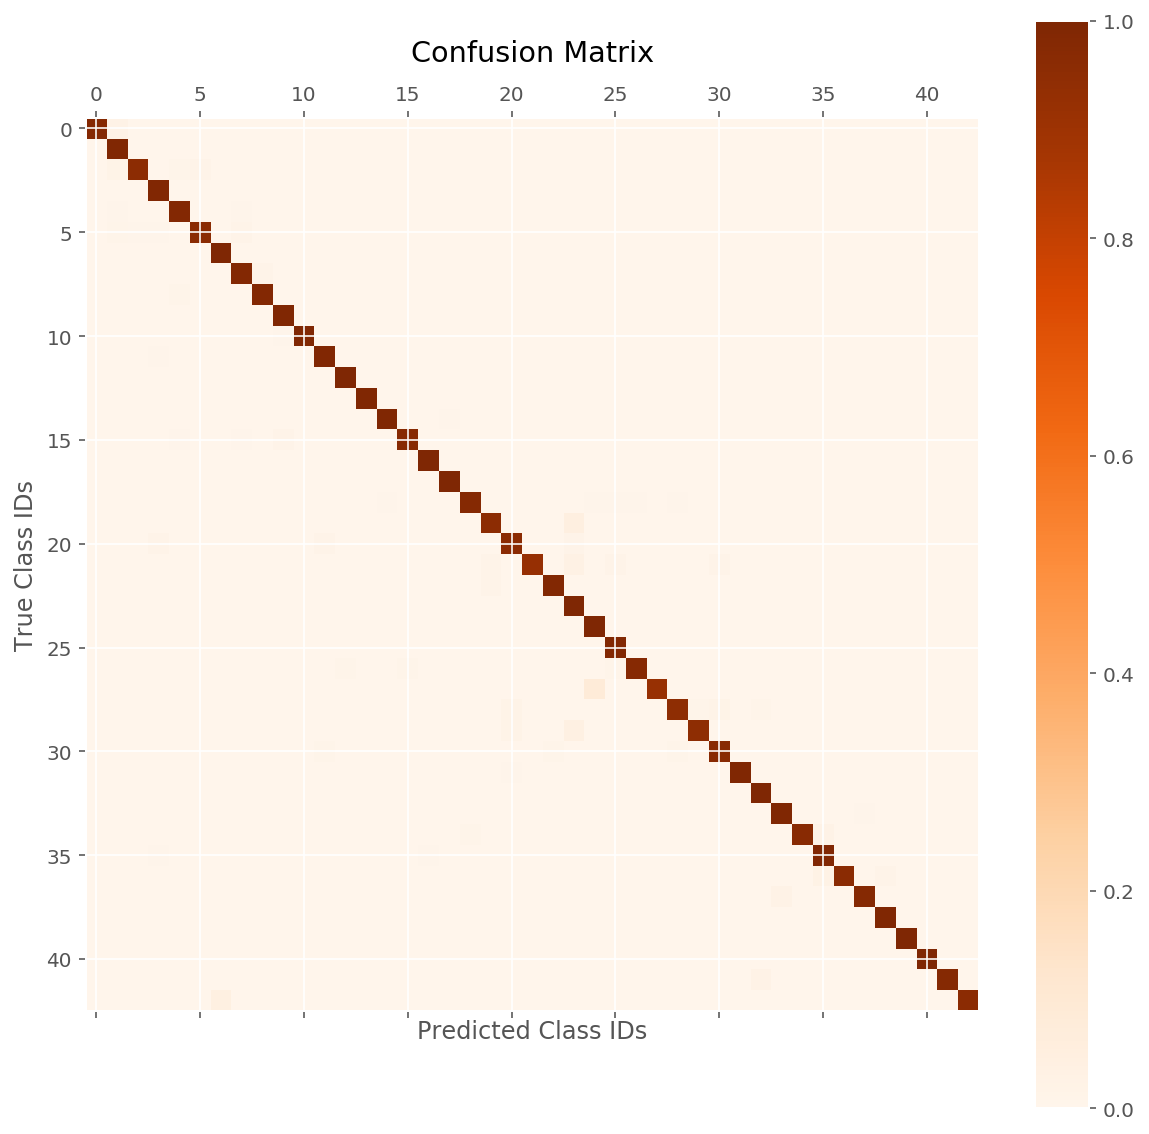

 6 End of speed limit (80km/h)                        100.00%  334
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
17 No entry                                           100.00%  884
23 Slippery road                                      100.00%  406
24 Road narrows on the right                          100.00%  215
32 End of all speed and passing limits                100.00%  191
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00%  287
12 Priority road                                       99.77% 1672
14 Stop                                                99.37%  621
31 Wild animals crossing                               99.37%  621
 1 Speed limit (30km/h)                                99.34% 1767
 9 No passing                                          99.33% 1170
13 Yield                                               99.32% 1719
33 Turn right ahead                                    99.29% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_9())
    session.load('Checkpoint/base_network_1_9.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

Adding another layer with a smaller kernel was used to help further extract better features. The aim of this was to help encourage deeper learning for the model also extracts more features. The model yielded a far worse score than previous phase models for both training (97.9%) and validation (98.1%). 

**Code Reference:**

- base_network1_9() method defines the network model architecture.
    - Additional convolutional layer added from 'network.py' file.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity CarND (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network - 1.3 (Balanced Dataset)

**Change**: For this test I will be utilising Network 1.3 given this network model performed the best in terms of accuracy of classifying the Traffic Data. As well as outputting the highest Train Score and Evaluation Score, I will now try to see how it evaluates a balanced dataset, previous models had to take into consideration the different class skews which would have an impact on how well the classifier works.

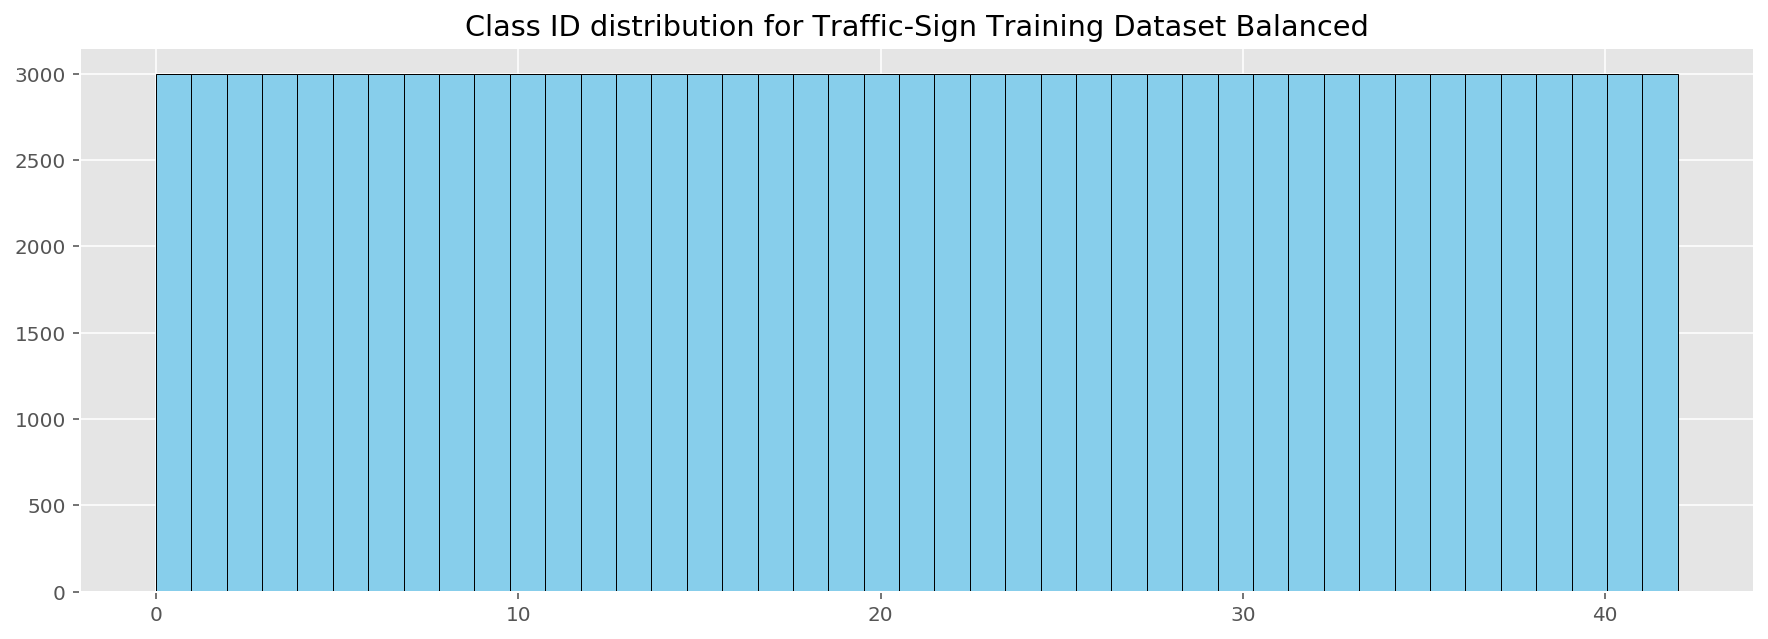

CPU times: user 4.27 s, sys: 11.7 ms, total: 4.28 s
Wall time: 4.29 s


In [18]:
%%time
def network_balanced_dist(X, y, size): # Method architecture for Balanced Dataset. (Same architecture used for Network 1.3).
    X_balanced = [] # Stores the balanced training data.
    y_balanced = [] # Stores the balanced training data.
    for c in range(N_CLASSES):  # Loops through each class that will match each class with same set of images defined within (y_balanced)
        data = X[y==c]
        indices = np.random.choice(sum(y==c), size)
        X_balanced.extend(X[y==c][indices])
        y_balanced.extend(y[y==c][indices])
    return np.array(X_balanced), np.array(y_balanced)

X_balanced, y_balanced = network_balanced_dist(X_train, y_train, 3000) # Plots histogram showing balanced distribution.

show_class_distribution(y_balanced, 'Traffic-Sign Training Dataset Balanced') # Histogram is plotted using show_class_distribution_method defined above.

#### Short Summary:

Now each class within the dataset has a balanced equal set of distribution as they all have been fixed to contain 3000 images.

Epoch:   0 Train Score: 0.683 Evaluation Score: 0.618
Epoch:   1 Train Score: 0.829 Evaluation Score: 0.778
Epoch:   2 Train Score: 0.888 Evaluation Score: 0.840
Epoch:   3 Train Score: 0.919 Evaluation Score: 0.881
Epoch:   4 Train Score: 0.940 Evaluation Score: 0.902
Epoch:   5 Train Score: 0.949 Evaluation Score: 0.917
Epoch:   6 Train Score: 0.962 Evaluation Score: 0.938
Epoch:   7 Train Score: 0.964 Evaluation Score: 0.938
Epoch:   8 Train Score: 0.971 Evaluation Score: 0.953
Epoch:   9 Train Score: 0.977 Evaluation Score: 0.957
Epoch:  10 Train Score: 0.974 Evaluation Score: 0.959
Epoch:  11 Train Score: 0.978 Evaluation Score: 0.963
Epoch:  12 Train Score: 0.978 Evaluation Score: 0.962
Epoch:  13 Train Score: 0.981 Evaluation Score: 0.967
Epoch:  14 Train Score: 0.982 Evaluation Score: 0.966
Epoch:  15 Train Score: 0.984 Evaluation Score: 0.970
Epoch:  16 Train Score: 0.986 Evaluation Score: 0.976
Epoch:  17 Train Score: 0.988 Evaluation Score: 0.973
Epoch:  18 Train Score: 0.98

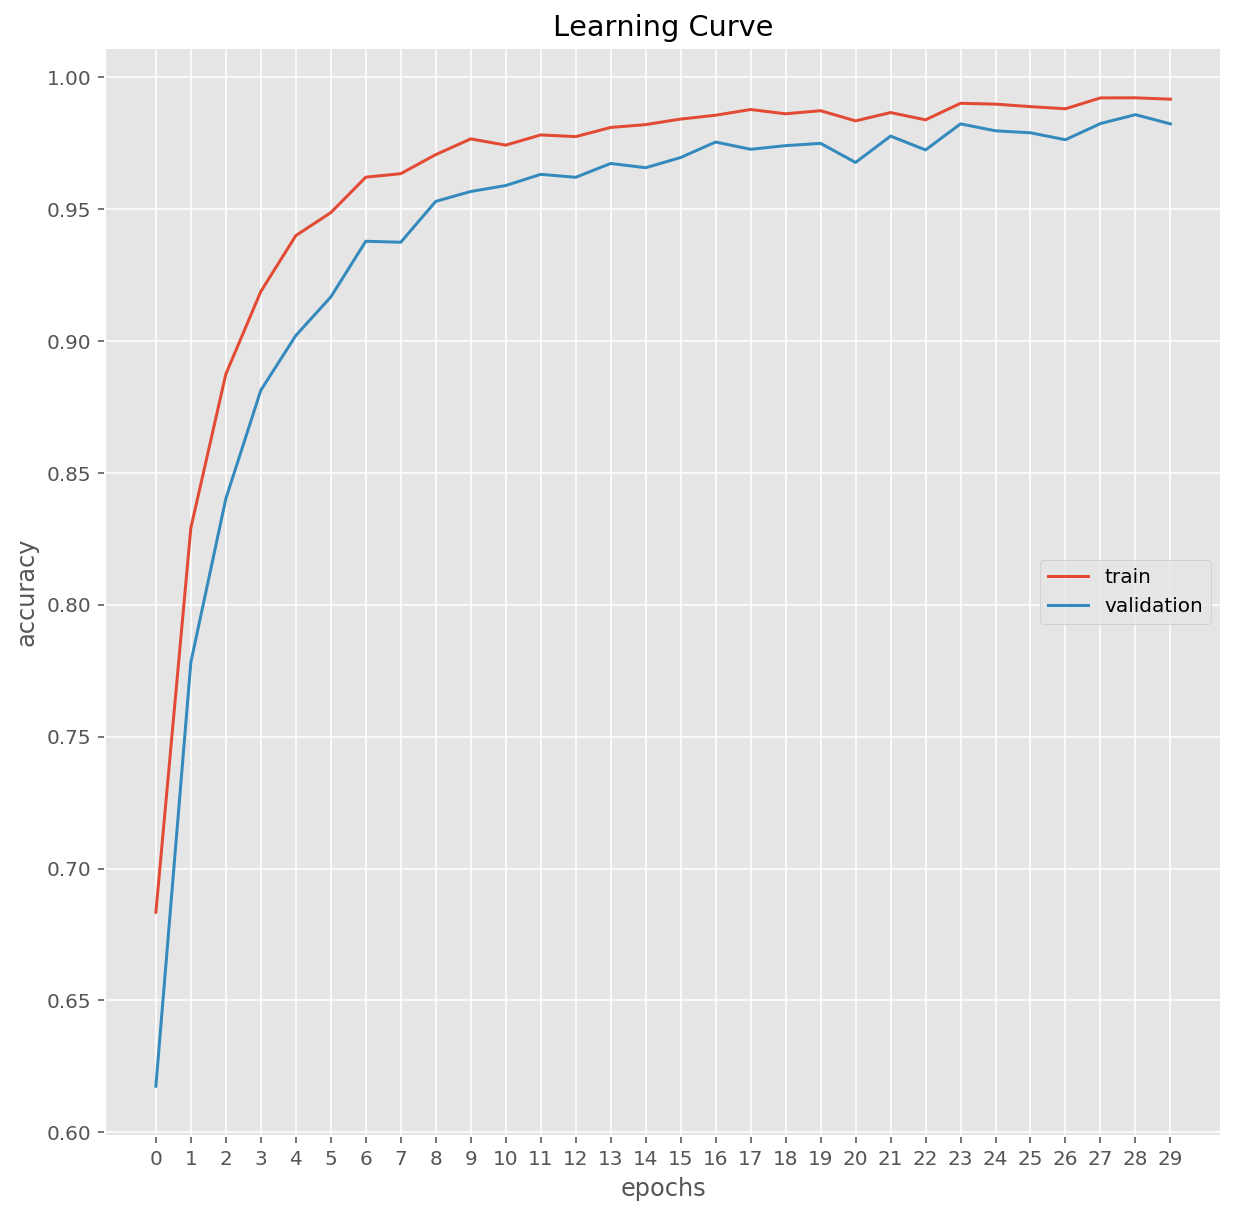

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(0.5e-3)) # Learning Rate = 0.0005
    learning_curve = train_evaluate(pipeline, epochs=30, train=(X_balanced, y_balanced)) # Using the balanced training  dataset.
    session.save('Checkpoint/base_network_1_3_balanced_distribution.ckpt')               # Network architecture saved as a checkpoint.

create_learning_curve(learning_curve) # Generates the learning curve.

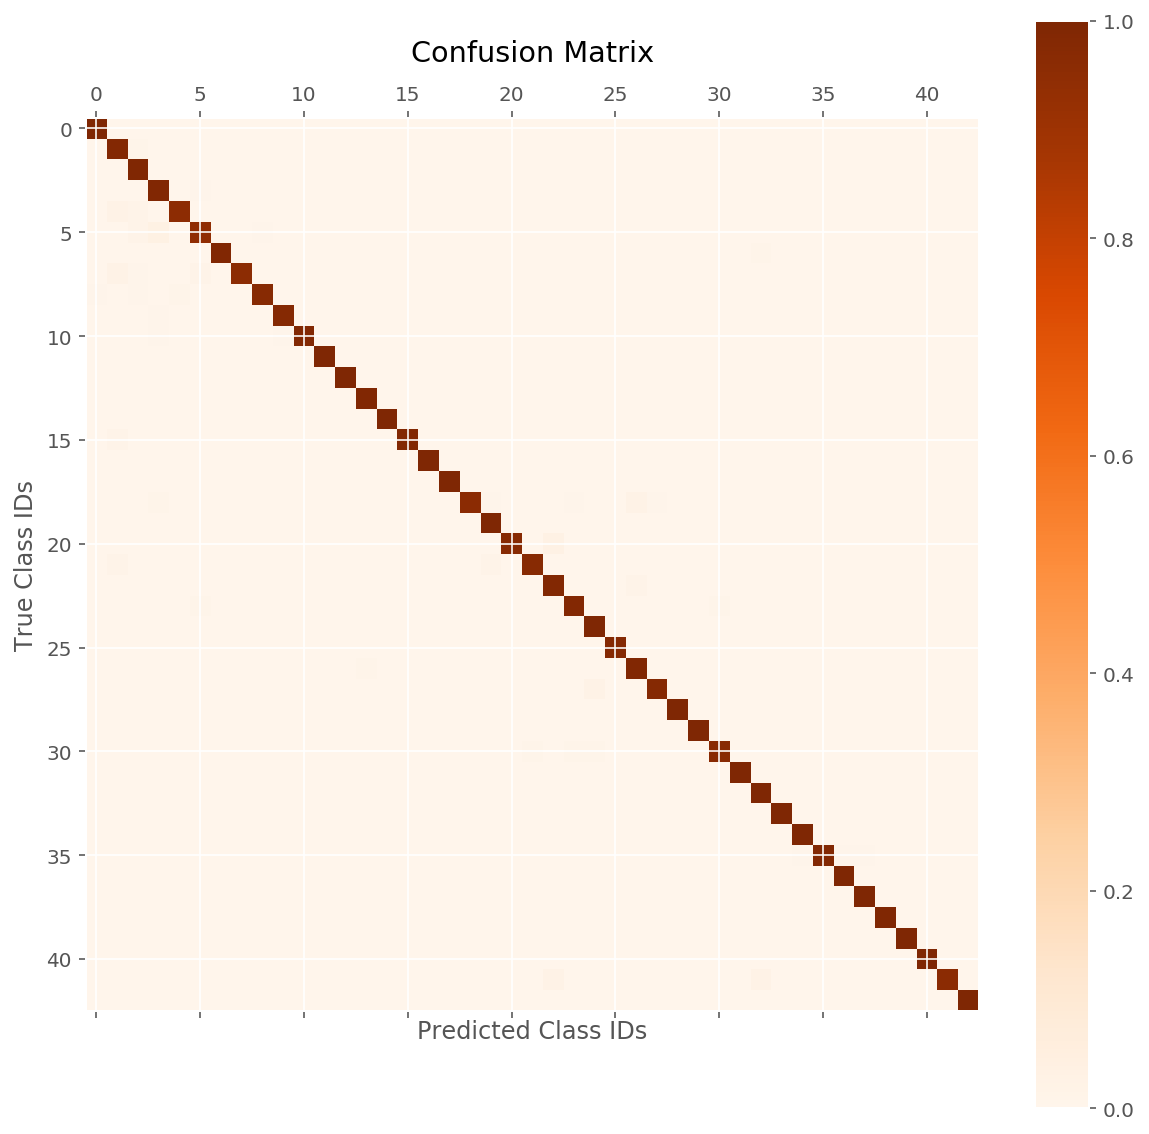

 0 Speed limit (20km/h)                               100.00%  167
14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
17 No entry                                           100.00%  884
19 Dangerous curve to the left                        100.00%  167
24 Road narrows on the right                          100.00%  215
28 Children crossing                                  100.00%  430
29 Bicycles crossing                                  100.00%  215
31 Wild animals crossing                              100.00%  621
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
34 Turn left ahead                                    100.00%  334
36 Go straight or right                               100.00%  310
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00% 

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3_balanced_distribution.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

Upon testing this model on a balanced dataset, the result indicated a lower training score (99.2%) and validation score (98.2%). The learning curve was clear from the beginning overfitting was occurring, and the discrepancy between both scores showed this (curve-gap). This was likely caused due to distribution of data being different for the validation set, whereas the training set was equal. 
The matrix report indicated a mean accuracy of 98.6%, a high percentile, meaning it could classify most traffic-sign images.

Possibly increasing the number of epochs may help?

**Code Reference:**

- base_network_1_3_balanced_distribution() method defines the network model architecture.
    - Balanced dataset.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity CarND (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network - 1.3 (EPOCH INCREASED TO 100)

Epoch:   0 Train Score: 0.681 Evaluation Score: 0.672
Epoch:   1 Train Score: 0.811 Evaluation Score: 0.809
Epoch:   2 Train Score: 0.883 Evaluation Score: 0.878
Epoch:   3 Train Score: 0.908 Evaluation Score: 0.900
Epoch:   4 Train Score: 0.930 Evaluation Score: 0.925
Epoch:   5 Train Score: 0.948 Evaluation Score: 0.945
Epoch:   6 Train Score: 0.952 Evaluation Score: 0.946
Epoch:   7 Train Score: 0.957 Evaluation Score: 0.947
Epoch:   8 Train Score: 0.969 Evaluation Score: 0.967
Epoch:   9 Train Score: 0.975 Evaluation Score: 0.972
Epoch:  10 Train Score: 0.976 Evaluation Score: 0.969
Epoch:  11 Train Score: 0.980 Evaluation Score: 0.976
Epoch:  12 Train Score: 0.978 Evaluation Score: 0.971
Epoch:  13 Train Score: 0.982 Evaluation Score: 0.980
Epoch:  14 Train Score: 0.981 Evaluation Score: 0.973
Epoch:  15 Train Score: 0.983 Evaluation Score: 0.981
Epoch:  16 Train Score: 0.984 Evaluation Score: 0.982
Epoch:  17 Train Score: 0.985 Evaluation Score: 0.979
Epoch:  18 Train Score: 0.98

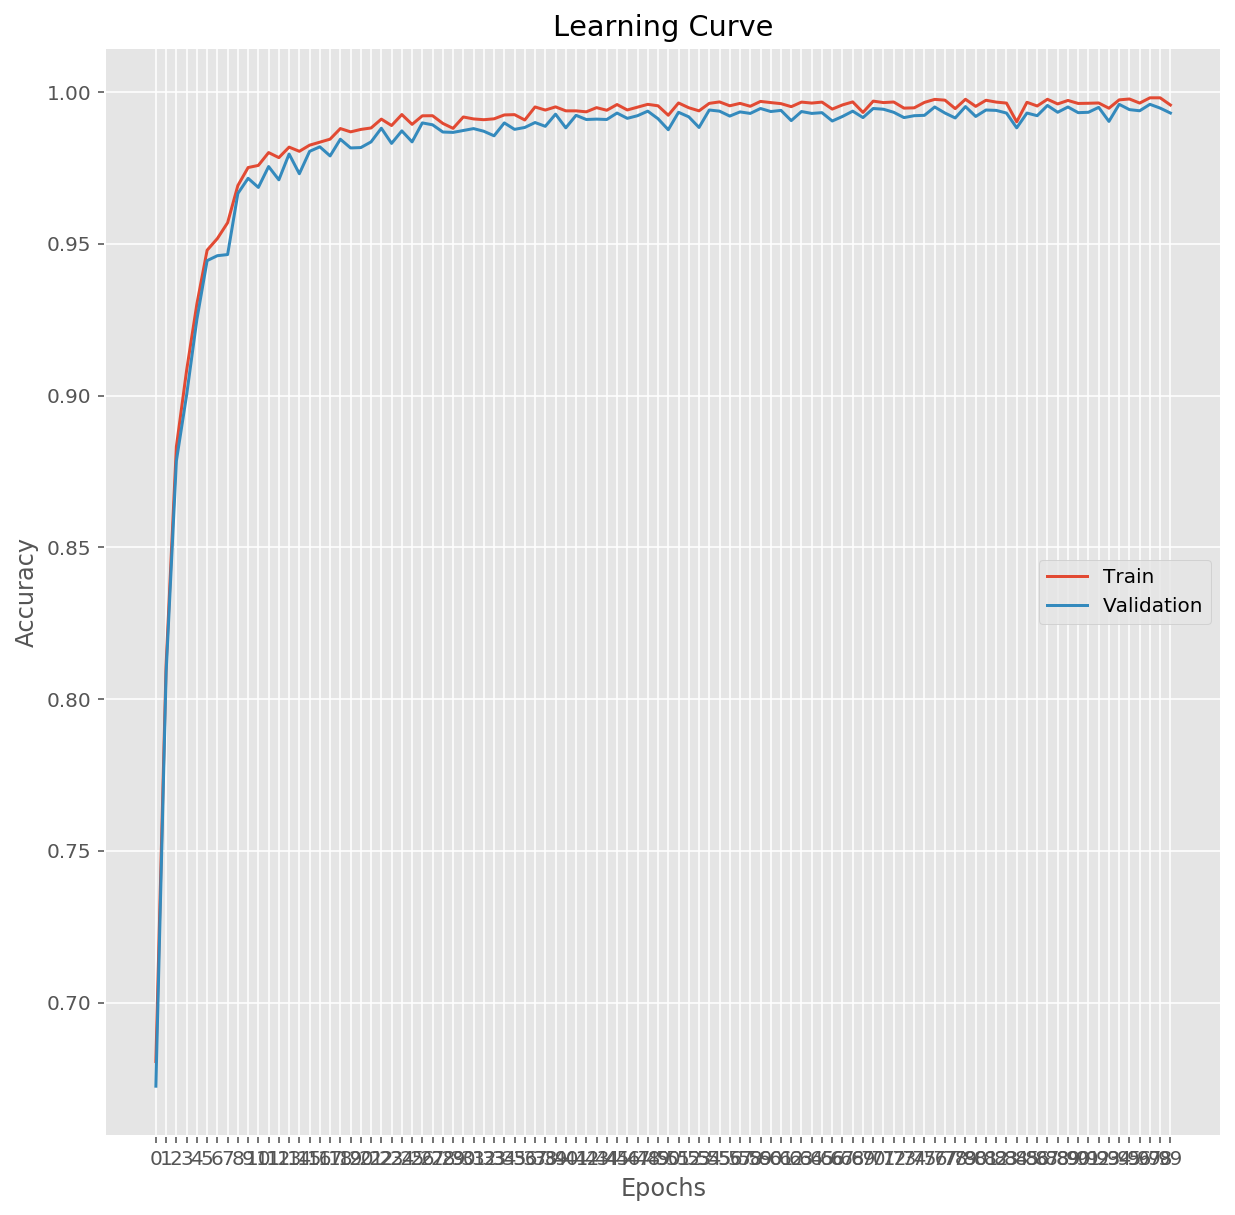

In [38]:
%%time
with Session() as session: # Using the same network architecture for Network 1.3
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(0.5e-3))  # Learning Rate = 0.0005
    learning_curve = train_evaluate(pipeline, epochs=100) # Model evaluated using 100 epochs.
    session.save('Checkpoint/base_network_1_3_EPOCHS_100.ckpt') # Model saved as an index or checkpoint for later use.
    
create_learning_curve(learning_curve) # Plotting the learning curve using the accuracy scores.

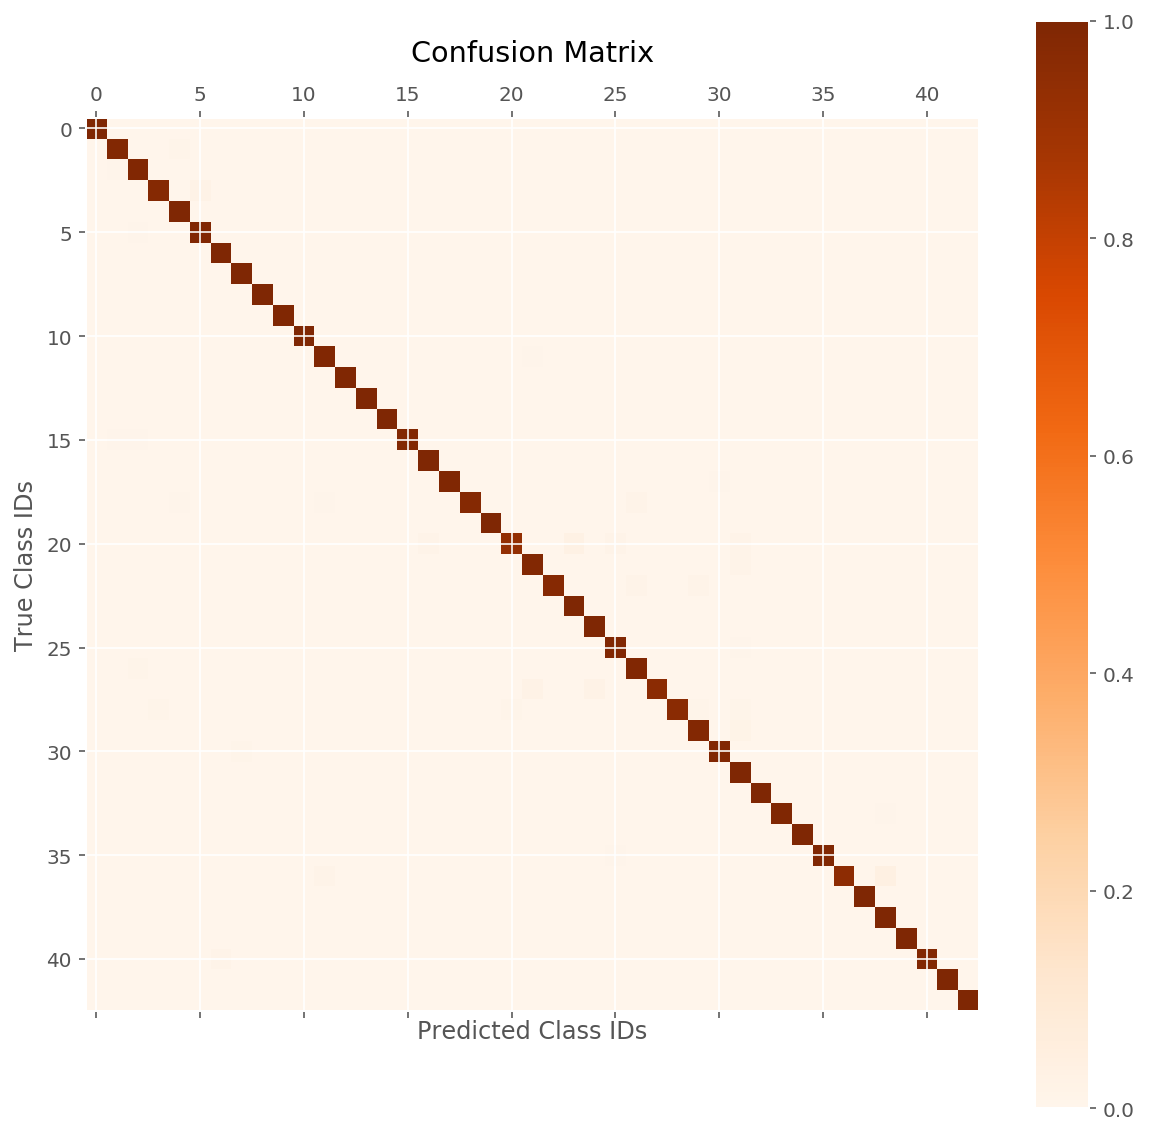

 0 Speed limit (20km/h)                               100.00%  167
 6 End of speed limit (80km/h)                        100.00%  334
 7 Speed limit (100km/h)                              100.00% 1146
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
23 Slippery road                                      100.00%  406
24 Road narrows on the right                          100.00%  215
31 Wild animals crossing                              100.00%  621
32 End of all speed and passing limits                100.00%  191
34 Turn left ahead                                    100.00%  334
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
41 End of no passing                                  100.00% 

In [45]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3_EPOCHS_100.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

To improve performance for this phase, the author decided to test the same model using 100 epochs. This will further encourage deeper learning, as the model is given more time to learn from the dataset. As predicted, the results derived were positive as training accuracy over 100 epochs returned (99.6%) and validation (99.3%) overall performing better.

**Code Reference:**

- base_network_1_3_EPOCHS_100() method defines the network model architecture.
    - Increasing the epoch parameter to 100.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity CarND (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network - 1.3 (EPOCH INCREASED TO 100 + Lower Learning Rate)

---------------------- CLASSIFICATION REPORT ----------------------
Epoch:   0 Train Score: 0.363 Evaluation Score: 0.355
-------------------------------------------------------------------
   F1 Score:    0.363 
-------------------------------------------------------------------
   Precision:   0.363 
-------------------------------------------------------------------
   Recall:      0.364 
-------------------------------------------------------------------
Epoch:   1 Train Score: 0.512 Evaluation Score: 0.517
-------------------------------------------------------------------
   F1 Score:    0.512 
-------------------------------------------------------------------
   Precision:   0.511 
-------------------------------------------------------------------
   Recall:      0.512 
-------------------------------------------------------------------
Epoch:   2 Train Score: 0.610 Evaluation Score: 0.604
-------------------------------------------------------------------
   F1 Score:    0.60

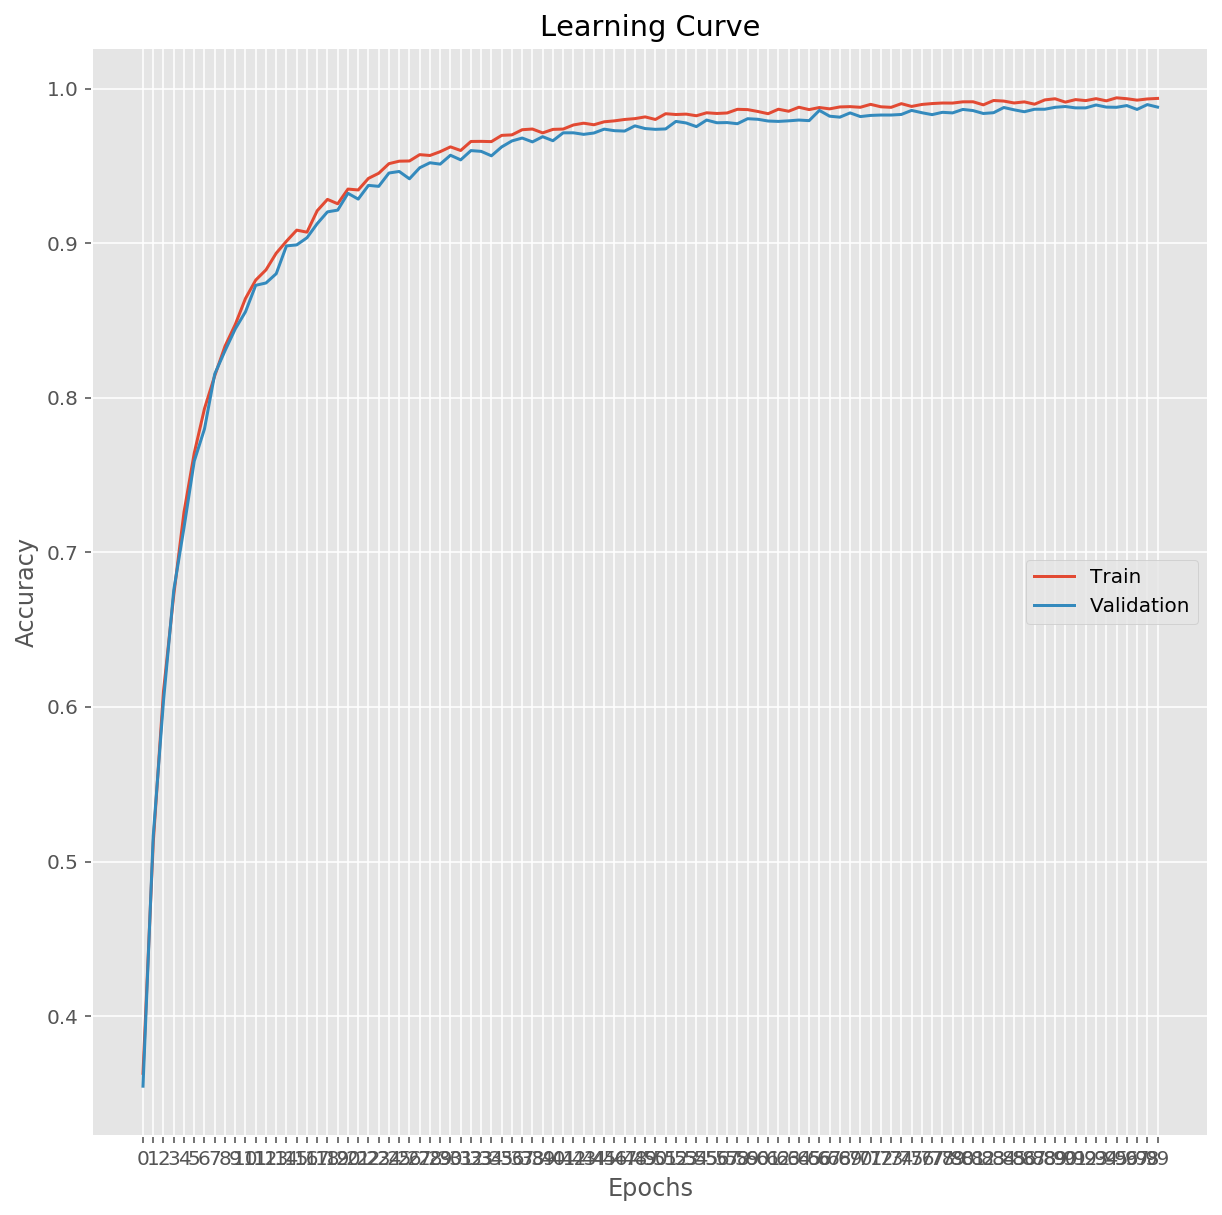

In [36]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3(), make_adam(1.0e-4)) # Reduced Learning Rate = 0.0001
    learning_curve = train_evaluate(pipeline, epochs=100) # Model tested over 100 epochs.
    session.save('Checkpoint/base_network_1_3_EPOCHS_100_LR_1.0e-14.ckpt') # Model saved as an index / checkpoint.
    
create_learning_curve(learning_curve) # Evaluates model performance using learning curve and accuracy scores.

In [ ]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_1_3())
    session.load('Checkpoint/base_network_1_3_EPOCHS_100_LR_1.0e-14.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

After running the model over 100 epochs, the result reflected accuracy of training as (99.4%) and validation (98.8%), thus showcasing an improved performance though accuracy is less than the previous test. The result indicates that learning over 100 epochs is far more effective, making the model more robust, as opposed to previous phase models tested using 30 epochs.

**Code Reference:**

- base_network_1_3_EPOCHS_100_LR_1.0e-14() method defines the network model architecture.
    - Reducing Learning Rate.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity CarND (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

### Network - 2.0 

**Change**: Improving network robustness by adding drop out with keep probability of 0.5.

I applied dropout which is a regularization technique that prevents our model from overfitting by setting a determined percentage of a layer's weights which are randomly selected to 0, so the model cannot depend on one feature or connection too much.

Epoch:   0 Train Score: 0.523 Evaluation Score: 0.517
Epoch:   1 Train Score: 0.708 Evaluation Score: 0.714
Epoch:   2 Train Score: 0.830 Evaluation Score: 0.828
Epoch:   3 Train Score: 0.893 Evaluation Score: 0.892
Epoch:   4 Train Score: 0.920 Evaluation Score: 0.917
Epoch:   5 Train Score: 0.935 Evaluation Score: 0.926
Epoch:   6 Train Score: 0.956 Evaluation Score: 0.951
Epoch:   7 Train Score: 0.957 Evaluation Score: 0.954
Epoch:   8 Train Score: 0.966 Evaluation Score: 0.965
Epoch:   9 Train Score: 0.968 Evaluation Score: 0.965
Epoch:  10 Train Score: 0.973 Evaluation Score: 0.972
Epoch:  11 Train Score: 0.976 Evaluation Score: 0.977
Epoch:  12 Train Score: 0.978 Evaluation Score: 0.975
Epoch:  13 Train Score: 0.982 Evaluation Score: 0.978
Epoch:  14 Train Score: 0.982 Evaluation Score: 0.979
Epoch:  15 Train Score: 0.979 Evaluation Score: 0.979
Epoch:  16 Train Score: 0.985 Evaluation Score: 0.980
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  18 Train Score: 0.98

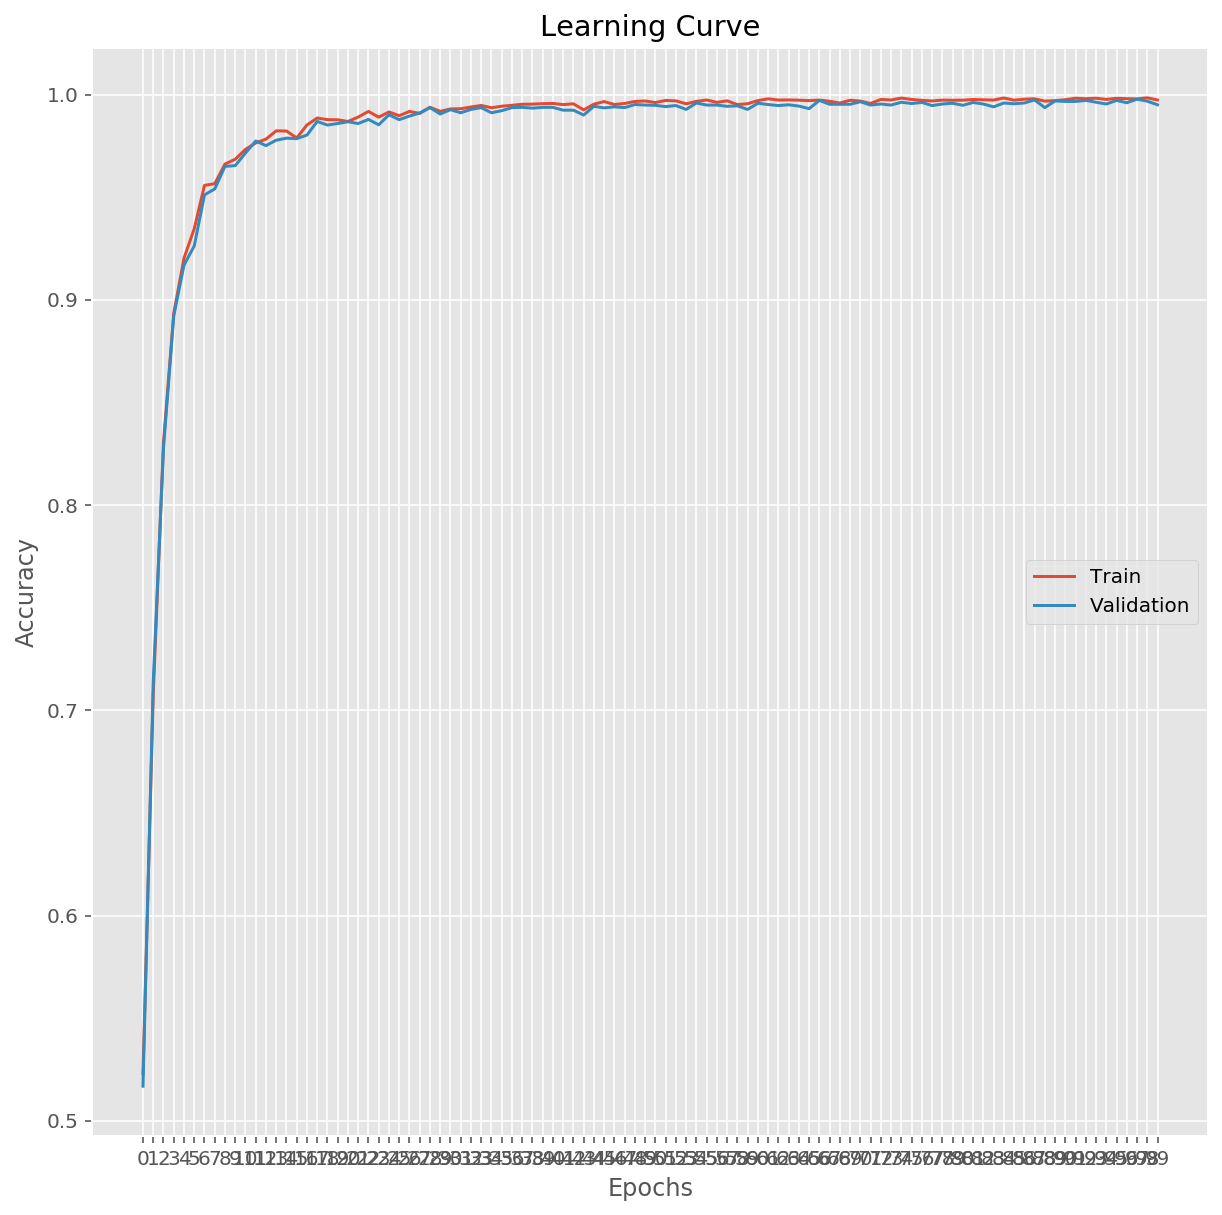

In [60]:
def base_network_2_0(input_shape=INPUT_SHAPE): # Method architecture for final network 2.0.
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .dropout(keep_prob=0.5) # Drop out layer added (as defined with 'network.py')
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_2_0(), make_adam(0.5e-3)) # Learning Rate = 0.0005
    learning_curve = train_evaluate(pipeline, epochs=100) # Model evaluated over 100 epochs.
    session.save('Checkpoint/base_network_2_0.ckpt') # Model is saved as an checkpoint / index.
    
create_learning_curve(learning_curve) # Model evaluated using learning curve chart.

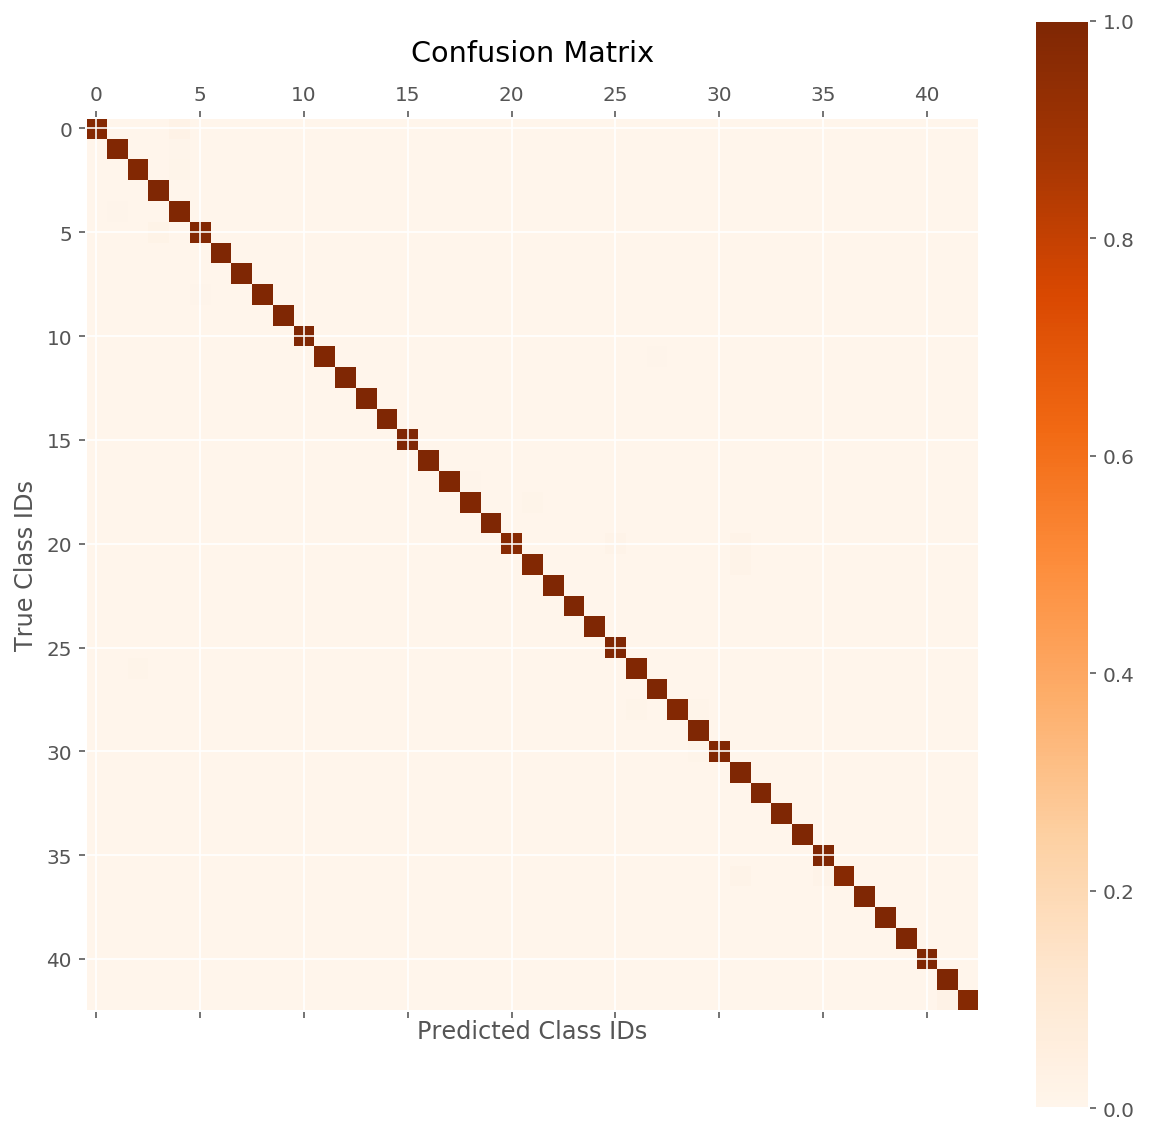

 3 Speed limit (60km/h)                               100.00% 1122
 6 End of speed limit (80km/h)                        100.00%  334
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
12 Priority road                                      100.00% 1672
13 Yield                                              100.00% 1719
14 Stop                                               100.00%  621
15 No vehicles                                        100.00%  501
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
22 Bumpy road                                         100.00%  310
23 Slippery road                                      100.00%  406
24 Road narrows on the right                          100.00%  215
25 Road work                                          100.00% 1194
27 Pedestrians                                        100.00%  191
29 Bicycles crossing                                  100.00% 

In [61]:
%%time
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_2_0())
    session.load('Checkpoint/base_network_2_0.ckpt')  
    prediction_pipeline = pipeline.predict(X_valid)
     
# Plot & Examine Confusion Matrix
plotting_y_valid_pred = confusion_matrix(y_valid, prediction_pipeline)
cm = plotting_y_valid_pred
create_confusion_matrix(cm)
output_confusion_matrix(cm)

#### Short Summary:

The impact of adding dropout had significantly improved model performance, with network accuracy peaking at (99.7%) for training and (99.5%) for validation after 100 epochs. Thus performance being better than previous phases.

**Code Reference:**

- base_network_2_0() method defines the network model architecture.
    - Drop out layer added.
- create_learning_curve() method called upon by passing in the accuracy scores appended within 'learning_curve' earlier on.
- Once model is trained, 'Session()' method is called upon to save the trained model as an index to later then generate chart plots.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) Udacity CarND (2020) [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project]

## Post-Training Image Pre-Process

I decided to carry out image pre-processing once more, but this time around, using the trained model (base_network2_0) architecture. The purpose of this test is to see whether average training accuracy for all 43 classes can equal 100% (perfect classification on training dataset). Below is a summary of different pre-processes that author explored, having followed tutorials online.


### Image Enhancement

Taking a weighted average of the original image and the blurred image to make in order to smooth out the noises.

In [62]:
def enhance_image(image, ksize, weight): # Enhance image method.
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0) # Gaussian Blur image effect is applied which is derived from OpenCV.
    return cv2.addWeighted(image, weight, blurred, -weight, image.mean())

In [63]:
for ksize in [5, 7, 9, 11]: # Size of gaussian blur effect.
    for weight in [4, 6, 8, 10]: # Set of image weights.
        print('Enhancer: k={} w={}'.format(ksize, weight))
        with Session() as session:
            enhancer = lambda x: enhance_image(x, ksize, weight)
            functions = [loader, augmenter, enhancer, normalizer]
            pipeline = build_pipeline(functions, session, base_network_2_0()) # Loads Network 2.0 for image enhancement.
            session.load('Checkpoint/base_network_2_0.ckpt')# Saves trained network as a checkpoint / index.
            score = pipeline.score(X_valid, y_valid) # Pipeline accuracy score is accounted for.
            print('Validation Score: {}'.format(score))
        print()

Enhancer: k=5 w=4
Validation Score: 0.57475

Enhancer: k=5 w=6
Validation Score: 0.542625

Enhancer: k=5 w=8
Validation Score: 0.531875

Enhancer: k=5 w=10
Validation Score: 0.5135

Enhancer: k=7 w=4
Validation Score: 0.680875

Enhancer: k=7 w=6
Validation Score: 0.643875

Enhancer: k=7 w=8
Validation Score: 0.618

Enhancer: k=7 w=10
Validation Score: 0.607

Enhancer: k=9 w=4
Validation Score: 0.753625

Enhancer: k=9 w=6
Validation Score: 0.71725

Enhancer: k=9 w=8
Validation Score: 0.694375

Enhancer: k=9 w=10
Validation Score: 0.665875

Enhancer: k=11 w=4
Validation Score: 0.802375

Enhancer: k=11 w=6
Validation Score: 0.769

Enhancer: k=11 w=8
Validation Score: 0.744125

Enhancer: k=11 w=10
Validation Score: 0.72775



In [64]:
enhancer = lambda x: enhance_image(x, 9, 8) # x = data, enchancer method execute image enhancement technique.

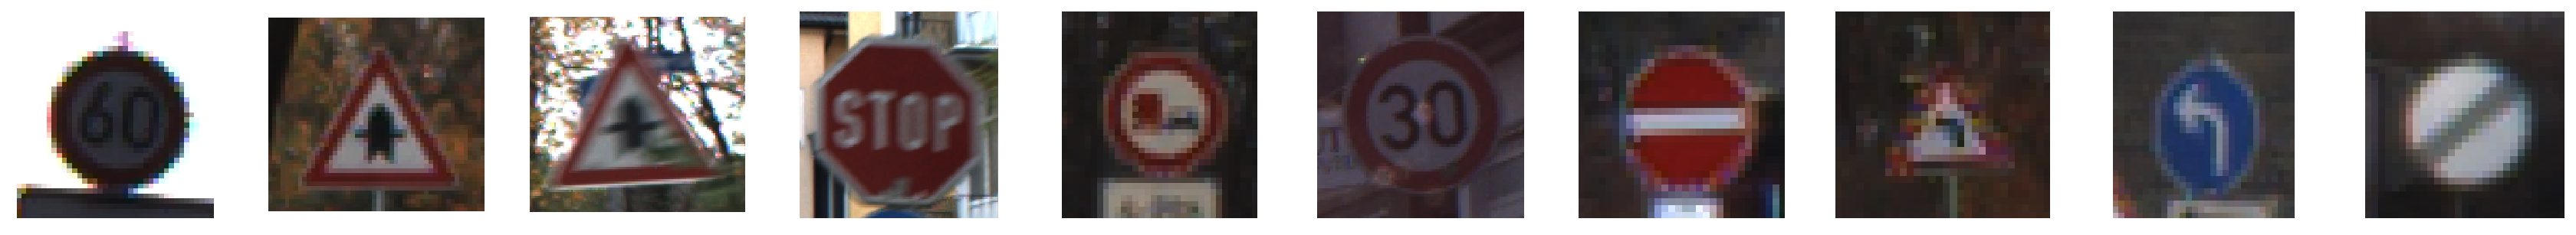

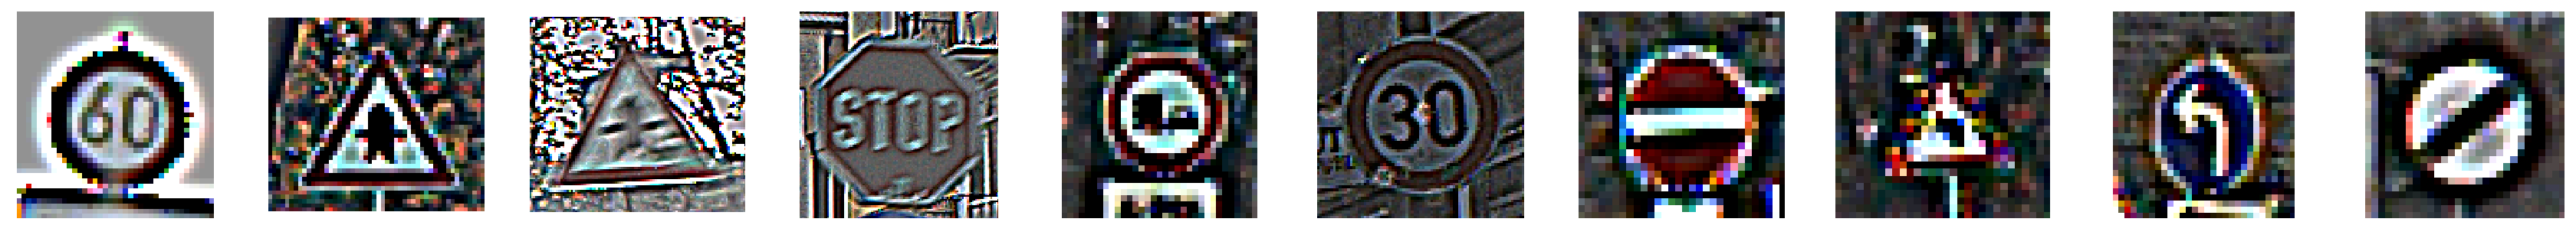

In [65]:
show_images(sample_data[10:], cols=10) # Loads a sample of 10 images to show image enhancement effect.
show_images(sample_data[10:], cols=10, func=enhancer)

#### Short Summary:

Image enhancement is used to improve the interpretability or perception of detail in images or prepare images in a way that other image-processing techniques can then use. It was done by taking a weighted average of the original image to smooth out the noises. Upon testing (base_network2_0), the performance was not significant as training/validation accuracy peaked at a max of 80%.

### Histogram Equalizaition

In [66]:
def equalizer(image): # Method that for Histogram Equalisation.
    image = image.copy() # Replicates a copy of each image.
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i]) # Open CV is used for equalisation.
    return image # Improves the color ratio and pixel intensity of each image.

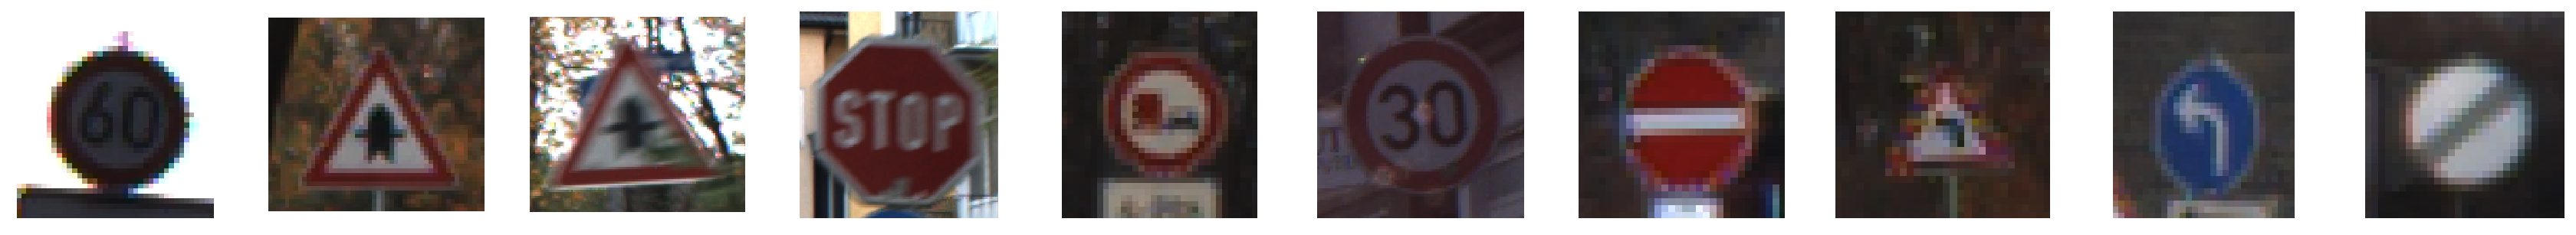

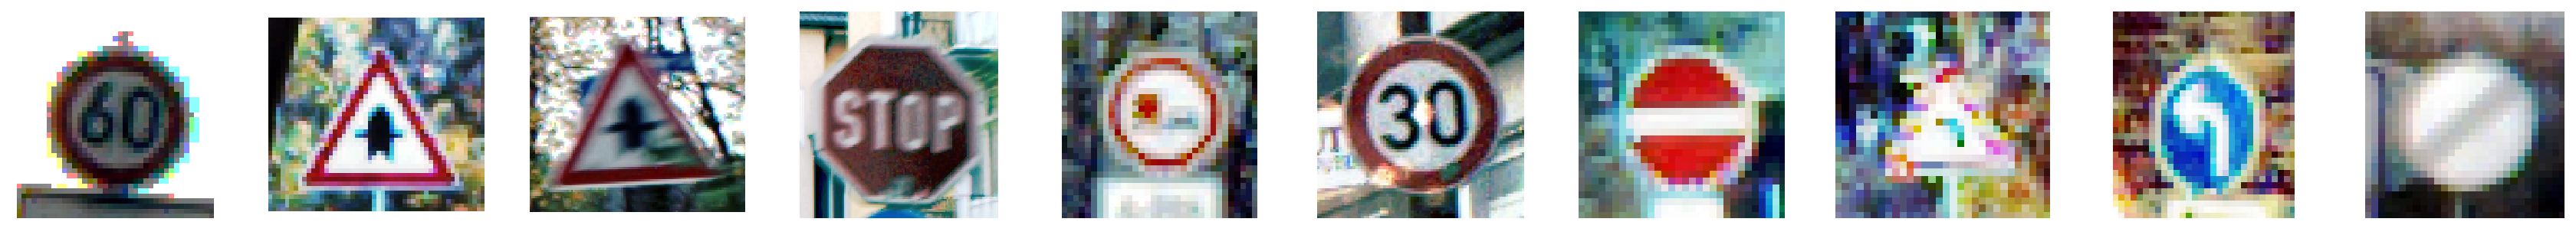

In [67]:
show_images(sample_data[10:], cols=10) # Shows the effect of image process on sample of 10 images.
show_images(sample_data[10:], cols=10, func=equalizer) # Equaliser effect is added to images then shown new set of images.

In [68]:
with Session() as session:
    functions = [loader, augmenter, equalizer, normalizer] # 
    pipeline = build_pipeline(functions, session, base_network_2_0())
    session.load('Checkpoint/base_network_2_0.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print('Validation Score: {:.3f}'.format(score))

Validation Score: 0.921


#### Short Summary:

Upon testing (base_network2_0) the result returned a lower training/validation accuracy (92%), though it has performed better than image-enhancement technique, the model being run without histogram equalisation performed better hence why this technique will not be considered for processing.

In [69]:
with Session() as session:
    functions = [loader, augmenter, equalizer, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, base_network_2_0())
    session.load('Checkpoint/base_network_2_0.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.610125


#### Short Summary

Combining both enhancement and histogram equalisation did not improve result and returned accuracy score of 61%.

### Min-Max Normalisation

In [70]:
def min_max_norm(image): # Min-Max Normalisation Method
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX) # Image is normalised using individual normalisation parameters.

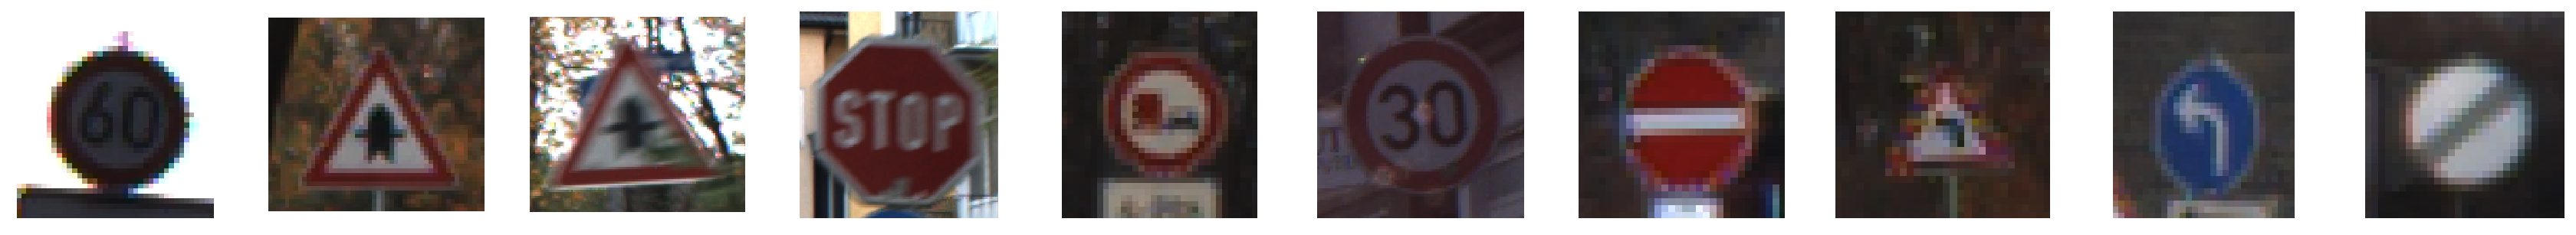

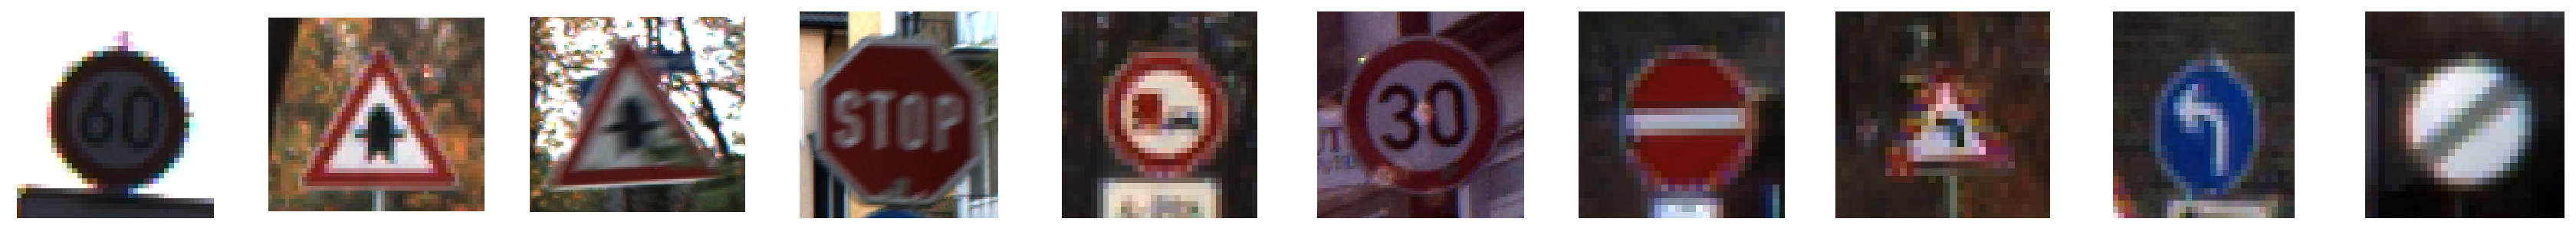

In [71]:
show_images(sample_data[10:], cols=10) # Returns sample of 10 images.
show_images(sample_data[10:], cols=10, func=min_max_norm) # Returns sample of 10 images post normalisation.

In [72]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, normalizer]
    pipeline = build_pipeline(functions, session, base_network_2_0())
    session.load('Checkpoint/base_network_2_0.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.995


#### Short Summary

This time around with normalisation the minimum value of each feature is converted to a 0, the maximum value is converted to a 1, and all other values are converted to a decimal between 0 and 1. Upon testing (base_network2_0), the result returned a high accuracy score (99.5%), proving normalisation is the best image pre-processing technique. 

In [73]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, base_network_2_0())
    session.load('Checkpoint/base_network_2_0.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.7135


#### Short Summary:

Though when combined with the image enhancement, the accuracy score returned lower at 71.5%.

**Code Reference:**

- base_network2_0 was passed through all image pre-process.
- session.load was ammended by author to adapt to my test.
- All implementation of new image process have been derived from author Naioki Shibuya.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).
- (2) OpenCV (2020) [http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize]
- (3) OpenCV (2020) [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html]
- (4) Medium (2020) [https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2#:~:text=Histogram%20Equalization%20is%20an%20image,intensity%20range%20of%20the%20image.]

## Evaluating Model using Test Dataset

Test images are in one folder.  So, we can simply load them as follows:

Test images do not have category folders but all are kept in one place with one label file.

```
data
 + Final_Test
    + Images
        + 00000.ppm
        + 00001.ppm
        + ...
        + GT-final_test.csv      # Extended annotations including class ids.
        + GT-final_test.test.csv
```

I also downloaded GT-final_test.csv which contains extended annotations including class ids for test images.

In [74]:
TEST_IMAGE_DIR = 'data/Final_Test/Images' # File path that stores all test images.

# Note: GT-final_test.csv comes with class IDs (GT-final_test.test.csv does not)
test_df = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
test_df.head()

Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  \
0  data/Final_Test/Images/00000.ppm     53      54       6       5      48   
1  data/Final_Test/Images/00001.ppm     42      45       5       5      36   
2  data/Final_Test/Images/00002.ppm     48      52       6       6      43   
3  data/Final_Test/Images/00003.ppm     27      29       5       5      22   
4  data/Final_Test/Images/00004.ppm     60      57       5       5      55   

   Roi.Y2  ClassId  
0      49       16  
1      40        1  
2      47       38  
3      24       33  
4      52       11

In [75]:
print("Number of test images: {:>5}".format(test_df.shape[0])) # Formats the data-frame to specify test image available.

Number of test images: 12630


In [76]:
X_test = test_df['Filename'].values # Specifies test_df to highlight Filename column.
y_test = test_df['ClassId'].values  # Specifies test_df to highlight ClassID column.

In [77]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_2_0())
    session.load('Checkpoint/base_network_2_0.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {}'.format(score))

Test Score: 0.9509897070467141


#### Short Summary:

The testing dataset, as mentioned within the data-analysis section, consists of 12,630 images. Upon running the final model on the test set, the test-accuracy score returned 95%. Now for simple network architecture, this result is sufficient. However, utilising a more complex network may have derived a better result.

**Code Reference:**

- base_network2_0 was loaded to be trained using test data.
- session.load was ammended by author to adapt to my test.
- All the main implementation methods have been derived from author Naioki Shibuya.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).

## Evaluating Model using Images from Web

In [78]:
X_new = np.array(glob.glob('images/sign*.jpg') + # Returns sample images stored within images/sign path.
                 glob.glob('images/sign*.png'))

In [79]:
new_images = [plt.imread(path) for path in X_new] # Plots sample images.

--------------------------------------------------------------------------------
New Images for Random Testing
--------------------------------------------------------------------------------


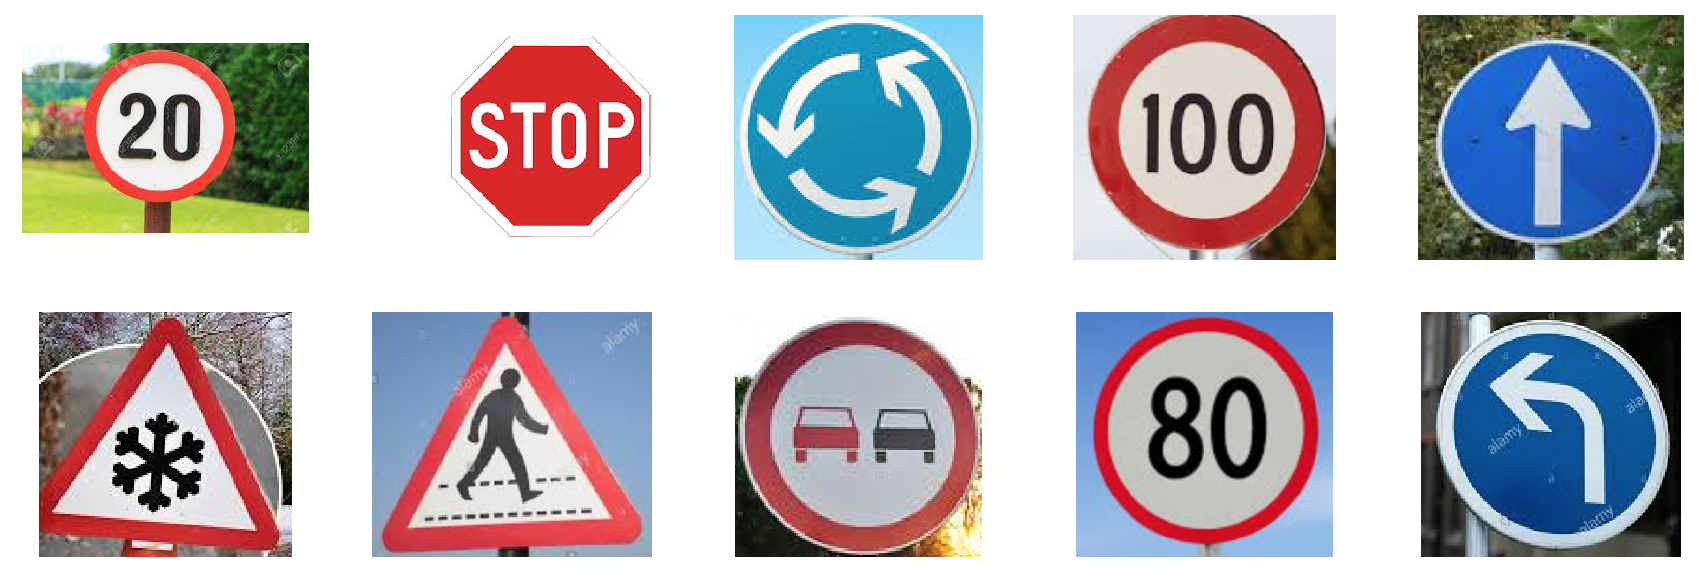

In [80]:
print('-' * 80)
print('New Images for Random Testing')
print('-' * 80)

plt.figure(figsize=(15,5))
for i, image in enumerate(new_images): # Returns all new sample images and plots on grid.
    plt.subplot(2,len(X_new)//2,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])    
plt.show()

In [81]:
print('Getting Top 5 Results:')

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, base_network_2_0()) # Pipeline modified for network 2.0
    session.load('Checkpoint/base_network_2_0.ckpt')  # Loads pipeline framework from Checkpoint.
    prob = pipeline.predict_proba(X_new) # New predictions are made upon the new sample images.
    estimator = pipeline.steps[-1][1]
    top_5_prob, top_5_pred = estimator.top_k_ # Estimator function from pipeline scikit is used to predict (pipeline.py)

Getting Top 5 Results:


--------------------------------------------------------------------------------
Top 5 Predictions
--------------------------------------------------------------------------------


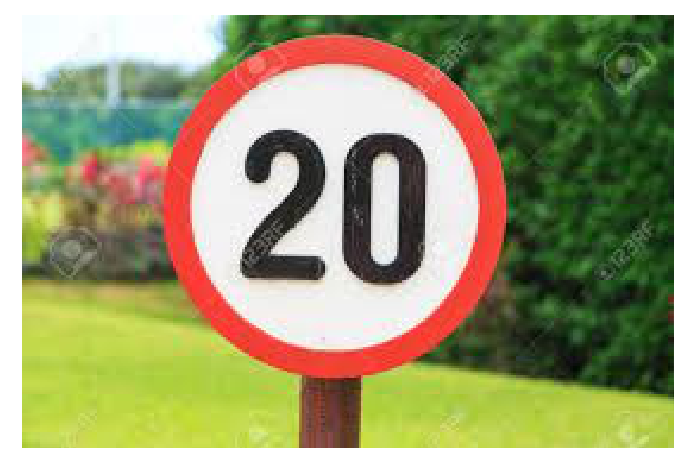

    4: Speed limit (70km/h)                               ( 94.7697162628%)
    0: Speed limit (20km/h)                               (  4.8885934055%)
    8: Speed limit (120km/h)                              (  0.3008940257%)
   24: Road narrows on the right                          (  0.0398244942%)
   23: Slippery road                                      (  0.0004294854%)
--------------------------------------------------------------------------------


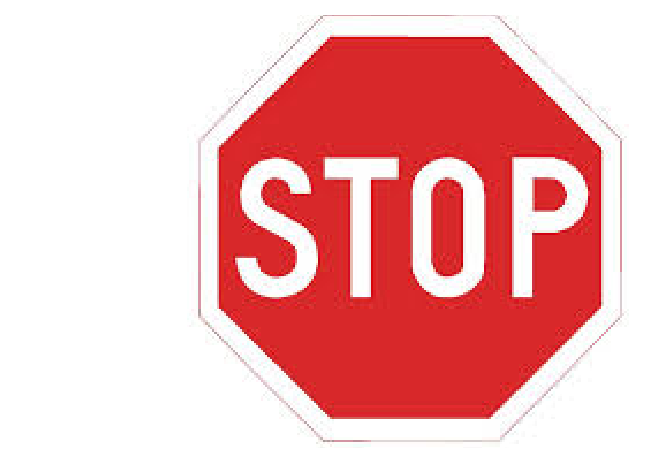

   14: Stop                                               (100.0000000000%)
   17: No entry                                           (  0.0000000148%)
   29: Bicycles crossing                                  (  0.0000000006%)
    1: Speed limit (30km/h)                               (  0.0000000006%)
    0: Speed limit (20km/h)                               (  0.0000000000%)
--------------------------------------------------------------------------------


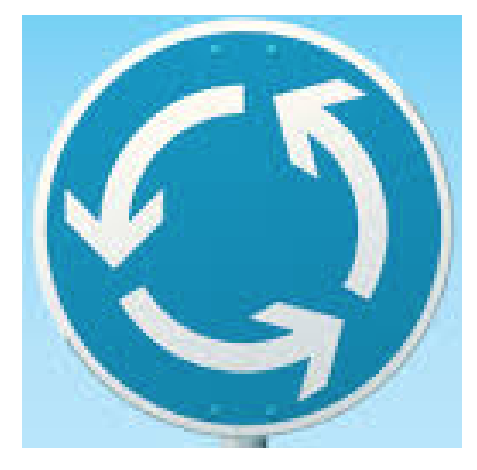

   40: Roundabout mandatory                               ( 99.2005646229%)
   35: Ahead only                                         (  0.6941614207%)
   37: Go straight or left                                (  0.0487272308%)
   34: Turn left ahead                                    (  0.0317863742%)
   38: Keep right                                         (  0.0218732428%)
--------------------------------------------------------------------------------


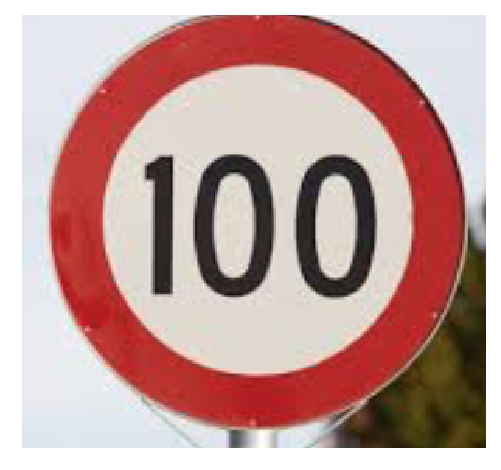

    5: Speed limit (80km/h)                               ( 99.9939322472%)
    7: Speed limit (100km/h)                              (  0.0055454835%)
    8: Speed limit (120km/h)                              (  0.0005284454%)
    2: Speed limit (50km/h)                               (  0.0000019805%)
    0: Speed limit (20km/h)                               (  0.0000000918%)
--------------------------------------------------------------------------------


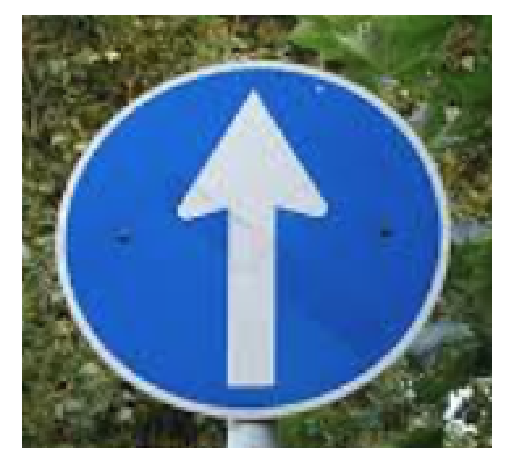

   35: Ahead only                                         (100.0000000000%)
   36: Go straight or right                               (  0.0000000000%)
   37: Go straight or left                                (  0.0000000000%)
   34: Turn left ahead                                    (  0.0000000000%)
   33: Turn right ahead                                   (  0.0000000000%)
--------------------------------------------------------------------------------


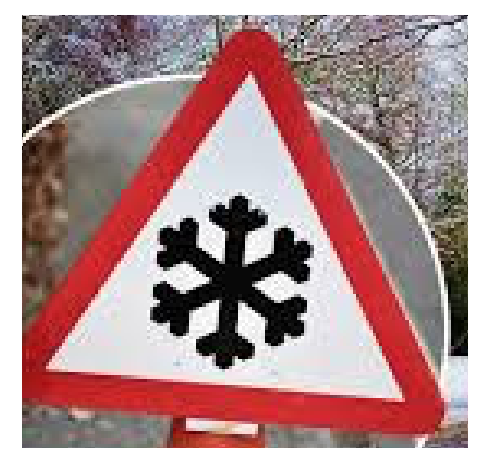

   22: Bumpy road                                         ( 99.9977231026%)
   29: Bicycles crossing                                  (  0.0022664955%)
   28: Children crossing                                  (  0.0000102543%)
    0: Speed limit (20km/h)                               (  0.0000001000%)
   23: Slippery road                                      (  0.0000000832%)
--------------------------------------------------------------------------------


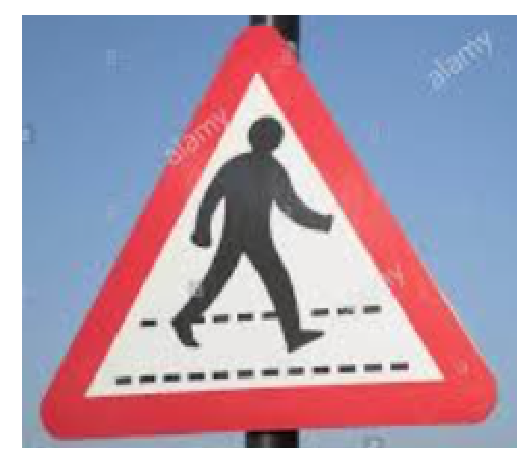

   11: Right-of-way at the next intersection              ( 96.7711627483%)
   27: Pedestrians                                        (  2.7696158737%)
   18: General caution                                    (  0.4451874178%)
   28: Children crossing                                  (  0.0090447676%)
   20: Dangerous curve to the right                       (  0.0036922538%)
--------------------------------------------------------------------------------


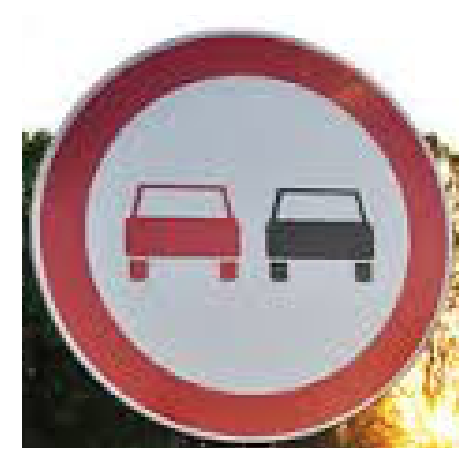

    9: No passing                                         ( 99.9964714050%)
   41: End of no passing                                  (  0.0025368008%)
   15: No vehicles                                        (  0.0009486766%)
   13: Yield                                              (  0.0000236600%)
    4: Speed limit (70km/h)                               (  0.0000060991%)
--------------------------------------------------------------------------------


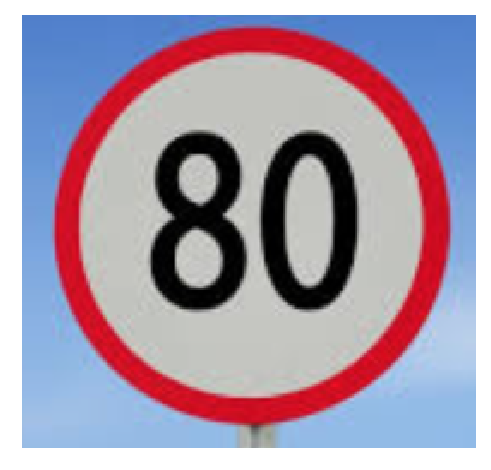

    2: Speed limit (50km/h)                               ( 42.8405493498%)
    3: Speed limit (60km/h)                               ( 32.5866132975%)
    5: Speed limit (80km/h)                               ( 23.6036747694%)
    1: Speed limit (30km/h)                               (  0.9512281045%)
    6: End of speed limit (80km/h)                        (  0.0094341958%)
--------------------------------------------------------------------------------


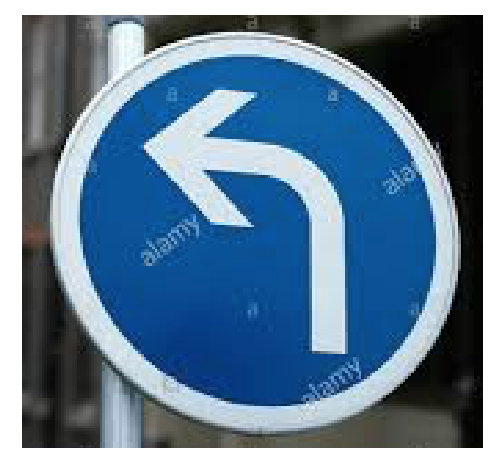

   34: Turn left ahead                                    ( 99.9997854233%)
   35: Ahead only                                         (  0.0002180813%)
   33: Turn right ahead                                   (  0.0000004128%)
   38: Keep right                                         (  0.0000000629%)
   37: Go straight or left                                (  0.0000000348%)
--------------------------------------------------------------------------------


In [82]:
print('-' * 80)
print('Top 5 Predictions')
print('-' * 80)

for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)): # Loops for each image from sample, prediction and output prediction
    plt.imshow(image) # Plots the images
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = TRAFFIC_SIGN_NAMES[pred]                                     # Predicted values are tested against each image from TRAFFIC_SIGN_NAMES dataframe.
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0)) # Outputs probability distribution of each image
    print('-' * 80)    

#### Short Summary:

Finally, author decided to evaluate the model against sample images from the internet to ensure the model was unbiased. So ten random traffic-sign images had been chosen, as seen from Figure 3 above. The success was determined by how well the model can classify all 10 images close to 100%. The result highlighted 6 out of 10 images had been classified, achieving an accuracy score of (97-100%) as shown within Appendix F: SoftMax Classifier results. The 3 traffic-sign images that struggled include the following:
(1) Pedestrians Only, (2) Speed-Limit (80 km), which model is classified as 30 km & (3) Speed-Limit (100 km), which model is classified as 80km.  

As for the speed limits (20km, 80km, 100km) speed signs, this misclassification may have occured be due to the image distortion by the resizing operation.  We may need a better way to resize images.  But this is yet to be proven at this stage.

I can understand why it did not identify the pedestrian correctly as it's not a German traffic sign.  But it's quite similar to it.  So, a human would have recognized this? 


**Code Reference:**

- No modifications have been made for evaluating model on images from web. 
- All the main implementation methods have been derived from author Naioki Shibuya.

The inspiration behind implementing this code was taken from:
- (1) Naioki Shibuya (2017) [https://github.com/naokishibuya] (overall implementation, few elements been changed including naming convention to then adapt to my model).